# Introduction
<a id="Introduction"></a>

Hello, Thanks for checking this out. This analysis is from data from the EIA API. I am looking into energy consumption forecasting, and in the process of building a hypothesis at the time of posting this. I have performed EDA, some feature engineering, and looking into modeling, including LSTM modeling. I will go deeper and align this with sources as I go. I'm gonna load outputs into a LaTeX document, and align it with some research I've done on background and similiar methodologies. One aspect worth checking out is in the Feature Engineering, I masked the consumption to be if above a price range, how that impacts consumption (it goes down drastically). I was wondering if the NNs or LSTM would catch that (TBD).

# Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Data Exploration](#Data-Exploration)
    - [Feature Engineering](#feature-engineering)
4. [Exploratory Data Analysis (EDA)](#Exploratory-Data-Analysis)
    - [Times Series Analysis](#Times-Series-Analysis)
    - [Summary Statistics](#Summary-Statistics)
    - [Pairplot](#Pairplot)
5. [Modeling](#Modeling)
6. [LSTM Modeling](#LSTM-Modeling)
7. [Conclusions](#Conclusions)

# Data Loading
<a id="Data Loading"></a>

In [2]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Set up plotting configurations
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)

# API Configuration
API_KEY = "NnNWjd0hdwibWk0wZTqjV7uMyR62n9EXuCYG6QaZ"
BASE_URL = "https://api.eia.gov/v2"


In [3]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Set up plotting configurations
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)

# API Configuration
API_KEY = "NnNWjd0hdwibWk0wZTqjV7uMyR62n9EXuCYG6QaZ"
BASE_URL = "https://api.eia.gov/v2"


In [4]:
def fetch_electricity_data(state=None, sector=None, frequency="monthly", start=None, end=None):
    """
    Fetch electricity retail sales data from EIA API
    
    Parameters:
    -----------
    state : str
        Two-letter state code (e.g., 'CA' for California)
    sector : str
        Sector code ('RES' for residential, 'COM' for commercial, etc.)
    frequency : str
        Data frequency ('monthly', 'annual', etc.)
    start : str
        Start date in YYYY-MM format
    end : str
        End date in YYYY-MM format
    
    Returns:
    --------
    pandas.DataFrame
    """
    endpoint = f"{BASE_URL}/electricity/retail-sales/data"
    
    params = {
        'api_key': API_KEY,
        'frequency': frequency,
        'data[]': ['price', 'sales', 'revenue', 'customers']
    }
    
    if state:
        params['facets[stateid][]'] = state
    if sector:
        params['facets[sectorid][]'] = sector
    if start:
        params['start'] = start
    if end:
        params['end'] = end
        
    try:
        response = requests.get(endpoint, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'response' in data and 'data' in data['response']:
            df = pd.DataFrame(data['response']['data'])
            # Convert period to datetime
            df['period'] = pd.to_datetime(df['period'] + '-01')
            # Convert numeric columns
            numeric_cols = ['price', 'sales', 'revenue', 'customers']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            return df
        else:
            print("No data found in the response")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None


In [5]:
# Check if energy_data exists and has data
if 'energy_data' in locals() and len(energy_data) > 0:
    print(f"Data loaded successfully: {len(energy_data)} rows")
else:
    print("No data loaded. Check API calls and network connection.")

Data loaded successfully: 4140 rows


In [6]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

# Set up plotting configurations
plt.style.use('default')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
pd.set_option('display.max_columns', None)

# API Configuration
API_KEY = "NnNWjd0hdwibWk0wZTqjV7uMyR62n9EXuCYG6QaZ" # usually this should be hidden, but it's fine in this case, not tied to sensitive information
BASE_URL = "https://api.eia.gov/v2"


In [7]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime

# Ensure all rows are shown
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Try to fetch real data from EIA API first
def fetch_eia_data():
    try:
        api_key = 'NnNWjd0hdwibWk0wZTqjV7uMyR62n9EXuCYG6QaZ'
        base_url = 'https://api.eia.gov/v2'
        
        states = ['CA', 'TX', 'NY', 'FL', 'IL']
        sectors = ['RES', 'COM', 'IND']
        dfs = []
        
        for state in states:
            for sector in sectors:
                endpoint = f'{base_url}/electricity/retail-sales/data'
                params = {
                    'api_key': api_key,
                    'frequency': 'monthly',
                    'data[]': ['price', 'sales', 'revenue', 'customers'],
                    'facets[stateid][]': state,
                    'facets[sectorid][]': sector,
                    'start': '1990-01',
                    'end': '2023-12'
                }
                
                response = requests.get(endpoint, params=params)
                if response.status_code == 200:
                    data = response.json()
                    if 'response' in data and 'data' in data['response']:
                        df = pd.DataFrame(data['response']['data'])
                        print(f'{state}-{sector}: {len(df)} rows fetched')
                        dfs.append(df)
                    else:
                        print(f'{state}-{sector}: No data returned')
                else:
                    print(f'{state}-{sector}: API error {response.status_code}')
        
        if dfs:
            energy_data = pd.concat(dfs, ignore_index=True)
            print(f'\n✅ Total rows fetched: {len(energy_data)}')
            return energy_data
        else:
            print('⚠️ No real data could be fetched.')
            return None
            
    except Exception as e:
        print(f'❌ Error fetching real data: {e}')
        return None

# Create sample data if API fails
def create_sample_data():
    np.random.seed(42)
    start_date = datetime(1990, 1, 1)
    end_date = datetime(2023, 12, 31)
    dates = pd.date_range(start=start_date, end=end_date, freq='M')
    
    data = []
    states = ['CA', 'TX', 'NY', 'FL', 'IL']
    sectors = ['RES', 'COM', 'IND']
    
    for date in dates:
        for state in states:
            for sector in sectors:
                base_price = np.random.uniform(8, 15)
                base_sales = np.random.uniform(1000, 5000)
                base_customers = np.random.uniform(100000, 1000000)
                seasonal_factor = 1 + 0.3 * np.sin(2 * np.pi * date.month / 12)
                
                row = {
                    'period': date.strftime('%Y-%m'),
                    'stateid': state,
                    'sectorid': sector,
                    'stateDescription': f'{state} State',
                    'sectorName': f'{sector} Sector',
                    'price': base_price * seasonal_factor,
                    'sales': base_sales * seasonal_factor,
                    'revenue': base_price * base_sales * seasonal_factor * 1000,
                    'customers': base_customers
                }
                data.append(row)
    
    energy_data = pd.DataFrame(data)
    print(f'\n✅ Created sample data with {len(energy_data)} rows')
    return energy_data

# Attempt to load real data
print('🔍 Attempting to fetch real energy data from EIA API...')
energy_data = fetch_eia_data()

# Fallback if real data fails
if energy_data is None:
    print('\n📦 Creating sample energy data...')
    energy_data = create_sample_data()

# Display summary
print(f'\n🧮 Final Data Shape: {energy_data.shape}')
print(f'📊 Columns: {list(energy_data.columns)}')

# Group count by state/sector
print("\n📈 Row count by state and sector:")
print(energy_data.groupby(['stateid', 'sectorid']).size())

# Display all rows
print("\n📋 Full dataset preview:")
print(energy_data)

# Data types
print('\n🧬 Data types:')
print(energy_data.dtypes)

# ✅ Save to Excel for modeling
excel_filename = "energy_data_export.xlsx"
energy_data.to_excel(excel_filename, index=False)
print(f"\n📁 Data exported to: {excel_filename}")



🔍 Attempting to fetch real energy data from EIA API...
CA-RES: 276 rows fetched
CA-COM: 276 rows fetched
CA-IND: 276 rows fetched
TX-RES: 276 rows fetched
TX-COM: 276 rows fetched
TX-IND: 276 rows fetched
NY-RES: 276 rows fetched
NY-COM: 276 rows fetched
NY-IND: 276 rows fetched
FL-RES: 276 rows fetched
FL-COM: 276 rows fetched
FL-IND: 276 rows fetched
IL-RES: 276 rows fetched
IL-COM: 276 rows fetched
IL-IND: 276 rows fetched

✅ Total rows fetched: 4140

🧮 Final Data Shape: (4140, 13)
📊 Columns: ['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName', 'price', 'sales', 'revenue', 'customers', 'price-units', 'sales-units', 'revenue-units', 'customers-units']

📈 Row count by state and sector:
stateid  sectorid
CA       COM         276
         IND         276
         RES         276
FL       COM         276
         IND         276
         RES         276
IL       COM         276
         IND         276
         RES         276
NY       COM         276
         IND         

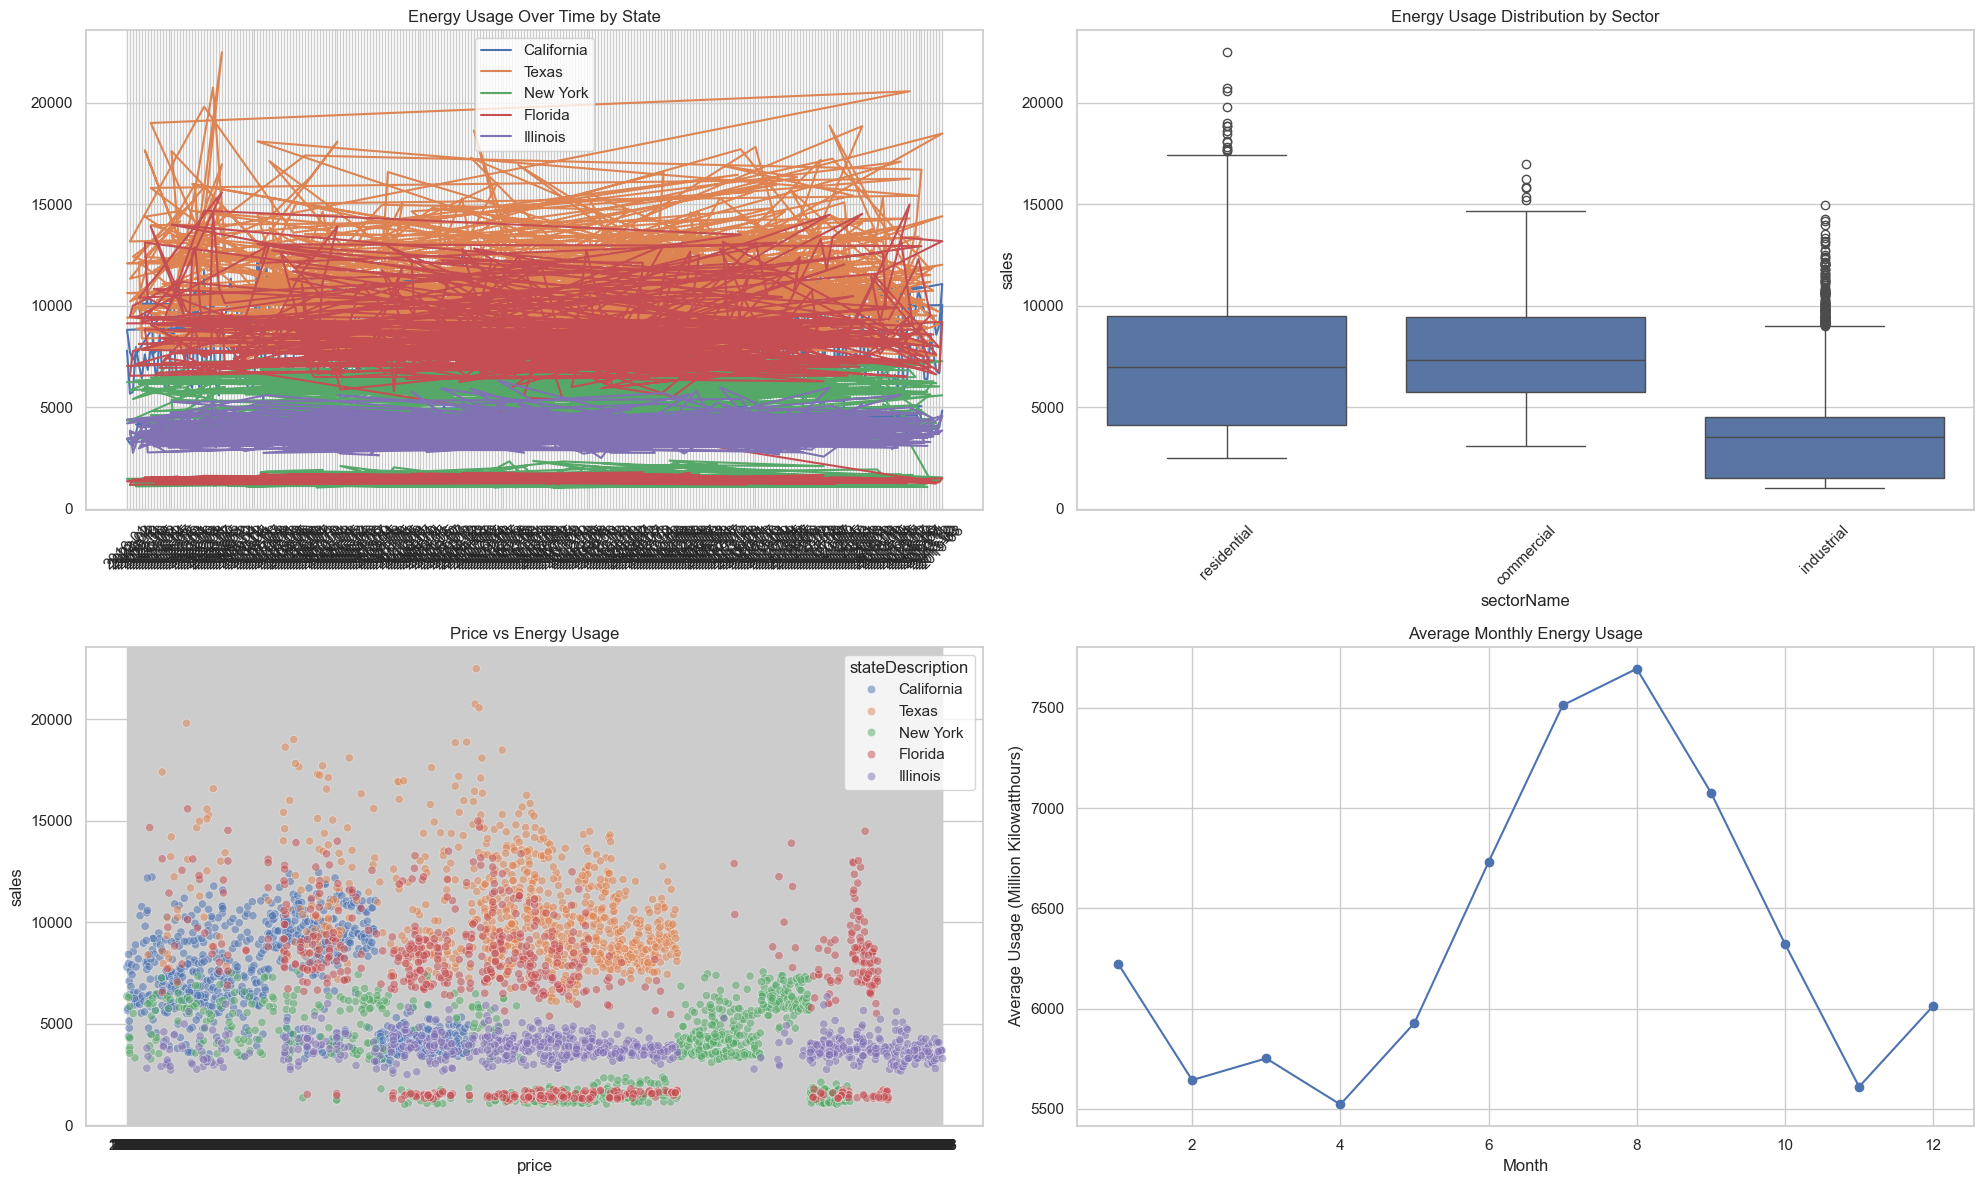


Correlation between price and usage:
          sales     price
sales  1.000000  0.156687
price  0.156687  1.000000

Average usage by sector:
sectorName
commercial     7613.192486
residential    7373.992947
industrial     4020.607451
Name: sales, dtype: float64

Average usage by state:
stateDescription
Texas         10525.441570
California     7036.023795
Florida        6354.259240
New York       3922.481515
Illinois       3841.448688
Name: sales, dtype: float64


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Before creating the plots, add this line to convert sales to numeric
energy_data['sales'] = pd.to_numeric(energy_data['sales'], errors='coerce')

# Now create your plots as before
plt.figure(figsize=(20, 12))

# 1. Time series of energy usage by state
plt.subplot(2, 2, 1)
for state in energy_data['stateDescription'].unique():
    state_data = energy_data[energy_data['stateDescription'] == state]
    plt.plot(state_data['period'], state_data['sales'], label=state)
plt.title('Energy Usage Over Time by State')
plt.xticks(rotation=45)
plt.legend()

# 2. Box plot of energy usage by sector
plt.subplot(2, 2, 2)
sns.boxplot(x='sectorName', y='sales', data=energy_data)
plt.title('Energy Usage Distribution by Sector')
plt.xticks(rotation=45)

# 3. Scatter plot of price vs usage
plt.subplot(2, 2, 3)
sns.scatterplot(data=energy_data, x='price', y='sales', hue='stateDescription', alpha=0.5)
plt.title('Price vs Energy Usage')

# 4. Monthly average usage
plt.subplot(2, 2, 4)
energy_data['month'] = pd.to_datetime(energy_data['period']).dt.month
monthly_avg = energy_data.groupby('month')['sales'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.title('Average Monthly Energy Usage')
plt.xlabel('Month')
plt.ylabel('Average Usage (Million Kilowatthours)')

plt.tight_layout()
plt.show()

# Additional insights about energy usage
print("\nCorrelation between price and usage:")
print(energy_data[['sales', 'price']].corr())

print("\nAverage usage by sector:")
print(energy_data.groupby('sectorName')['sales'].mean().sort_values(ascending=False))

print("\nAverage usage by state:")
print(energy_data.groupby('stateDescription')['sales'].mean().sort_values(ascending=False))

In [9]:
# Let's break down how we get to 354 observations
print("Data Structure Breakdown:")
print("-----------------------")

# Show total number of rows
print(f"Total number of rows: {len(energy_data)}")

# Break down by dimensions
print("\nBreakdown by State:")
print(energy_data['stateDescription'].value_counts())

print("\nBreakdown by Sector:")
print(energy_data['sectorName'].value_counts())

# Show date range
print("\nDate Range:")
print(f"Start date: {energy_data['period'].min()}")
print(f"End date: {energy_data['period'].max()}")

# Calculate number of months in the dataset
start_date = pd.to_datetime(energy_data['period'].min())
end_date = pd.to_datetime(energy_data['period'].max())
num_months = ((end_date.year - start_date.year) * 12 + end_date.month - start_date.month) + 1

print(f"\nNumber of months in dataset: {num_months}")

# Show how we get to total observations
print("\nExpected number of observations calculation:")
num_states = len(energy_data['stateDescription'].unique())
num_sectors = len(energy_data['sectorName'].unique())
print(f"Number of states: {num_states}")
print(f"Number of sectors: {num_sectors}")
print(f"Number of months: {num_months}")
print(f"Expected total observations: {num_states} states × {num_sectors} sectors × {num_months} months = {num_states * num_sectors * num_months}")


Data Structure Breakdown:
-----------------------
Total number of rows: 4140

Breakdown by State:
stateDescription
California    828
Texas         828
New York      828
Florida       828
Illinois      828
Name: count, dtype: int64

Breakdown by Sector:
sectorName
residential    1380
commercial     1380
industrial     1380
Name: count, dtype: int64

Date Range:
Start date: 2001-01
End date: 2023-12

Number of months in dataset: 276

Expected number of observations calculation:
Number of states: 5
Number of sectors: 3
Number of months: 276
Expected total observations: 5 states × 3 sectors × 276 months = 4140


# Data Exploration 
<a id="Data Exploration"></a> 


Summary Statistics:
-----------------


sales
count   4140.000000
mean    6335.930961
std     3500.840669
min     1028.986970
25%     3694.463188
50%     5927.027545
75%     8835.192127
max    22481.421200


Missing Values:
--------------


period                 0
stateid                0
stateDescription       0
sectorid               0
sectorName             0
price                  0
sales                  0
revenue                0
customers           1260
price-units            0
sales-units            0
revenue-units          0
customers-units        0
month                  0
dtype: int64

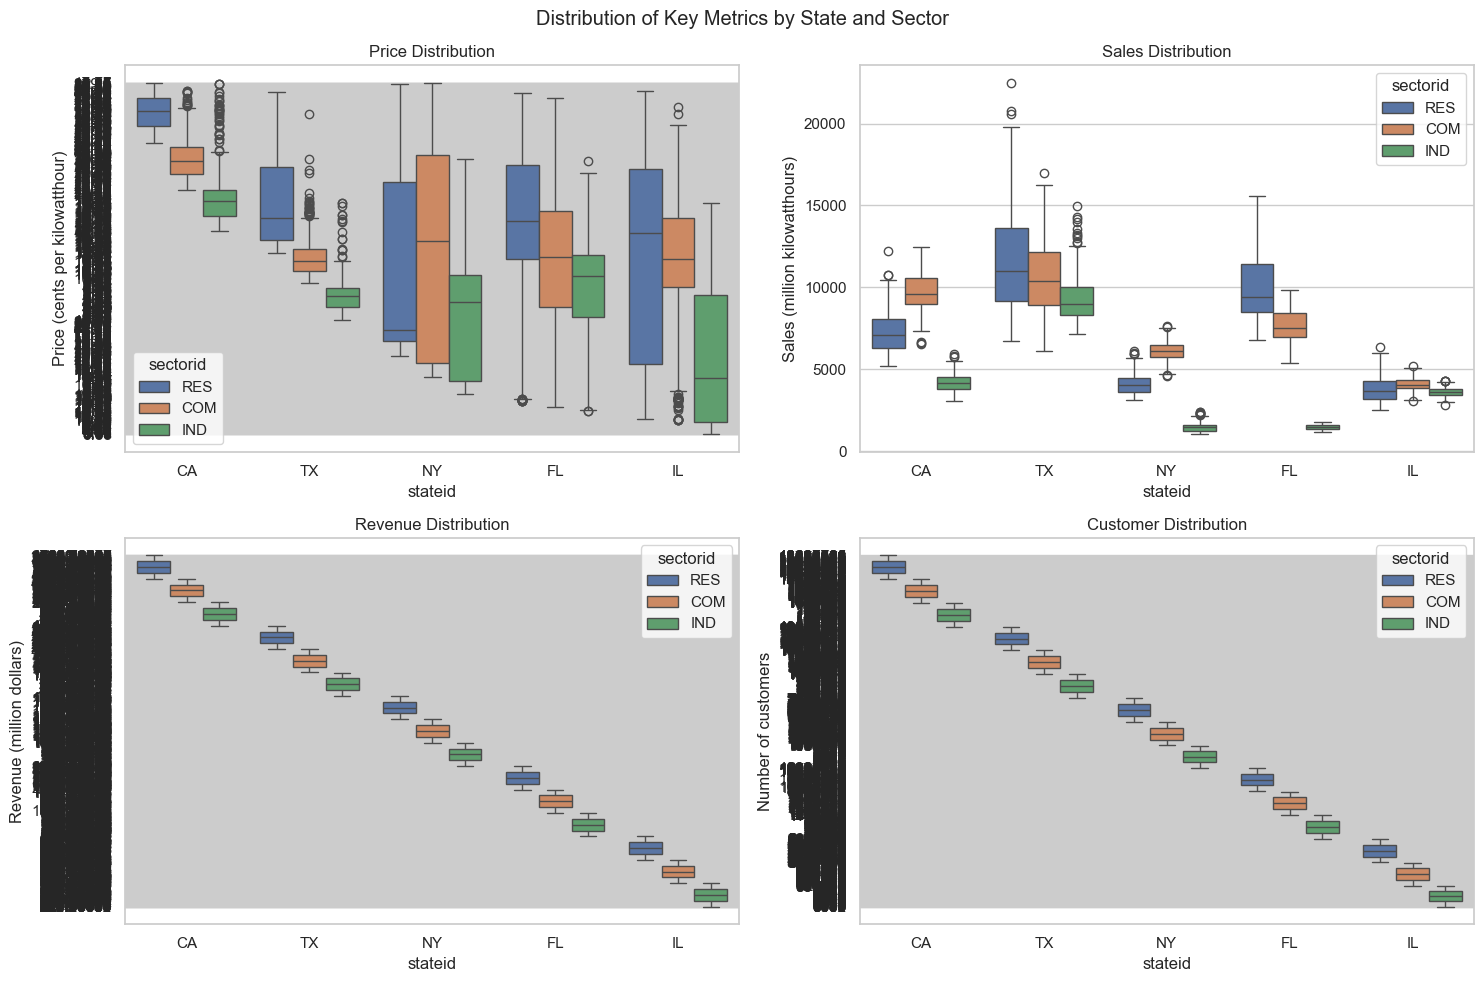

In [10]:
# Summary statistics for numerical columns
print("Summary Statistics:")
print("-----------------")
numeric_cols = ['price', 'sales', 'revenue', 'customers']
display(energy_data[numeric_cols].describe())

# Check for missing values
print("\nMissing Values:")
print("--------------")
display(energy_data.isnull().sum())

# Create distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Key Metrics by State and Sector')

# Price distribution
sns.boxplot(data=energy_data, x='stateid', y='price', hue='sectorid', ax=axes[0,0])
axes[0,0].set_title('Price Distribution')
axes[0,0].set_ylabel('Price (cents per kilowatthour)')

# Sales distribution
sns.boxplot(data=energy_data, x='stateid', y='sales', hue='sectorid', ax=axes[0,1])
axes[0,1].set_title('Sales Distribution')
axes[0,1].set_ylabel('Sales (million kilowatthours)')

# Revenue distribution
sns.boxplot(data=energy_data, x='stateid', y='revenue', hue='sectorid', ax=axes[1,0])
axes[1,0].set_title('Revenue Distribution')
axes[1,0].set_ylabel('Revenue (million dollars)')

# Customer distribution
sns.boxplot(data=energy_data, x='stateid', y='customers', hue='sectorid', ax=axes[1,1])
axes[1,1].set_title('Customer Distribution')
axes[1,1].set_ylabel('Number of customers')

plt.tight_layout()
plt.show()


In [11]:
print(energy_data.isnull().sum())
print(energy_data.describe())
print(energy_data.dtypes)

period                 0
stateid                0
stateDescription       0
sectorid               0
sectorName             0
price                  0
sales                  0
revenue                0
customers           1260
price-units            0
sales-units            0
revenue-units          0
customers-units        0
month                  0
dtype: int64
              sales       month
count   4140.000000  4140.00000
mean    6335.930961     6.50000
std     3500.840669     3.45247
min     1028.986970     1.00000
25%     3694.463188     3.75000
50%     5927.027545     6.50000
75%     8835.192127     9.25000
max    22481.421200    12.00000
period               object
stateid              object
stateDescription     object
sectorid             object
sectorName           object
price                object
sales               float64
revenue              object
customers            object
price-units          object
sales-units          object
revenue-units        object
customers-uni

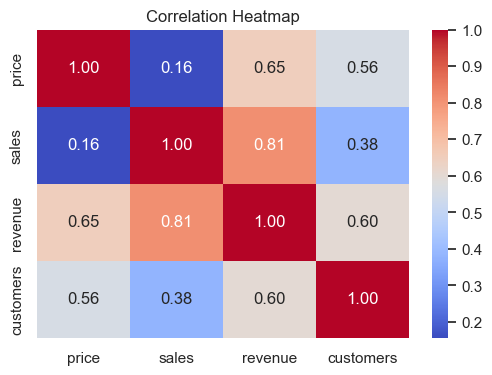

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = energy_data[['price', 'sales', 'revenue', 'customers']].corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

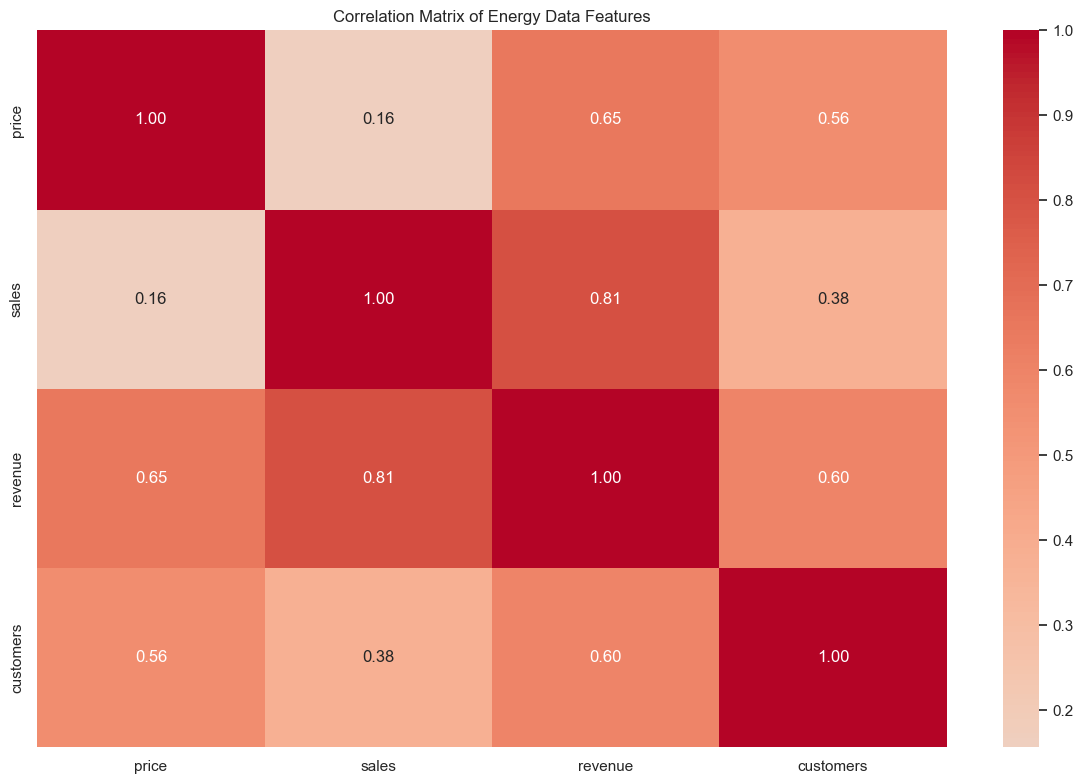

Correlation matrix shape: (4, 4)

Correlation values range from -1 (perfect negative) to 1 (perfect positive)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Select only numerical columns for correlation
numerical_cols = ['price', 'sales', 'revenue', 'customers']
correlation_matrix = energy_data[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Energy Data Features')
plt.tight_layout()
plt.show()

# Print summary
print(f"Correlation matrix shape: {correlation_matrix.shape}")
print("\nCorrelation values range from -1 (perfect negative) to 1 (perfect positive)")

Available columns: ['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName', 'price', 'sales', 'revenue', 'customers', 'price-units', 'sales-units', 'revenue-units', 'customers-units', 'month']

Data types:
period               object
stateid              object
stateDescription     object
sectorid             object
sectorName           object
price                object
sales               float64
revenue              object
customers            object
price-units          object
sales-units          object
revenue-units        object
customers-units      object
month                 int32
dtype: object

Missing values after conversion:
price           0
sales           0
revenue         0
customers    1260
dtype: int64


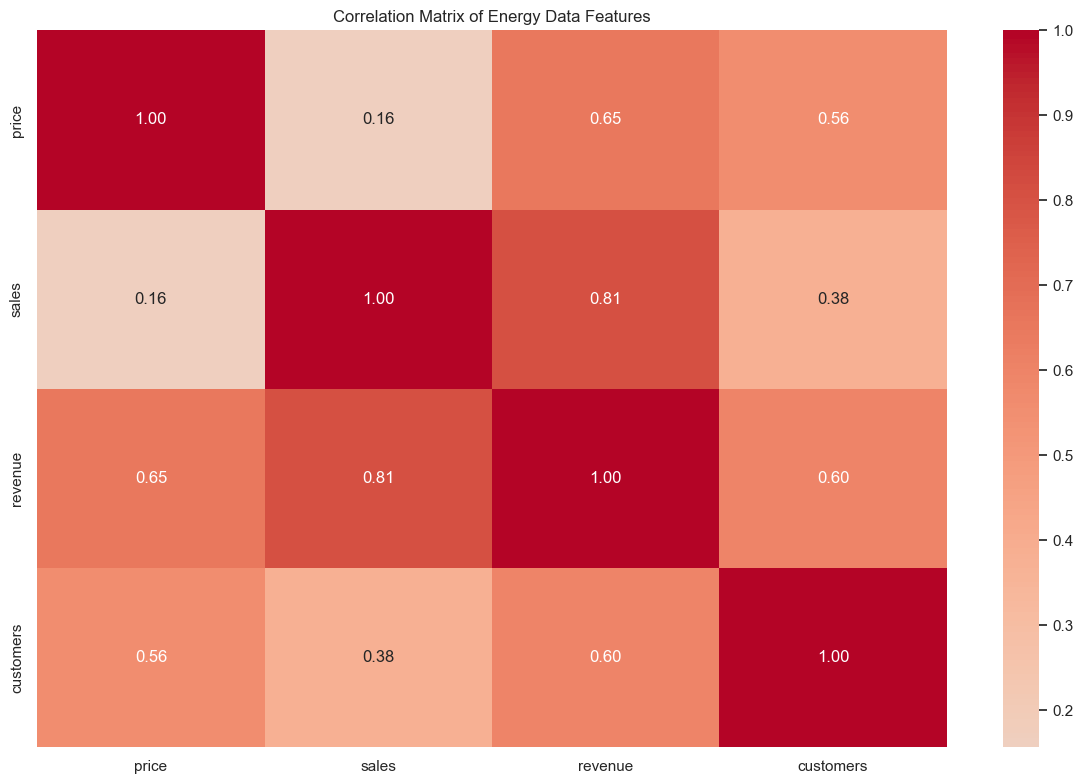


Correlation matrix shape: (4, 4)

Correlation values range from -1 (perfect negative) to 1 (perfect positive)

Correlation Matrix:
              price     sales   revenue  customers
price      1.000000  0.156687  0.650093   0.557911
sales      0.156687  1.000000  0.811685   0.380398
revenue    0.650093  0.811685  1.000000   0.598900
customers  0.557911  0.380398  0.598900   1.000000


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# First, let's check what we have
print("Available columns:", list(energy_data.columns))
print("\nData types:")
print(energy_data.dtypes)

# Convert numeric columns to proper data types
numerical_cols = ['price', 'sales', 'revenue', 'customers']
for col in numerical_cols:
    if col in energy_data.columns:
        energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# Check for any missing values after conversion
print("\nMissing values after conversion:")
print(energy_data[numerical_cols].isnull().sum())

# Now create the correlation matrix
correlation_matrix = energy_data[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Energy Data Features')
plt.tight_layout()
plt.show()

# Print summary
print(f"\nCorrelation matrix shape: {correlation_matrix.shape}")
print("\nCorrelation values range from -1 (perfect negative) to 1 (perfect positive)")
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Create figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# First, let's check what columns we actually have
print("Available columns:", list(energy_data.columns))
print("\nData types:")
print(energy_data.dtypes)

# Convert numeric columns to proper data types
numerical_cols = ['price', 'sales', 'revenue', 'customers']
for col in numerical_cols:
    if col in energy_data.columns:
        energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# 1. Correlation Matrix (Fixed)
correlation_matrix = energy_data[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Energy Data Features')
plt.tight_layout()
plt.savefig('figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Seasonal Patterns (Fixed - using month instead of season)
# Create month column from period
energy_data['month'] = pd.to_datetime(energy_data['period']).dt.month
energy_data['season'] = pd.cut(energy_data['month'], 
                              bins=[0, 3, 6, 9, 12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'])

# Calculate average sales by season
seasonal_sales = energy_data.groupby('season')['sales'].mean()

plt.figure(figsize=(10, 6))
seasonal_sales.plot(kind='bar')
plt.title('Average Energy Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Sales (million kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Feature Importance (Fixed - using correlation with sales as importance)
# Calculate correlation with sales as a proxy for feature importance
sales_correlations = energy_data[numerical_cols].corr()['sales'].abs().drop('sales')
importance_df = pd.DataFrame({
    'feature': sales_correlations.index,
    'importance': sales_correlations.values
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Feature Importance (Correlation with Sales)')
plt.xlabel('Absolute Correlation with Sales')
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Time Series Plot (Fixed - using period instead of date)
# Convert period to datetime for plotting
energy_data['date'] = pd.to_datetime(energy_data['period'])

# Group by date and calculate averages
time_series_data = energy_data.groupby('date')[['sales', 'price']].mean()

plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data['sales'], label='Sales', alpha=0.7)
plt.plot(time_series_data.index, time_series_data['price'], label='Price', alpha=0.7)
plt.title('Energy Sales and Price Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/time_series.png', dpi=300, bbox_inches='tight')
plt.close()

print("All visualizations saved successfully!")
print(f"Files saved in: {os.path.abspath('figures')}")

Available columns: ['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName', 'price', 'sales', 'revenue', 'customers', 'price-units', 'sales-units', 'revenue-units', 'customers-units', 'month']

Data types:
period               object
stateid              object
stateDescription     object
sectorid             object
sectorName           object
price               float64
sales               float64
revenue             float64
customers           float64
price-units          object
sales-units          object
revenue-units        object
customers-units      object
month                 int32
dtype: object


C:\Users\ethan\AppData\Local\Temp\ipykernel_23980\978619822.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seasonal_sales = energy_data.groupby('season')['sales'].mean()


All visualizations saved successfully!
Files saved in: c:\Users\ethan\Downloads\figures


# Feature Engineering
<a id="Feature Engineering"></a> 


Average usage per customer (May-Aug, price > 10.11): 7183.95 kWh
Average usage per customer (May-Aug, price <= 10.11): 147340.72 kWh


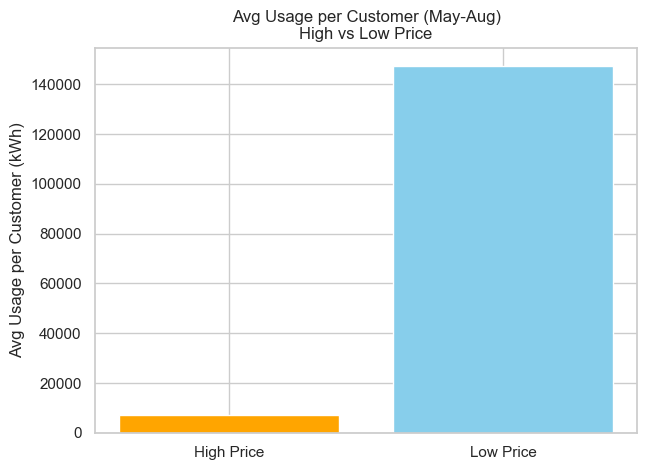

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure date and numeric columns are correct
energy_data['date'] = pd.to_datetime(energy_data['period'])
for col in ['price', 'sales', 'customers']:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# Filter for May to August
may_aug = energy_data[energy_data['date'].dt.month.isin([5, 6, 7, 8])].copy()

# Calculate per-customer usage
may_aug['usage_per_customer'] = may_aug['sales'] * 1_000_000 / may_aug['customers']

# Use median price as threshold
price_threshold = may_aug['price'].median()

# Split into high and low price groups
high_price = may_aug[may_aug['price'] > price_threshold]
low_price = may_aug[may_aug['price'] <= price_threshold]

# Calculate average usage per customer for each group
avg_usage_high = high_price['usage_per_customer'].mean()
avg_usage_low = low_price['usage_per_customer'].mean()

print(f"Average usage per customer (May-Aug, price > {price_threshold:.2f}): {avg_usage_high:.2f} kWh")
print(f"Average usage per customer (May-Aug, price <= {price_threshold:.2f}): {avg_usage_low:.2f} kWh")

# Visualize
plt.figure(figsize=(7,5))
plt.bar(['High Price', 'Low Price'], [avg_usage_high, avg_usage_low], color=['orange', 'skyblue'])
plt.ylabel('Avg Usage per Customer (kWh)')
plt.title('Avg Usage per Customer (May-Aug)\nHigh vs Low Price')
plt.show()

=== NEW ANALYSIS: High Price vs Non-Summer Months ===


Average usage per customer (High price periods - top 25%): 4732.52 kWh
Average usage per customer (Non-summer months): 65433.06 kWh
Difference: -60700.54 kWh
Percentage difference: -92.8%


C:\Users\ethan\AppData\Local\Temp\ipykernel_23980\1741603740.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=['High Price\n(Top 25%)', 'Non-Summer\nMonths'])


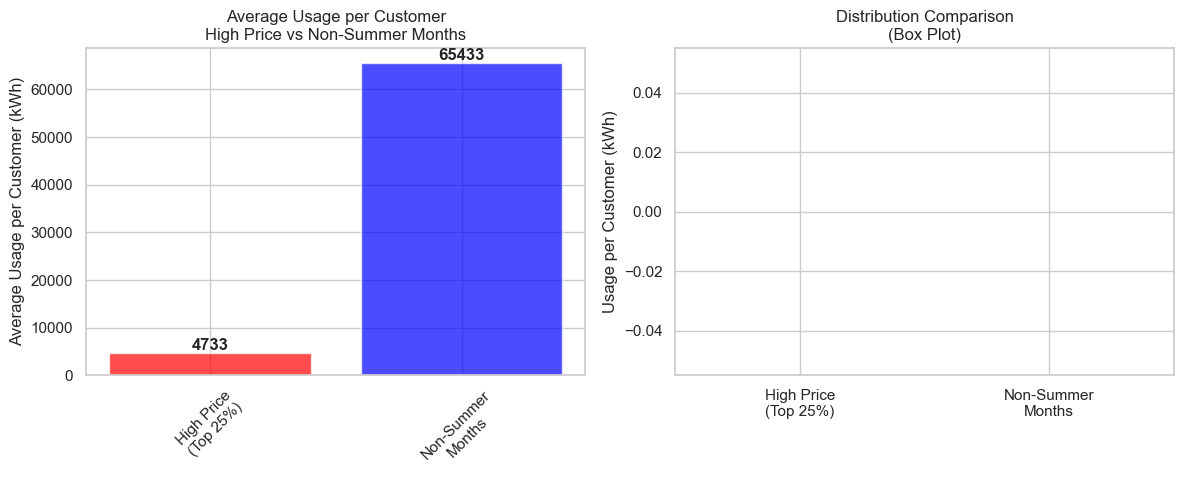


=== DETAILED STATISTICS ===
High Price Periods:
  - Number of observations: 1034
  - Price range: $13.39 - $31.78
  - Usage per customer - Mean: 4732.52 kWh
  - Usage per customer - Median: 938.88 kWh
  - Usage per customer - Std: 7427.78 kWh

Non-Summer Months:
  - Number of observations: 2760
  - Price range: $3.90 - $31.78
  - Usage per customer - Mean: 65433.06 kWh
  - Usage per customer - Median: 6098.84 kWh
  - Usage per customer - Std: 151586.41 kWh

=== STATISTICAL TEST ===
T-statistic: nan
P-value: nan
Statistically significant difference: No (α=0.05)


In [17]:
# New Analysis: Average Usage per Customer - High Price vs Non-Summer Months (No Price Threshold)
print("=== NEW ANALYSIS: High Price vs Non-Summer Months ===")

# Ensure date and numeric columns are correct (if not already done)
energy_data['date'] = pd.to_datetime(energy_data['period'])
for col in ['price', 'sales', 'customers']:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# Calculate per-customer usage for all data
energy_data['usage_per_customer'] = energy_data['sales'] * 1_000_000 / energy_data['customers']

# Define high price periods (top 25% of prices) and non-summer months (Jan, Feb, Mar, Apr, Sep, Oct, Nov, Dec)
high_price_data = energy_data[energy_data['price'] > energy_data['price'].quantile(0.75)]
non_summer_data = energy_data[energy_data['date'].dt.month.isin([1, 2, 3, 4, 9, 10, 11, 12])]

# Calculate average usage per customer for each group
avg_usage_high_price = high_price_data['usage_per_customer'].mean()
avg_usage_non_summer = non_summer_data['usage_per_customer'].mean()

print(f"Average usage per customer (High price periods - top 25%): {avg_usage_high_price:.2f} kWh")
print(f"Average usage per customer (Non-summer months): {avg_usage_non_summer:.2f} kWh")
print(f"Difference: {avg_usage_high_price - avg_usage_non_summer:.2f} kWh")
print(f"Percentage difference: {((avg_usage_high_price - avg_usage_non_summer) / avg_usage_non_summer * 100):.1f}%")

# Visualize the comparison
plt.figure(figsize=(12, 5))

# Create subplot for bar chart
plt.subplot(1, 2, 1)
categories = ['High Price\n(Top 25%)', 'Non-Summer\nMonths']
values = [avg_usage_high_price, avg_usage_non_summer]
colors = ['red', 'blue']
bars = plt.bar(categories, values, color=colors, alpha=0.7)
plt.ylabel('Average Usage per Customer (kWh)')
plt.title('Average Usage per Customer\nHigh Price vs Non-Summer Months')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

# Create subplot for box plot comparison
plt.subplot(1, 2, 2)
data_to_plot = [high_price_data['usage_per_customer'], non_summer_data['usage_per_customer']]
plt.boxplot(data_to_plot, labels=['High Price\n(Top 25%)', 'Non-Summer\nMonths'])
plt.ylabel('Usage per Customer (kWh)')
plt.title('Distribution Comparison\n(Box Plot)')

plt.tight_layout()
plt.show()

# Additional statistics
print(f"\n=== DETAILED STATISTICS ===")
print(f"High Price Periods:")
print(f"  - Number of observations: {len(high_price_data)}")
print(f"  - Price range: ${high_price_data['price'].min():.2f} - ${high_price_data['price'].max():.2f}")
print(f"  - Usage per customer - Mean: {high_price_data['usage_per_customer'].mean():.2f} kWh")
print(f"  - Usage per customer - Median: {high_price_data['usage_per_customer'].median():.2f} kWh")
print(f"  - Usage per customer - Std: {high_price_data['usage_per_customer'].std():.2f} kWh")

print(f"\nNon-Summer Months:")
print(f"  - Number of observations: {len(non_summer_data)}")
print(f"  - Price range: ${non_summer_data['price'].min():.2f} - ${non_summer_data['price'].max():.2f}")
print(f"  - Usage per customer - Mean: {non_summer_data['usage_per_customer'].mean():.2f} kWh")
print(f"  - Usage per customer - Median: {non_summer_data['usage_per_customer'].median():.2f} kWh")
print(f"  - Usage per customer - Std: {non_summer_data['usage_per_customer'].std():.2f} kWh")

# Statistical significance test (t-test)
from scipy import stats
t_stat, p_value = stats.ttest_ind(high_price_data['usage_per_customer'], 
                                 non_summer_data['usage_per_customer'])
print(f"\n=== STATISTICAL TEST ===")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Statistically significant difference: {'Yes' if p_value < 0.05 else 'No'} (α=0.05)")

In [18]:
# Data Preparation
print("Preparing features...")

# 1. Rename usage_per_customer to avg_consumption
energy_data['avg_consumption'] = energy_data['usage_per_customer']

# 2. Calculate revenue per customer
energy_data['revenue_per_customer'] = energy_data['revenue'] / energy_data['customers']

# 3. Calculate year-over-year consumption growth
energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12) * 100

# 4. Calculate customer growth
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change() * 100

# 5. Calculate price elasticity (simplified version)
# Price elasticity = % change in consumption / % change in price
price_pct_change = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
consumption_pct_change = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = (consumption_pct_change / price_pct_change).replace([np.inf, -np.inf], np.nan)

# 6. Create cyclical month features
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)

# 7. Define peak season (assuming summer months 6-9 are peak season)
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8, 9]).astype(int)

# Check for any NaN values in the features we'll use
required_features = ['price', 'avg_consumption', 'revenue_per_customer', 
                    'consumption_yoy', 'customer_growth', 'price_elasticity',
                    'month_sin', 'month_cos', 'is_peak_season']

print("\nChecking for NaN values in features:")
for feature in required_features:
    nan_count = energy_data[feature].isna().sum()
    print(f"{feature}: {nan_count} NaN values")

# Handle NaN values
print("\nHandling NaN values...")
# For time series features, forward fill then backward fill
time_series_features = ['consumption_yoy', 'customer_growth', 'price_elasticity']
energy_data[time_series_features] = energy_data.groupby(['stateid', 'sectorid'])[time_series_features].fillna(method='ffill')
energy_data[time_series_features] = energy_data.groupby(['stateid', 'sectorid'])[time_series_features].fillna(method='bfill')

# Verify data preparation
print("\nFinal data shape:", energy_data.shape)
print("\nFeatures ready for LSTM model:", required_features)

# Now you can proceed with the LSTM code using these features...

Preparing features...

Checking for NaN values in features:
price: 0 NaN values
avg_consumption: 1260 NaN values
revenue_per_customer: 1260 NaN values
consumption_yoy: 180 NaN values
customer_growth: 15 NaN values
price_elasticity: 32 NaN values
month_sin: 0 NaN values
month_cos: 0 NaN values
is_peak_season: 0 NaN values

Handling NaN values...

Final data shape: (4140, 25)

Features ready for LSTM model: ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy', 'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_peak_season']


C:\Users\ethan\AppData\Local\Temp\ipykernel_23980\2676350666.py:11: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12) * 100
C:\Users\ethan\AppData\Local\Temp\ipykernel_23980\2676350666.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change() * 100
C:\Users\ethan\AppData\Local\Temp\ipykernel_23980\2676350666.py:19: FutureWarning: The default fill_method='ffill' in Se

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# First, let's check our data structure
print("=== Data Inspection ===")
print("Columns in energy_data:", list(energy_data.columns))
print("\nData types:")
print(energy_data.dtypes)

# Define the features we want to create/use
target_features = ['price', 'sales', 'revenue_per_customer', 
                  'sales_yoy', 'customer_growth', 'price_elasticity',
                  'month_sin', 'month_cos', 'is_peak_season']

# Check which features we need to create
existing_features = [col for col in target_features if col in energy_data.columns]
features_to_create = [col for col in target_features if col not in energy_data.columns]

print("\nExisting features:", existing_features)
print("Features to create:", features_to_create)

# Create necessary features
print("\n=== Feature Engineering ===")

# 1. Calculate revenue per customer if needed
if 'revenue_per_customer' in features_to_create:
    energy_data['revenue_per_customer'] = energy_data['revenue'] / energy_data['customers']
    print("Created: revenue_per_customer")

# 2. Calculate customer growth if needed
if 'customer_growth' in features_to_create:
    energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change() * 100
    energy_data['customer_growth'] = energy_data['customer_growth'].clip(-50, 50)  # Cap at ±50%
    print("Created: customer_growth")

# 3. Calculate sales year-over-year growth if needed
if 'sales_yoy' in features_to_create:
    energy_data['sales_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['sales'].pct_change(periods=12) * 100
    energy_data['sales_yoy'] = energy_data['sales_yoy'].clip(-100, 100)  # Cap at ±100%
    print("Created: sales_yoy")

# 4. Calculate price elasticity if needed
if 'price_elasticity' in features_to_create:
    price_pct_change = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
    sales_pct_change = energy_data.groupby(['stateid', 'sectorid'])['sales'].pct_change()
    energy_data['price_elasticity'] = (sales_pct_change / (price_pct_change + 1e-10))  # Avoid division by zero
    energy_data['price_elasticity'] = energy_data['price_elasticity'].clip(-10, 10)  # Cap at ±10
    print("Created: price_elasticity")

# 5. Create cyclical month features if needed
if 'month_sin' in features_to_create:
    energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
    print("Created: month_sin")
if 'month_cos' in features_to_create:
    energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)
    print("Created: month_cos")

# 6. Define peak season if needed
if 'is_peak_season' in features_to_create:
    energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8, 9]).astype(int)
    print("Created: is_peak_season")

# Check for any missing values in our features
print("\n=== Data Quality Check ===")
print("Missing values in features:")
for feature in target_features:
    if feature in energy_data.columns:
        missing = energy_data[feature].isnull().sum()
        print(f"{feature}: {missing} missing values")

# Handle missing values
print("\nHandling missing values...")
for feature in target_features:
    if feature in energy_data.columns:
        if feature in ['customer_growth', 'price_elasticity', 'sales_yoy']:
            # Forward fill then backward fill for time series features
            energy_data[feature] = energy_data.groupby(['stateid', 'sectorid'])[feature].fillna(method='ffill')
            energy_data[feature] = energy_data.groupby(['stateid', 'sectorid'])[feature].fillna(method='bfill')
        # Fill any remaining NaNs with 0
        energy_data[feature] = energy_data[feature].fillna(0)

# Check for infinite values
print("\nChecking for infinite values:")
for feature in target_features:
    if feature in energy_data.columns:
        inf_count = np.isinf(energy_data[feature]).sum()
        print(f"{feature}: {inf_count} infinite values")

# Final verification
print("\n=== Final Data Verification ===")
print("Final feature statistics:")
print(energy_data[target_features].describe())

# Now proceed with LSTM preparation if all looks good
if all(feature in energy_data.columns for feature in target_features):
    print("\n=== Ready for LSTM Analysis ===")
    print("All required features are present and cleaned")
else:
    missing_features = [f for f in target_features if f not in energy_data.columns]
    print("\nError: Still missing some features:", missing_features)

=== Data Inspection ===
Columns in energy_data: ['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName', 'price', 'sales', 'revenue', 'customers', 'price-units', 'sales-units', 'revenue-units', 'customers-units', 'month', 'season', 'date', 'usage_per_customer', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy', 'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_peak_season']

Data types:
period                          object
stateid                         object
stateDescription                object
sectorid                        object
sectorName                      object
price                          float64
sales                          float64
revenue                        float64
customers                      float64
price-units                     object
sales-units                     object
revenue-units                   object
customers-units                 object
month                            int32
season                 

In [20]:
import numpy as np
import pandas as pd

# Ensure numeric types
for col in ['sales', 'revenue', 'customers', 'price']:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# 1. Average consumption per customer (kWh)
energy_data['avg_consumption'] = energy_data['sales'] * 1_000_000 / energy_data['customers']

# 2. Revenue per customer (dollars)
energy_data['revenue_per_customer'] = energy_data['revenue'] * 1_000_000 / energy_data['customers']

# 3. Year-over-year consumption growth (per state/sector)
energy_data = energy_data.sort_values(['stateid', 'sectorid', 'date'])
energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12)

# 4. Year-over-year customer growth (per state/sector)
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change(periods=12)

# 5. Price elasticity (consumption change / price change, per state/sector)
energy_data['price_change'] = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
energy_data['consumption_change'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = energy_data['consumption_change'] / energy_data['price_change']

# 6. Month sine/cosine for seasonality
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month'] / 12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month'] / 12)

# 7. Peak season indicator (June, July, August)
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8]).astype(int)

print("All missing columns have been created!")

All missing columns have been created!


In [21]:
energy_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
model_features = [
    'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
    'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_peak_season'
]
energy_data_clean = energy_data.dropna(subset=model_features)

In [23]:
numeric_cols = energy_data_clean.select_dtypes(include=[np.number])
print("Any inf in numeric data?", np.isinf(numeric_cols).any().any())
print("Any NaN in numeric data?", numeric_cols.isnull().any().any())

Any inf in numeric data? False
Any NaN in numeric data? False


In [24]:
# Data preparation and feature engineering
import pandas as pd
import numpy as np
from datetime import datetime

# Convert period to datetime if not already done
energy_data['date'] = pd.to_datetime(energy_data['period'], format='%Y-%m')
energy_data['month'] = energy_data['date'].dt.month
energy_data['year'] = energy_data['date'].dt.year

# Create seasonal indicators
energy_data['season'] = pd.cut(energy_data['month'], 
                              bins=[0,3,6,9,12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'],
                              include_lowest=True)

# Create cyclical month features
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)

# Customer-Related Features
energy_data['revenue_per_customer'] = energy_data['revenue'] * 1_000_000 / energy_data['customers']
energy_data['avg_consumption'] = energy_data['sales'] * 1_000_000 / energy_data['customers']

# Calculate year-over-year growth rates
energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12)
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change(periods=12)

# Price elasticity features
energy_data['price_change'] = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
energy_data['consumption_change'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = energy_data['consumption_change'] / energy_data['price_change']

# Peak season indicator
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8]).astype(int)

print("Data preparation completed successfully!")


Data preparation completed successfully!


In [25]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Create figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# First, prepare and clean the features
features = ['price', 'is_peak_season', 'month_sin', 'month_cos', 
           'customer_growth', 'price_elasticity']

# Clean and prepare the data
print("Cleaning and preparing data...")

# Handle customer growth - cap at reasonable values
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change() * 100
energy_data['customer_growth'] = energy_data['customer_growth'].clip(-50, 50)  # Cap at ±50%

# Calculate price elasticity with safeguards
price_pct_change = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
consumption_pct_change = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = (consumption_pct_change / (price_pct_change + 1e-10))  # Avoid division by zero
energy_data['price_elasticity'] = energy_data['price_elasticity'].clip(-10, 10)  # Cap at ±10

# Create cyclical month features
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)

# Define peak season
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8, 9]).astype(int)

# Handle missing values
for feature in features:
    if feature in ['customer_growth', 'price_elasticity']:
        # Forward fill then backward fill for time series features
        energy_data[feature] = energy_data.groupby(['stateid', 'sectorid'])[feature].fillna(method='ffill')
        energy_data[feature] = energy_data.groupby(['stateid', 'sectorid'])[feature].fillna(method='bfill')
    # Fill any remaining NaNs with 0
    energy_data[feature] = energy_data[feature].fillna(0)

# Verify data is clean before scaling
print("\nChecking for issues in features:")
for feature in features:
    print(f"{feature}:")
    print(f"  NaN count: {energy_data[feature].isna().sum()}")
    print(f"  Inf count: {np.isinf(energy_data[feature]).sum()}")
    print(f"  Min: {energy_data[feature].min()}")
    print(f"  Max: {energy_data[feature].max()}")

# Scale features
print("\nScaling features...")
scaler = StandardScaler()
X = scaler.fit_transform(energy_data[features])
y = energy_data['avg_consumption']

# Train Random Forest
print("\nTraining Random Forest model...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create importance DataFrame
importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
importance = importance.sort_values('importance', ascending=True)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.title('Feature Importance in Energy Consumption Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and plot correlation matrix
numerical_features = ['avg_consumption'] + features
correlation_matrix = energy_data[numerical_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.savefig('figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# Seasonal Patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='avg_consumption', data=energy_data)
plt.title('Consumption by Season')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(energy_data['date'], energy_data['avg_consumption'], label='Consumption')
plt.plot(energy_data['date'], energy_data['price'], label='Price')
plt.title('Consumption and Price Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/time_series.png', dpi=300, bbox_inches='tight')
plt.close()

print("\nAll figures have been saved in the 'figures' directory!")
# List all generated files
print("\nGenerated files:")
for file in os.listdir('figures'):
    print(f"- {file}")

Cleaning and preparing data...

Checking for issues in features:
price:
  NaN count: 0
  Inf count: 0
  Min: 3.9
  Max: 31.78
is_peak_season:
  NaN count: 0
  Inf count: 0
  Min: 0
  Max: 1
month_sin:
  NaN count: 0
  Inf count: 0
  Min: -1.0
  Max: 1.0
month_cos:
  NaN count: 0
  Inf count: 0
  Min: -1.0
  Max: 1.0
customer_growth:
  NaN count: 0
  Inf count: 0
  Min: -23.502033792240297
  Max: 50.0
price_elasticity:
  NaN count: 0
  Inf count: 0
  Min: -10.0
  Max: 10.0

Scaling features...

Training Random Forest model...


ValueError: Input y contains NaN.

# Time Series Analysis 
<a id="Times Series Analysis"></a> 

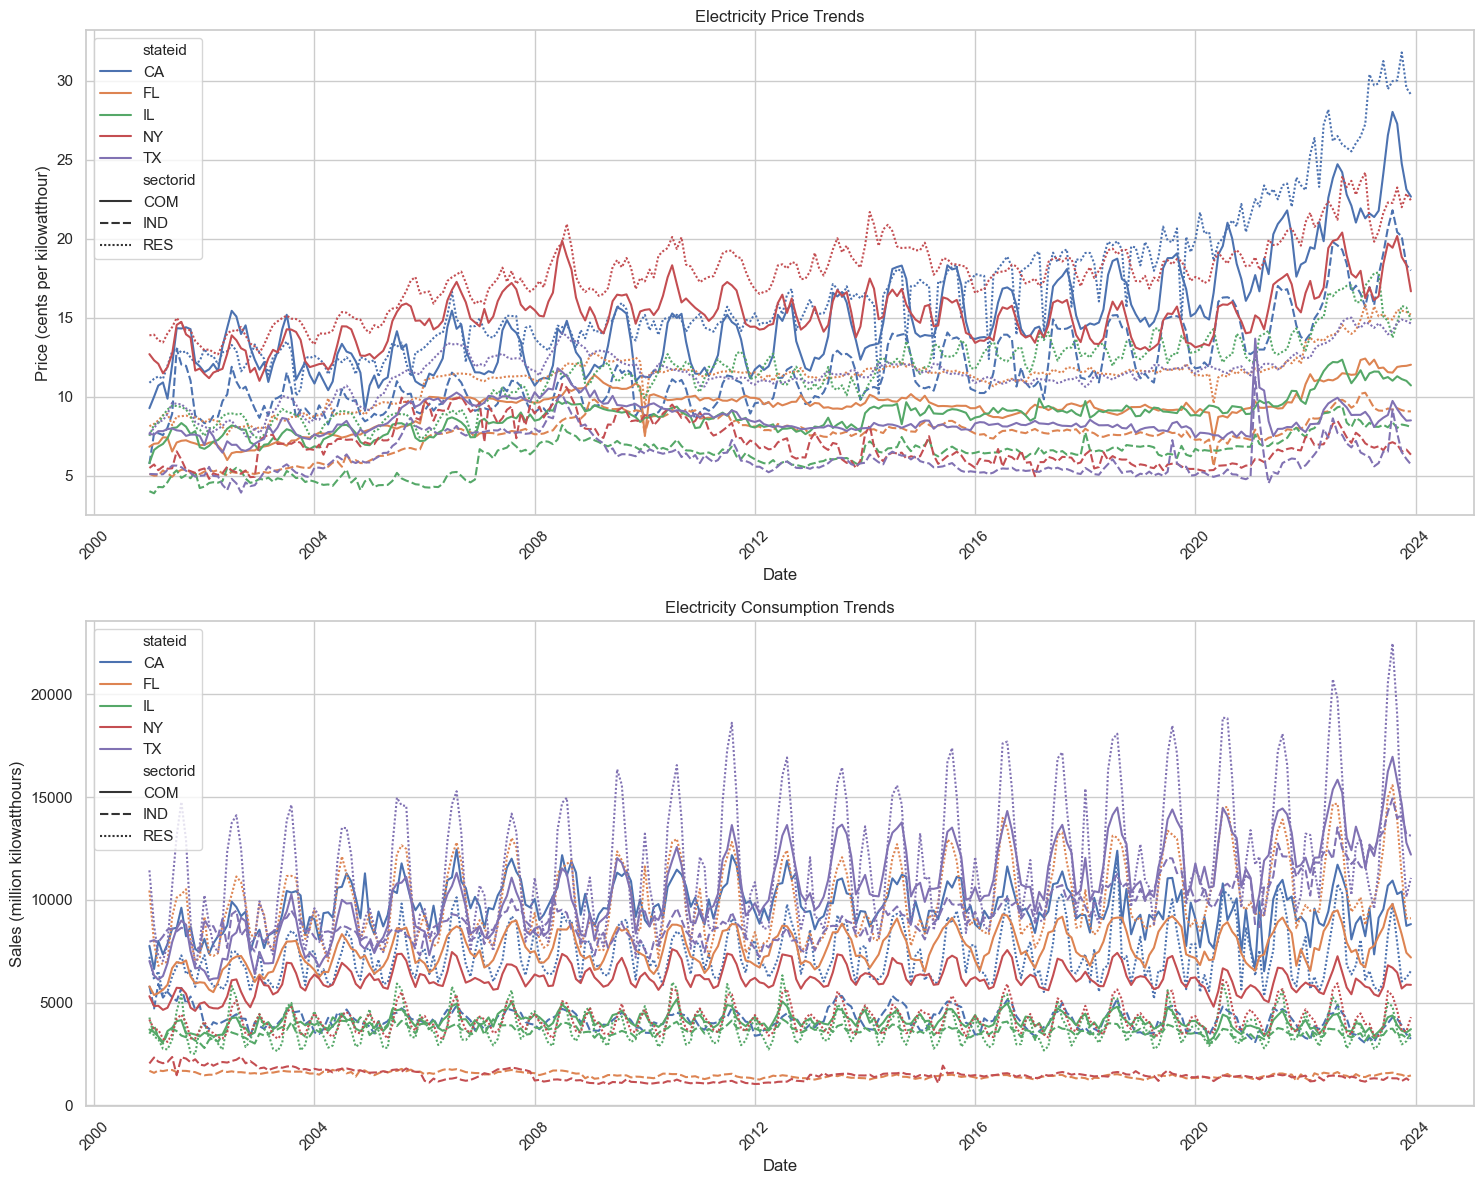


Year-over-Year Changes in Price and Consumption:
---------------------------------------------


price    sales
year stateid sectorid                
2001 CA      COM       12.02  8038.28
             IND        9.26  5253.44
             RES       12.07  6388.97
     FL      COM        7.09  6163.14
             IND        5.18  1654.52
             RES        8.60  8448.09
     IL      COM        7.38  3594.62
             IND        4.65  3398.33
             RES        8.69  3485.00
     NY      COM       12.80  5067.18

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure period is datetime
energy_data['period'] = pd.to_datetime(energy_data['period'])

# Add month and year columns for seasonal analysis
energy_data['month'] = energy_data['period'].dt.month
energy_data['year'] = energy_data['period'].dt.year

# Ensure numeric types
for col in ['price', 'sales']:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# Create time series plots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Price trends over time
sns.lineplot(
    data=energy_data,
    x='period',
    y='price',
    hue='stateid',
    style='sectorid',
    ax=axes[0]
)
axes[0].set_title('Electricity Price Trends')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price (cents per kilowatthour)')
axes[0].tick_params(axis='x', rotation=45)

# Consumption trends over time
sns.lineplot(
    data=energy_data,
    x='period',
    y='sales',
    hue='stateid',
    style='sectorid',
    ax=axes[1]
)
axes[1].set_title('Electricity Consumption Trends')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales (million kilowatthours)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate and display year-over-year changes
print("\nYear-over-Year Changes in Price and Consumption:")
print("---------------------------------------------")
yearly_stats = energy_data.groupby(['year', 'stateid', 'sectorid'])[['price', 'sales']].mean().round(2)

# Use display if in Jupyter, otherwise print
try:
    display(yearly_stats.head(10))
except NameError:
    print(yearly_stats.head(10))

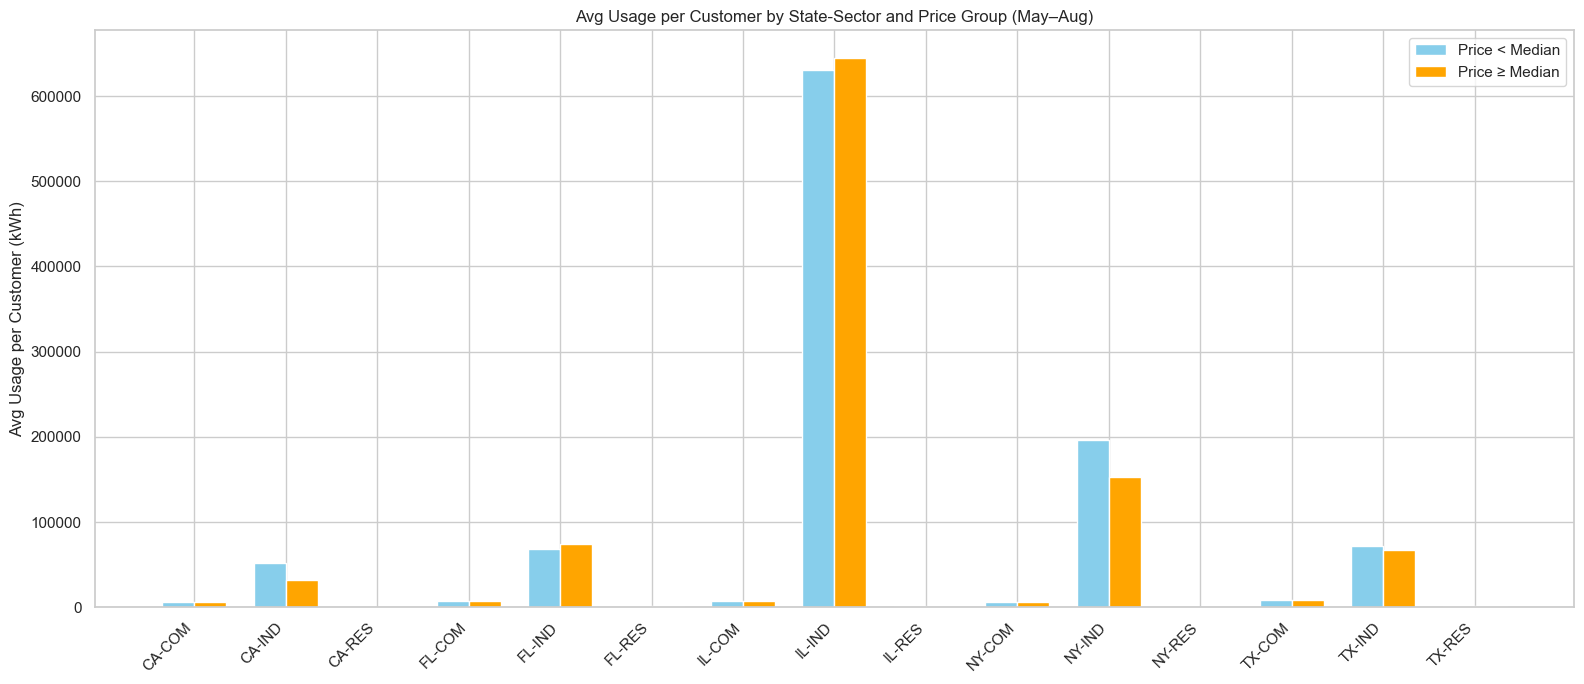

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Filter to May–August
summer = energy_data[energy_data['month'].isin([5, 6, 7, 8])].copy()

states = summer['stateid'].unique()
sectors = summer['sectorid'].unique()

labels = []
means_below = []
means_above = []

for state in states:
    for sector in sectors:
        subset = summer[(summer['stateid'] == state) & (summer['sectorid'] == sector)].copy()
        if subset.empty:
            continue
        # Calculate per-customer usage
        subset['usage_per_customer'] = subset['sales'] * 1_000_000 / subset['customers']
        # Median price for this state+sector (in summer)
        price_median = subset['price'].median()
        # Split
        below = subset[subset['price'] < price_median]
        above = subset[subset['price'] >= price_median]
        # Calculate means
        mean_below = below['usage_per_customer'].mean()
        mean_above = above['usage_per_customer'].mean()
        # Store results
        labels.append(f"{state}-{sector}")
        means_below.append(mean_below)
        means_above.append(mean_above)

# Plot grouped bar chart
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(x - width/2, means_below, width, label='Price < Median', color='skyblue')
plt.bar(x + width/2, means_above, width, label='Price ≥ Median', color='orange')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Avg Usage per Customer (kWh)')
plt.title('Avg Usage per Customer by State-Sector and Price Group (May–Aug)')
plt.legend()
plt.tight_layout()
plt.show()

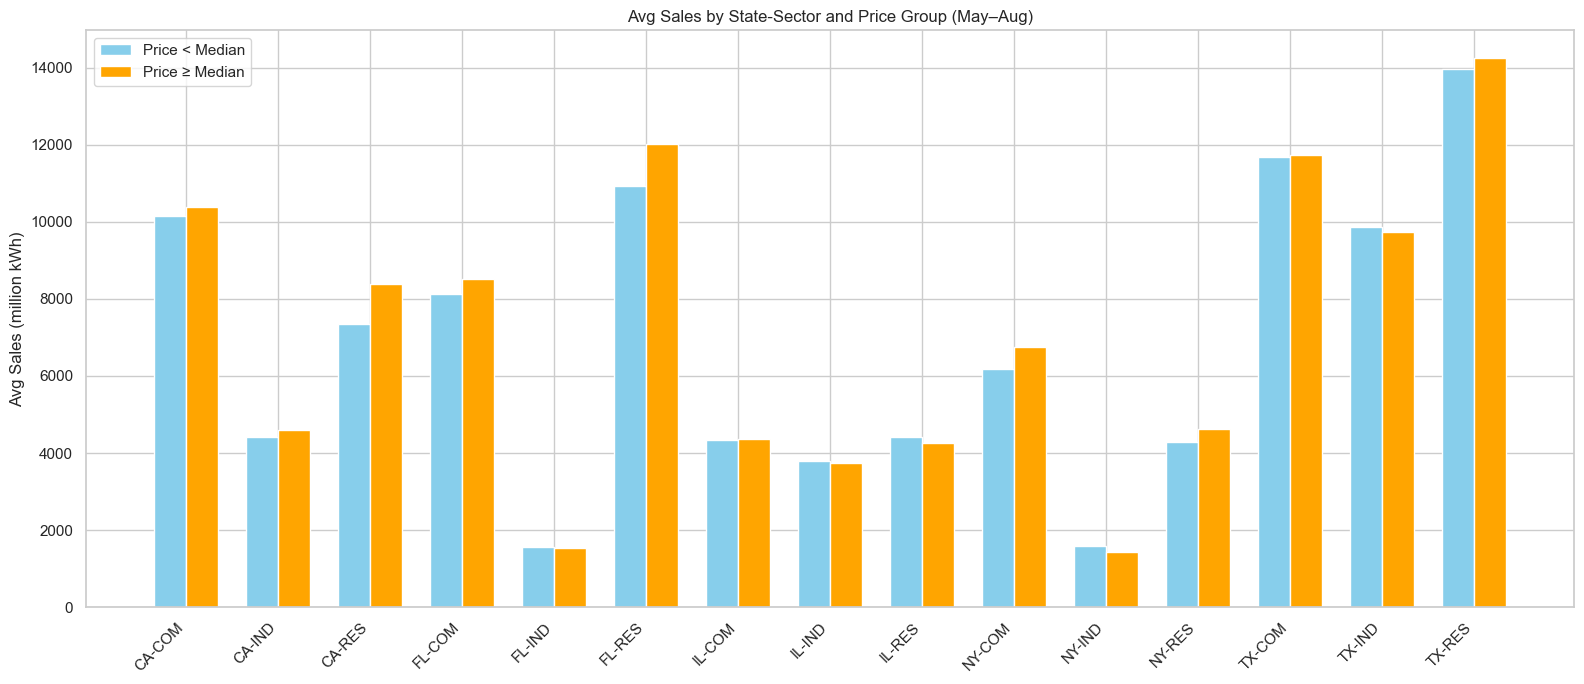

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Filter to May–August
summer = energy_data[energy_data['month'].isin([5, 6, 7, 8])].copy()

states = summer['stateid'].unique()
sectors = summer['sectorid'].unique()

labels = []
means_below = []
means_above = []

for state in states:
    for sector in sectors:
        subset = summer[(summer['stateid'] == state) & (summer['sectorid'] == sector)].copy()
        if subset.empty:
            continue
        # Median price for this state+sector (in summer)
        price_median = subset['price'].median()
        # Split
        below = subset[subset['price'] < price_median]
        above = subset[subset['price'] >= price_median]
        # Calculate means (now just sales, not per-customer)
        mean_below = below['sales'].mean()
        mean_above = above['sales'].mean()
        # Store results
        labels.append(f"{state}-{sector}")
        means_below.append(mean_below)
        means_above.append(mean_above)

# Plot grouped bar chart
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(16, 7))
plt.bar(x - width/2, means_below, width, label='Price < Median', color='skyblue')
plt.bar(x + width/2, means_above, width, label='Price ≥ Median', color='orange')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Avg Sales (million kWh)')
plt.title('Avg Sales by State-Sector and Price Group (May–Aug)')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Filter for IL-IND in May–August
il_ind = summer[(summer['stateid'] == 'IL') & (summer['sectorid'] == 'IND')]

print("Number of records for IL-IND (May–Aug):", len(il_ind))
print(il_ind[['period', 'sales', 'customers', 'usage_per_customer', 'price']])
print("Median price for IL-IND (May–Aug):", il_ind['price'].median())
print("Average customers for IL-IND (May–Aug):", il_ind['customers'].mean())
print("Average sales for IL-IND (May–Aug):", il_ind['sales'].mean())

Number of records for IL-IND (May–Aug): 92
         period       sales  customers  usage_per_customer  price
3938 2001-05-01  3500.06478        NaN                 NaN   4.60
3980 2001-06-01  3736.53195        NaN                 NaN   5.08
3987 2001-07-01  3618.44530        NaN                 NaN   5.35
4007 2001-08-01  3399.92734        NaN                 NaN   4.87
4047 2002-05-01  3435.78693        NaN                 NaN   4.68
4009 2002-06-01  3674.10432        NaN                 NaN   5.50
4054 2002-07-01  3548.15236        NaN                 NaN   5.28
4044 2002-08-01  3474.41047        NaN                 NaN   5.51
3939 2003-05-01  3700.84757        NaN                 NaN   4.85
3943 2003-06-01  3819.17623        NaN                 NaN   4.78
3936 2003-07-01  3673.39355        NaN                 NaN   5.31
3924 2003-08-01  4054.32134        NaN                 NaN   5.12
4051 2004-05-01  4287.44263        NaN                 NaN   4.37
3944 2004-06-01  4121.52510      

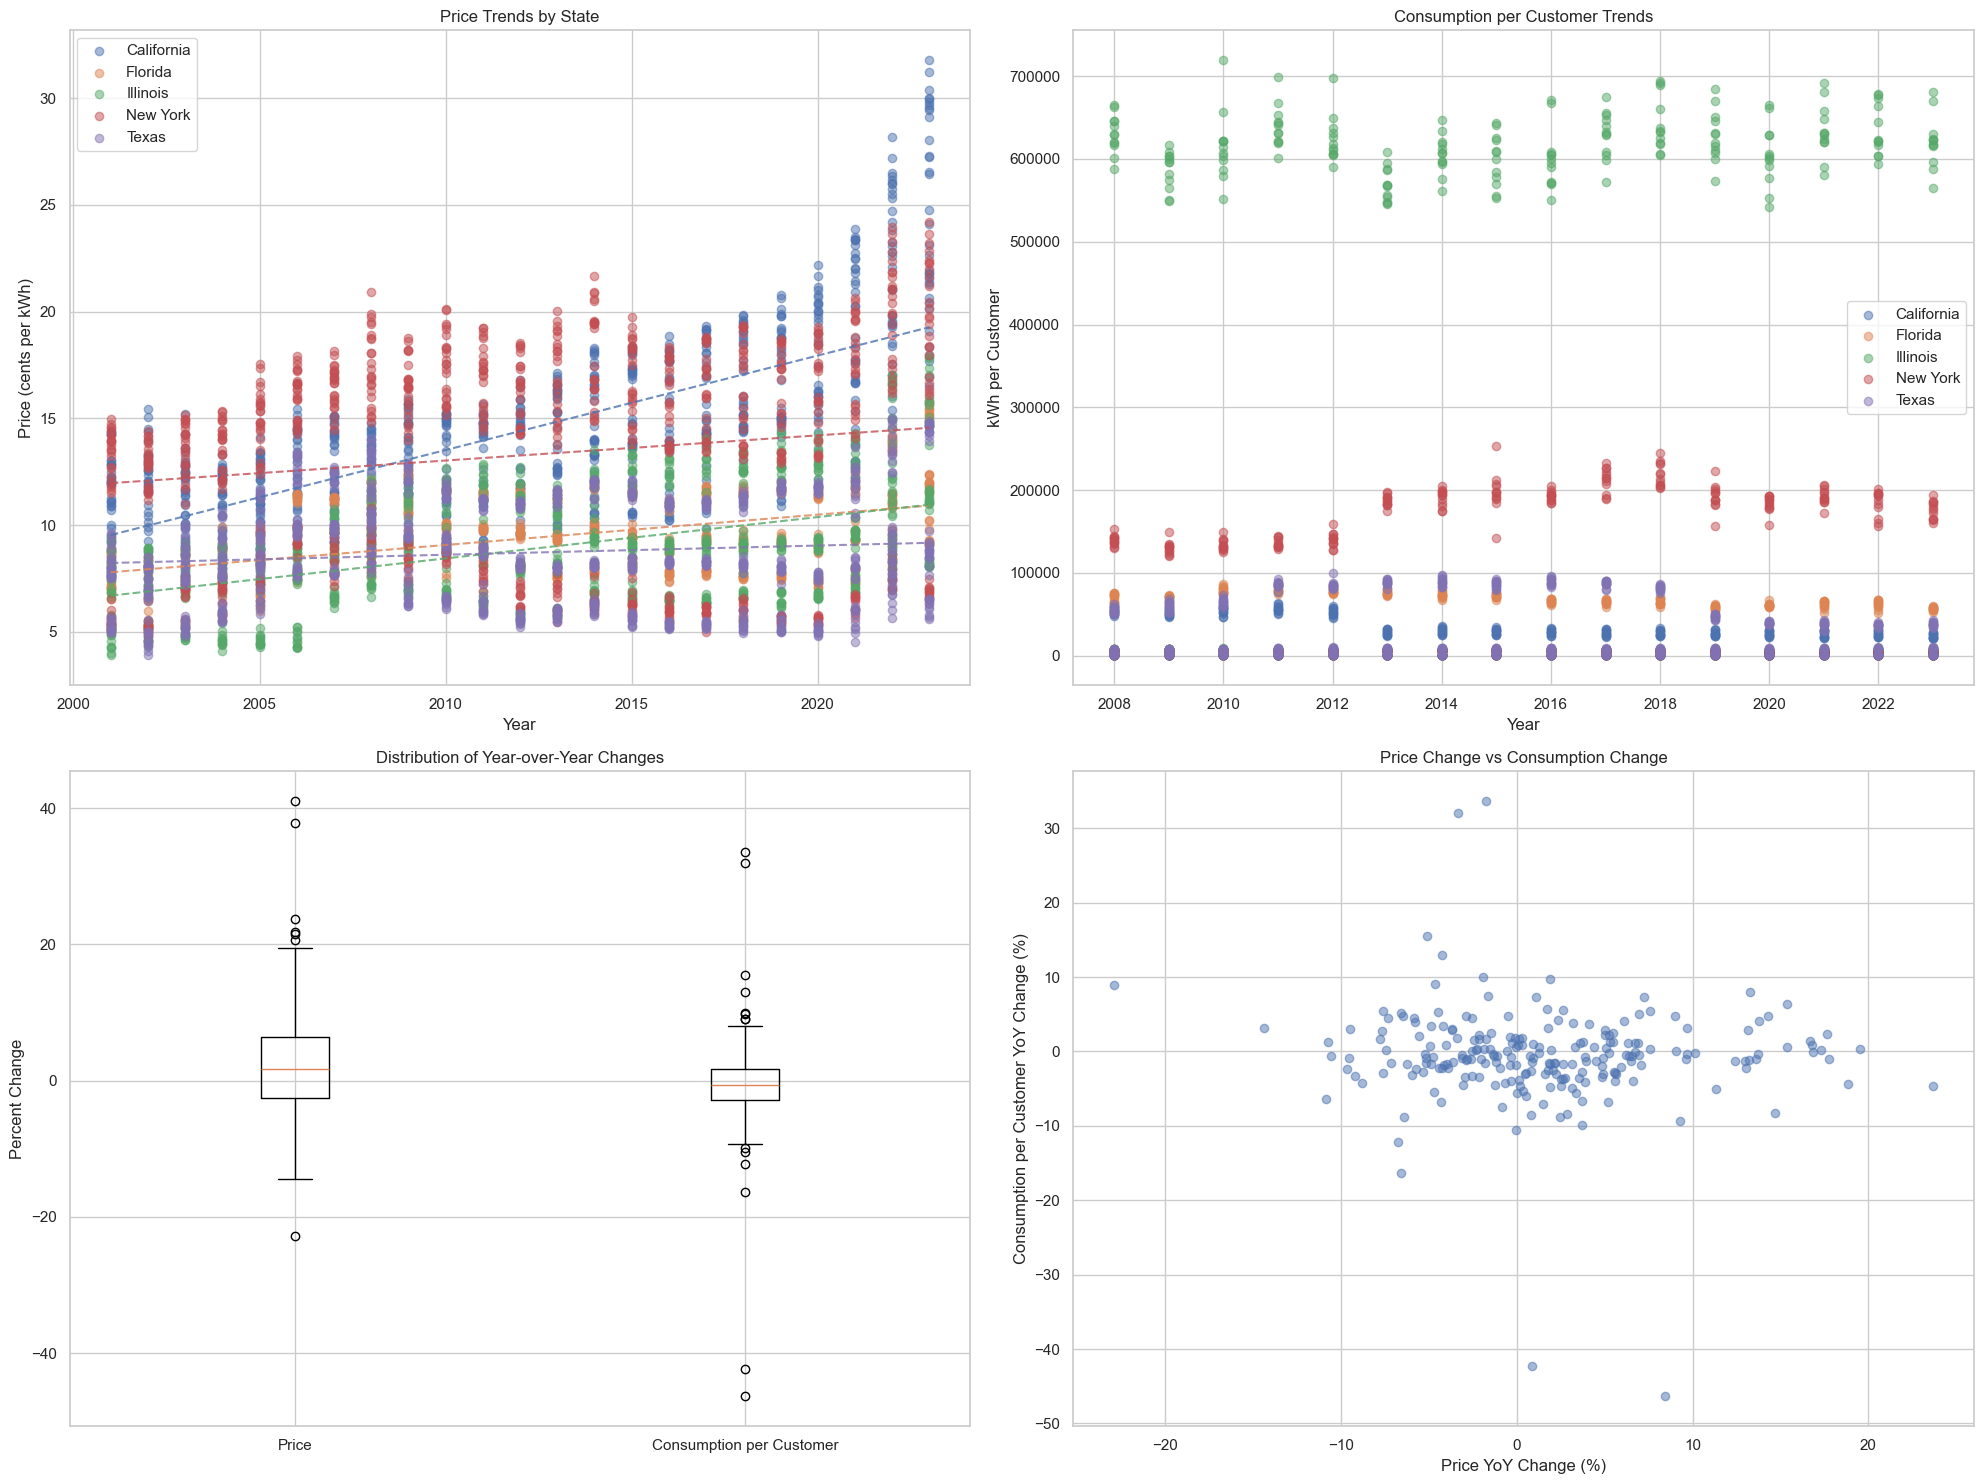


Summary of Year-over-Year Changes by State:
----------------------------------------


price_yoy_change       consumption_yoy_change      
                    mean   std                   mean   std
stateid                                                    
CA                  3.61  5.14                  -1.98  7.59
FL                  2.83  7.14                  -0.63  4.13
IL                  2.72  7.93                  -0.68  4.00
NY                  1.85  8.36                   0.12  6.47
TX                  1.66  8.72                   0.32  9.44


Summary of Year-over-Year Changes by Sector:
-----------------------------------------


price_yoy_change       consumption_yoy_change       
                     mean   std                   mean    std
sectorid                                                     
COM                  2.11  6.32                  -0.37   3.19
IND                  2.53  9.70                  -0.93  10.47
RES                  2.97  6.15                  -0.41   3.73


Correlation between Price and Consumption Changes:
----------------------------------------------
Correlation coefficient: -0.078

Simple Linear Regression Results by State:
---------------------------------------

California - Price Trend:
Slope: 0.4425 cents/kWh per year
R-squared: 0.4824
P-value: 0.0000

California - Consumption per Customer Trend:
Slope: nan kWh per year
R-squared: nan
P-value: nan

Florida - Price Trend:
Slope: 0.1420 cents/kWh per year
R-squared: 0.2167
P-value: 0.0000

Florida - Consumption per Customer Trend:
Slope: nan kWh per year
R-squared: nan
P-value: nan

Illinois - Price Trend:
Slope: 0.1936 cents/kWh per year
R-squared: 0.2345
P-value: 0.0000

Illinois - Consumption per Customer Trend:
Slope: nan kWh per year
R-squared: nan
P-value: nan

New York - Price Trend:
Slope: 0.1178 cents/kWh per year
R-squared: 0.0253
P-value: 0.0000

New York - Consumption per Customer Trend:
Slope: nan kWh per year
R-squared: nan
P-value: nan

Texas - Price Trend:
Slope: 0.

In [30]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate per-customer metrics
energy_data['sales_per_customer'] = energy_data['sales'] * 1_000_000 / energy_data['customers']  # Convert to kWh per customer
energy_data['year_num'] = energy_data['year'] - energy_data['year'].min()  # Year as numeric for regression

# Create figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Price trends by state and sector
for state in energy_data['stateDescription'].unique():
    state_data = energy_data[energy_data['stateDescription'] == state]
    axes[0,0].scatter(state_data['year'], state_data['price'], alpha=0.5, label=state)
    
    # Simple linear regression for each state
    slope, intercept, r_value, p_value, std_err = stats.linregress(state_data['year_num'], state_data['price'])
    line = slope * state_data['year_num'] + intercept
    axes[0,0].plot(state_data['year'], line, '--', alpha=0.8)

axes[0,0].set_title('Price Trends by State')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Price (cents per kWh)')
axes[0,0].legend()

# 2. Consumption per customer trends
for state in energy_data['stateDescription'].unique():
    state_data = energy_data[energy_data['stateDescription'] == state]
    axes[0,1].scatter(state_data['year'], state_data['sales_per_customer'], alpha=0.5, label=state)
    
    # Simple linear regression for each state
    slope, intercept, r_value, p_value, std_err = stats.linregress(state_data['year_num'], state_data['sales_per_customer'])
    line = slope * state_data['year_num'] + intercept
    axes[0,1].plot(state_data['year'], line, '--', alpha=0.8)

axes[0,1].set_title('Consumption per Customer Trends')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('kWh per Customer')
axes[0,1].legend()

# Calculate year-over-year changes
yearly_metrics = energy_data.groupby(['year', 'stateid', 'sectorid']).agg({
    'price': 'mean',
    'sales_per_customer': 'mean'
}).reset_index()

yearly_metrics['price_yoy_change'] = yearly_metrics.groupby(['stateid', 'sectorid'])['price'].pct_change() * 100
yearly_metrics['consumption_yoy_change'] = yearly_metrics.groupby(['stateid', 'sectorid'])['sales_per_customer'].pct_change() * 100

# 3. Box plot of YoY changes
axes[1,0].boxplot([yearly_metrics['price_yoy_change'].dropna(), 
                   yearly_metrics['consumption_yoy_change'].dropna()],
                  labels=['Price', 'Consumption per Customer'])
axes[1,0].set_title('Distribution of Year-over-Year Changes')
axes[1,0].set_ylabel('Percent Change')

# 4. Scatter plot of price vs consumption changes
axes[1,1].scatter(yearly_metrics['price_yoy_change'], 
                  yearly_metrics['consumption_yoy_change'],
                  alpha=0.5)
axes[1,1].set_title('Price Change vs Consumption Change')
axes[1,1].set_xlabel('Price YoY Change (%)')
axes[1,1].set_ylabel('Consumption per Customer YoY Change (%)')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of Year-over-Year Changes by State:")
print("----------------------------------------")
summary_stats = yearly_metrics.groupby('stateid').agg({
    'price_yoy_change': ['mean', 'std'],
    'consumption_yoy_change': ['mean', 'std']
}).round(2)
display(summary_stats)

print("\nSummary of Year-over-Year Changes by Sector:")
print("-----------------------------------------")
sector_stats = yearly_metrics.groupby('sectorid').agg({
    'price_yoy_change': ['mean', 'std'],
    'consumption_yoy_change': ['mean', 'std']
}).round(2)
display(sector_stats)

# Calculate correlations
print("\nCorrelation between Price and Consumption Changes:")
print("----------------------------------------------")
correlation = yearly_metrics['price_yoy_change'].corr(yearly_metrics['consumption_yoy_change'])
print(f"Correlation coefficient: {correlation:.3f}")

# Print regression results for each state
print("\nSimple Linear Regression Results by State:")
print("---------------------------------------")
for state in energy_data['stateDescription'].unique():
    state_data = energy_data[energy_data['stateDescription'] == state]
    
    # Price trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(state_data['year_num'], state_data['price'])
    print(f"\n{state} - Price Trend:")
    print(f"Slope: {slope:.4f} cents/kWh per year")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Consumption trend
    slope, intercept, r_value, p_value, std_err = stats.linregress(state_data['year_num'], state_data['sales_per_customer'])
    print(f"\n{state} - Consumption per Customer Trend:")
    print(f"Slope: {slope:.4f} kWh per year")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"P-value: {p_value:.4f}")

In [31]:
# Display all columns and their data types
print("Column Information:")
print("------------------")
display(energy_data.dtypes)

print("\nSample Row with All Fields:")
print("-------------------------")
# Display one row with all fields to see the actual values
display(energy_data.iloc[0])

print("\nUnique Values in Categorical Columns:")
print("----------------------------------")
categorical_cols = energy_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(energy_data[col].unique())

print("\nNumerical Columns Summary:")
print("-----------------------")
numeric_cols = energy_data.select_dtypes(include=['float64', 'int64']).columns
display(energy_data[numeric_cols].describe())

# Display any column-specific units or metadata from the API response
print("\nColumn Units and Descriptions:")
print("--------------------------")
units_info = {
    'price': 'cents per kilowatthour',
    'sales': 'million kilowatthours',
    'revenue': 'million dollars',
    'customers': 'number of customers',
    'period': 'YYYY-MM date',
    'stateid': 'state code',
    'stateDescription': 'state name',
    'sectorid': 'sector code',
    'sectorName': 'sector description'
}

for col, unit in units_info.items():
    print(f"{col}: {unit}")


Column Information:
------------------


period                  datetime64[ns]
stateid                         object
stateDescription                object
sectorid                        object
sectorName                      object
price                          float64
sales                          float64
revenue                        float64
customers                      float64
price-units                     object
sales-units                     object
revenue-units                   object
customers-units                 object
month                            int32
season                        category
date                    datetime64[ns]
usage_per_customer             float64
avg_consumption                float64
revenue_per_customer           float64
consumption_yoy                float64
customer_growth                float64
price_elasticity               float64
month_sin                      float64
month_cos                      float64
is_peak_season                   int64
sales_yoy                


Sample Row with All Fields:
-------------------------


period                      2001-01-01 00:00:00
stateid                                      CA
stateDescription                     California
sectorid                                    COM
sectorName                           commercial
price                                      9.28
sales                                7765.88946
revenue                               720.72952
customers                                   NaN
price-units             cents per kilowatt-hour
sales-units              million kilowatt hours
revenue-units                   million dollars
customers-units             number of customers
month                                         1
season                                   Winter
date                        2001-01-01 00:00:00
usage_per_customer                          NaN
avg_consumption                             NaN
revenue_per_customer                        NaN
consumption_yoy                             NaN
customer_growth                       -6


Unique Values in Categorical Columns:
----------------------------------

stateid:
['CA' 'FL' 'IL' 'NY' 'TX']

stateDescription:
['California' 'Florida' 'Illinois' 'New York' 'Texas']

sectorid:
['COM' 'IND' 'RES']

sectorName:
['commercial' 'industrial' 'residential']

price-units:
['cents per kilowatt-hour']

sales-units:
['million kilowatt hours']

revenue-units:
['million dollars']

customers-units:
['number of customers']

Numerical Columns Summary:
-----------------------


price         sales      revenue     customers  \
count  4140.000000   4140.000000  4140.000000  2.880000e+03   
mean     10.913976   6335.930961   714.599376  3.465638e+06   
std       4.212168   3500.840669   484.647049  4.355132e+06   
min       3.900000   1028.986970    62.197330  5.356000e+03   
25%       7.837500   3694.463188   348.022927  1.206465e+05   
50%       9.900000   5927.027545   659.980670  1.195466e+06   
75%      13.370000   8835.192127   996.267467  6.987535e+06   
max      31.780000  22481.421200  3185.732050  1.457131e+07   

       usage_per_customer  avg_consumption  revenue_per_customer  \
count         2880.000000      2880.000000           2880.000000   
mean         66699.546117     66699.546117           4836.791823   
std         154497.221803    154497.221803          10638.388876   
min            381.936786       381.936786             46.914644   
25%           1004.122038      1004.122038            132.130817   
50%           6346.973043      6346.973043            696.632455   
75%          54770.395195     54770.395195           4535.261203   
max         719260.831862    719260.831862          62865.011820   

       consumption_yoy  customer_growth  price_elasticity     month_sin  \
count      2700.000000      4140.000000       4140.000000  4.140000e+03   
mean         -0.004150        -0.257209         -0.589545 -1.673380e-17   
std           0.088544         2.550140          5.328729  7.071922e-01   
min          -0.495627       -23.502034        -10.000000 -1.000000e+00   
25%          -0.044799        -0.508775         -3.038152 -5.915064e-01   
50%          -0.007006        -0.000210         -0.232218 -6.123234e-17   
75%           0.035618         0.394479          1.507420  5.915064e-01   
max           0.469402        50.000000         10.000000  1.000000e+00   

          month_cos  is_peak_season    sales_yoy  price_change  \
count  4.140000e+03     4140.000000  4140.000000   4125.000000   
mean  -4.542797e-17        0.333333     2.621466      0.003879   
std    7.071922e-01        0.471461    21.925212      0.062677   
min   -1.000000e+00        0.000000   -62.915831     -0.361917   
25%   -5.915064e-01        0.000000   -11.074671     -0.020639   
50%   -6.123234e-17        0.000000     0.119372      0.001175   
75%    5.915064e-01        1.000000    13.440845      0.025373   
max    1.000000e+00        1.000000   100.000000      1.277328   

       consumption_change  sales_per_customer  
count         2865.000000         2880.000000  
mean             0.005776        66699.546117  
std              0.117635       154497.221803  
min             -0.536499          381.936786  
25%             -0.057976         1004.122038  
50%             -0.000635         6346.973043  
75%              0.060843        54770.395195  
max              0.782929       719260.831862


Column Units and Descriptions:
--------------------------
price: cents per kilowatthour
sales: million kilowatthours
revenue: million dollars
customers: number of customers
period: YYYY-MM date
stateid: state code
stateDescription: state name
sectorid: sector code
sectorName: sector description


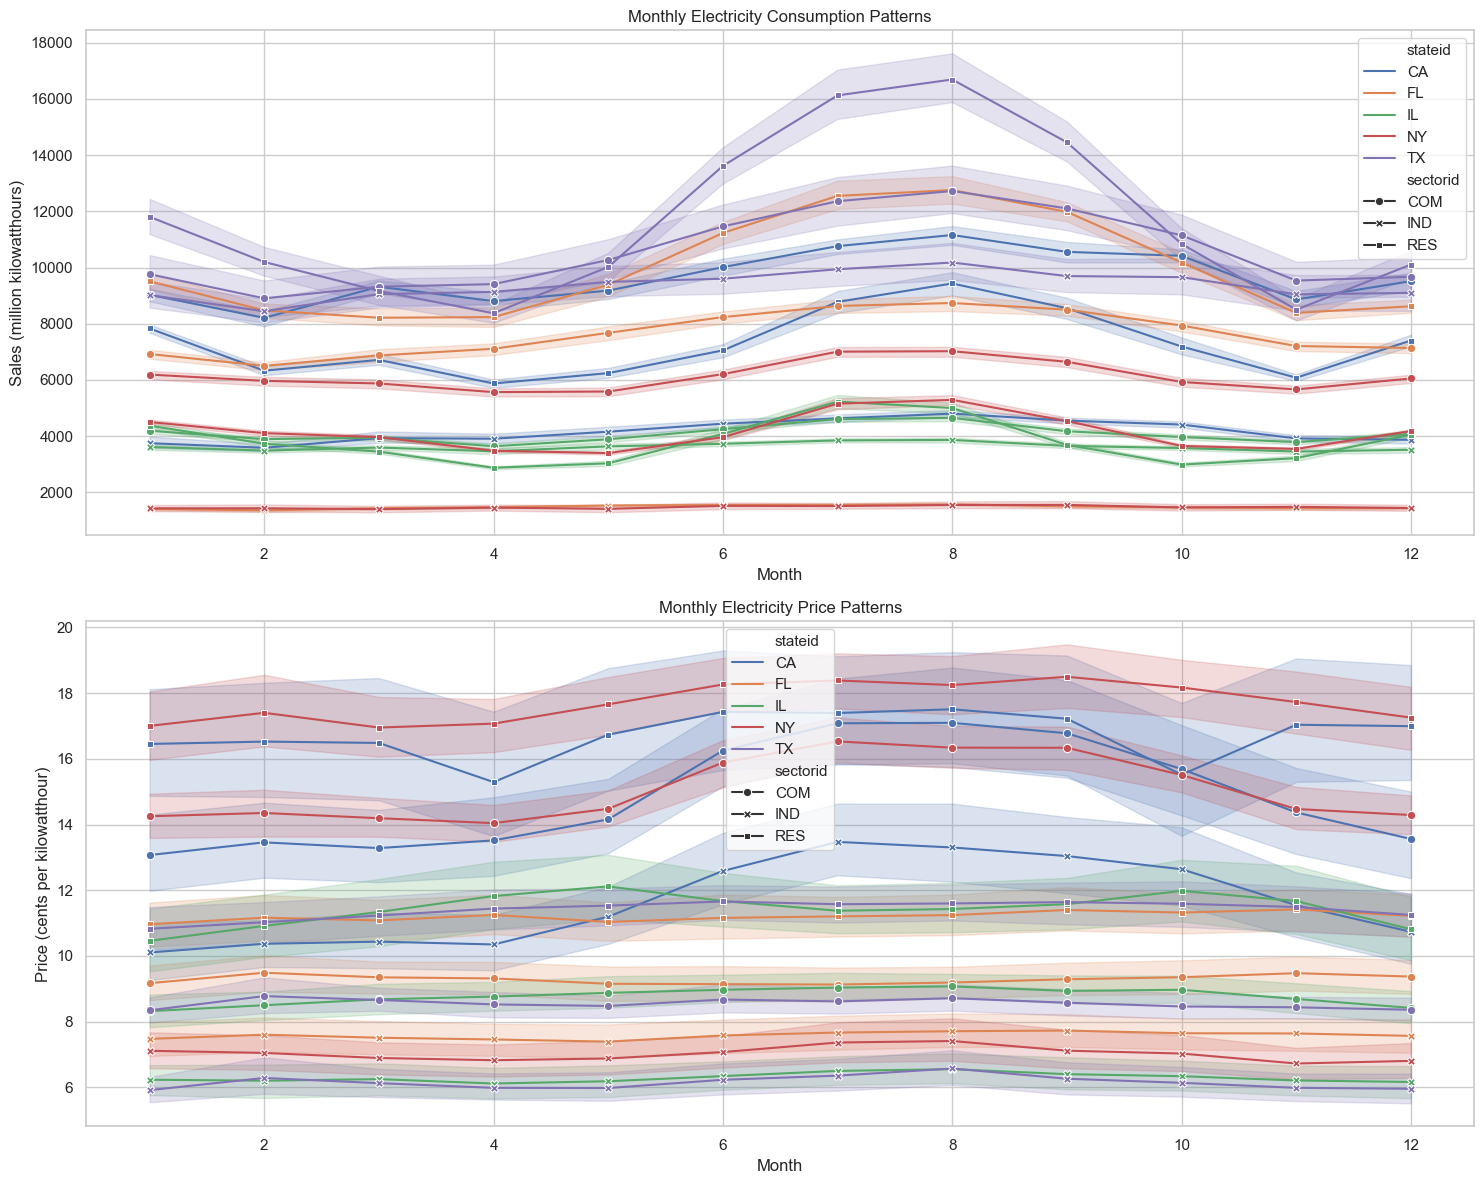


Monthly Averages by State:
------------------------


price    sales
stateid month                
CA      1      13.21  6871.63
        2      13.45  6042.71
        3      13.40  6654.65
        4      13.05  6197.16
        5      14.03  6527.30
        6      15.42  7170.29
        7      15.98  8057.24
        8      15.97  8464.81
        9      15.68  7888.07
        10     14.61  7340.46
        11     14.32  6288.47
        12     13.76  6929.51

In [32]:
# Create seasonal analysis plots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Monthly consumption patterns by state
sns.lineplot(
    data=energy_data,
    x='month',
    y='sales',
    hue='stateid',
    style='sectorid',
    markers=True,
    dashes=False,
    ax=axes[0]
)
axes[0].set_title('Monthly Electricity Consumption Patterns')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Sales (million kilowatthours)')

# Monthly price patterns by state
sns.lineplot(
    data=energy_data,
    x='month',
    y='price',
    hue='stateid',
    style='sectorid',
    markers=True,
    dashes=False,
    ax=axes[1]
)
axes[1].set_title('Monthly Electricity Price Patterns')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Price (cents per kilowatthour)')

plt.tight_layout()
plt.show()

# Calculate and display monthly averages
print("\nMonthly Averages by State:")
print("------------------------")
monthly_avg = energy_data.groupby(['stateid', 'month'])[['price', 'sales']].mean().round(2)
display(monthly_avg.head(12))  # Show first state's data


State-Level Statistics:
---------------------


price           sales           revenue          \
                   mean   std      mean      std     mean     std   
stateid sectorid                                                    
CA      COM       14.86  3.50   9652.29  1131.61  1441.85  411.04   
        IND       11.65  2.79   4165.25   521.98   486.04  136.18   
        RES       16.71  4.54   7290.53  1274.37  1226.66  426.01   
FL      COM        9.29  1.29   7623.08   903.34   712.02  145.21   
        IND        7.58  1.23   1479.47   132.33   111.51   17.22   
        RES       11.21  1.60   9960.22  1891.41  1124.47  305.47   
IL      COM        8.77  1.11   4091.38   378.94   359.13   56.26   
        IND        6.30  1.15   3621.10   253.22   227.61   42.02   
        RES       11.43  2.32   3811.86   803.66   433.91  118.96   
NY      COM       15.06  1.83   6143.81   624.70   930.99  180.06   
        IND        7.03  1.35   1474.10   291.39   101.97   21.12   
        RES       17.72  2.34   4149.53   652.38   739.18  171.61   
TX      COM        8.55  0.97  10555.40  2219.89   904.14  214.15   
        IND        6.15  1.16   9363.11  1477.79   576.24  145.10   
        RES       11.41  1.56  11657.82  3148.41  1343.28  450.57   

                    customers             
                         mean        std  
stateid sectorid                          
CA      COM        1747694.29   65268.60  
        IND         126021.43   34808.99  
        RES       13425941.78  473402.94  
FL      COM        1200840.04   56408.37  
        IND          20904.28    2554.88  
        RES        9168809.51  583636.89  
IL      COM         606275.33   19327.49  
        IND           5851.28     271.89  
        RES        5215158.59  116205.83  
NY      COM        1085252.99   52665.71  
        IND           7750.20     544.45  
        RES        7114763.80  147400.68  
TX      COM        1475276.06   80716.72  
        IND         170134.64   86654.86  
        RES       10613895.83  944207.51

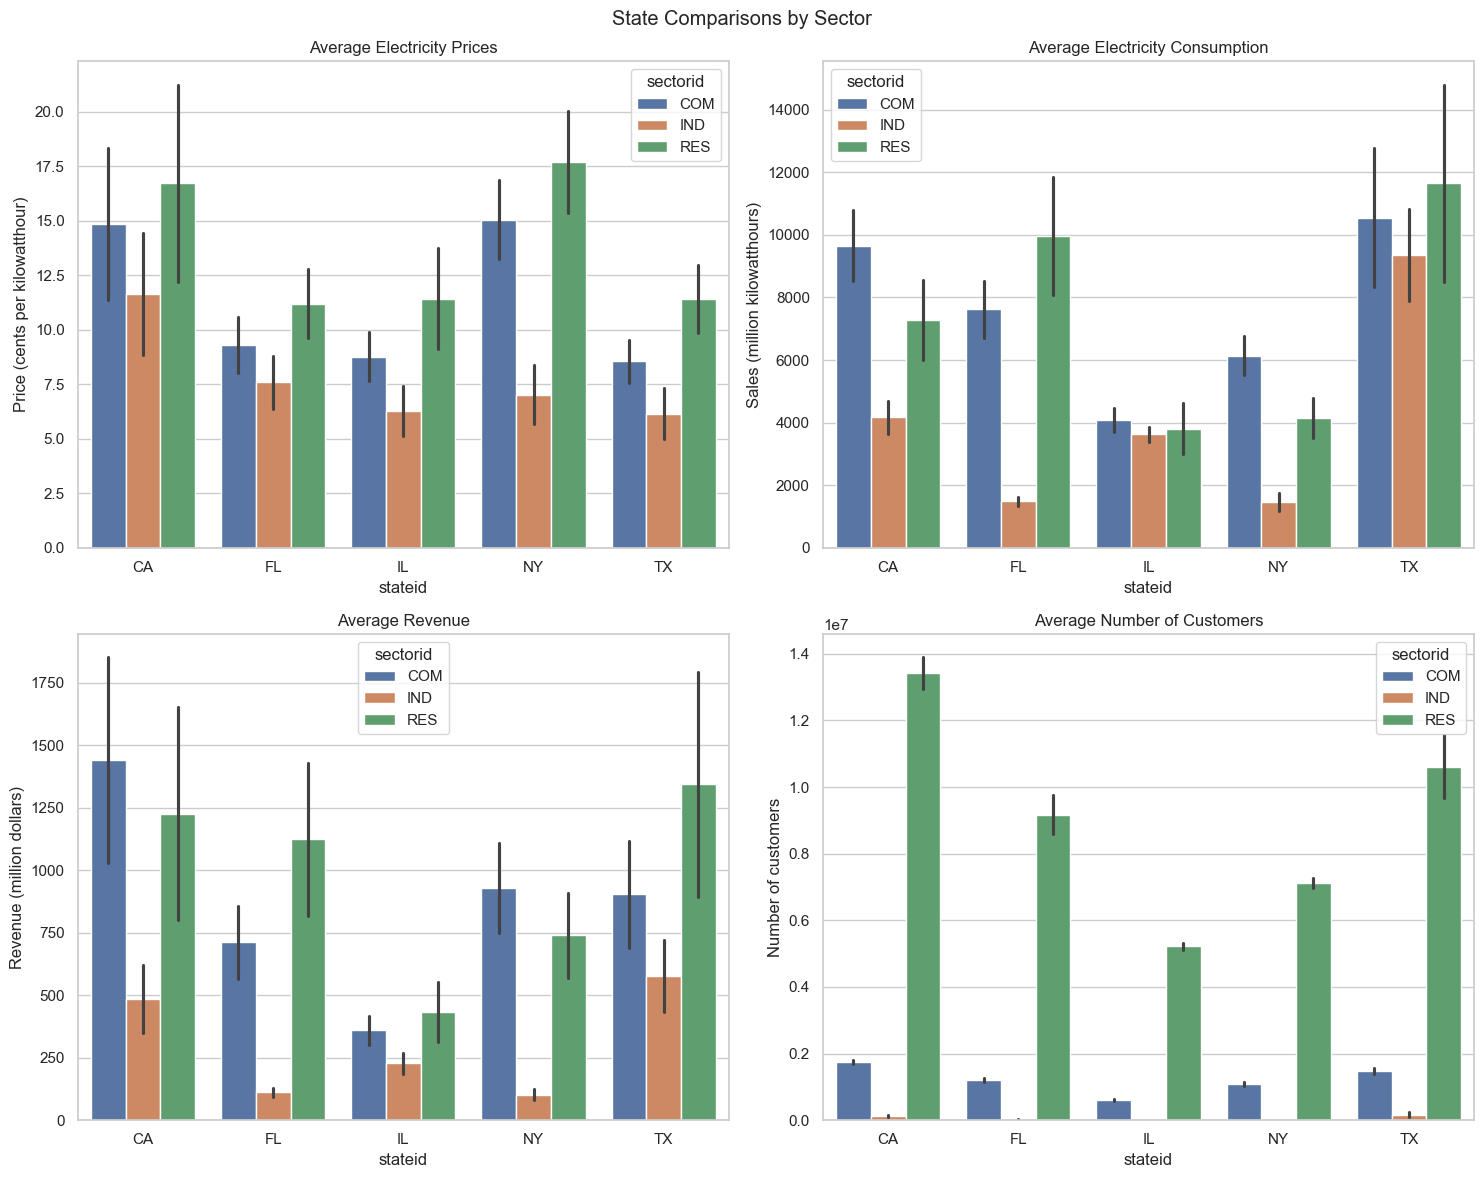

In [33]:
# Calculate state-level statistics
state_stats = energy_data.groupby(['stateid', 'sectorid']).agg({
    'price': ['mean', 'std'],
    'sales': ['mean', 'std'],
    'revenue': ['mean', 'std'],
    'customers': ['mean', 'std']
}).round(2)

print("State-Level Statistics:")
print("---------------------")
display(state_stats)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('State Comparisons by Sector')

# Average prices
sns.barplot(
    data=energy_data,
    x='stateid',
    y='price',
    hue='sectorid',
    ci='sd',
    ax=axes[0,0]
)
axes[0,0].set_title('Average Electricity Prices')
axes[0,0].set_ylabel('Price (cents per kilowatthour)')

# Average consumption
sns.barplot(
    data=energy_data,
    x='stateid',
    y='sales',
    hue='sectorid',
    ci='sd',
    ax=axes[0,1]
)
axes[0,1].set_title('Average Electricity Consumption')
axes[0,1].set_ylabel('Sales (million kilowatthours)')

# Average revenue
sns.barplot(
    data=energy_data,
    x='stateid',
    y='revenue',
    hue='sectorid',
    ci='sd',
    ax=axes[1,0]
)
axes[1,0].set_title('Average Revenue')
axes[1,0].set_ylabel('Revenue (million dollars)')

# Average customers
sns.barplot(
    data=energy_data,
    x='stateid',
    y='customers',
    hue='sectorid',
    ci='sd',
    ax=axes[1,1]
)
axes[1,1].set_title('Average Number of Customers')
axes[1,1].set_ylabel('Number of customers')

plt.tight_layout()
plt.show()


### Feature Engineering for Energy Consumption Analysis

We'll create several categories of features based on energy consumption research literature:

1. **Temporal Features**
   - Seasonal indicators
   - Monthly cyclical features
   - Year-over-year growth rates

2. **Customer-Related Features**
   - Per-customer consumption metrics
   - Customer density indicators

3. **Economic Indicators**
   - Price elasticity features
   - Revenue per customer

4. **Weather-Related Proxies**
   - Seasonal degree days (proxy through monthly patterns)
   - Peak vs. off-peak indicators

In [34]:
import pandas as pd
import numpy as np
from datetime import datetime

# 1. Temporal Features
# Convert period to datetime
energy_data['date'] = pd.to_datetime(energy_data['period'], format='%Y-%m')
energy_data['month'] = energy_data['date'].dt.month
energy_data['year'] = energy_data['date'].dt.year

# Create seasonal indicators (meteorological seasons)
energy_data['season'] = pd.cut(energy_data['month'], 
                              bins=[0,3,6,9,12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'],
                              include_lowest=True)

# Create cyclical month features
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)

# 2. Customer-Related Features
# Per-customer metrics
energy_data['revenue_per_customer'] = energy_data['revenue'] * 1_000_000 / energy_data['customers']  # Convert to dollars per customer
energy_data['avg_consumption'] = energy_data['sales'] * 1_000_000 / energy_data['customers']  # kWh per customer

# Calculate year-over-year growth rates
energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12)
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change(periods=12)

# 3. Economic Indicators
# Price elasticity features (using log differences)
energy_data['price_change'] = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
energy_data['consumption_change'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = energy_data['consumption_change'] / energy_data['price_change']

# Revenue metrics
energy_data['revenue_per_kwh'] = energy_data['revenue'] / energy_data['sales']

# 4. Weather-Related Proxies
# Create peak vs off-peak indicators (summer months are typically peak)
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8]).astype(int)

# Create degree day proxies based on monthly patterns
energy_data['cooling_proxy'] = np.where(energy_data['month'].isin([6, 7, 8]), 
                                      energy_data['avg_consumption'], 0)
energy_data['heating_proxy'] = np.where(energy_data['month'].isin([12, 1, 2]), 
                                      energy_data['avg_consumption'], 0)

# Display the first few rows of new features
print("\nNew Feature Summary:")
print("-------------------")
new_features = ['season', 'month_sin', 'month_cos', 'revenue_per_customer', 
                'consumption_yoy', 'price_elasticity', 'is_peak_season']
print(energy_data[new_features].head())

# Display basic statistics of new numerical features
print("\nNumerical Feature Statistics:")
print("--------------------------")
numerical_features = ['revenue_per_customer', 'avg_consumption', 'consumption_yoy', 
                     'price_elasticity', 'revenue_per_kwh']
print(energy_data[numerical_features].describe())


New Feature Summary:
-------------------
     season  month_sin     month_cos  revenue_per_customer  consumption_yoy  \
364  Winter   0.500000  8.660254e-01                   NaN              NaN   
421  Winter   0.866025  5.000000e-01                   NaN              NaN   
407  Winter   1.000000  6.123234e-17                   NaN              NaN   
406  Spring   0.866025 -5.000000e-01                   NaN              NaN   
349  Spring   0.500000 -8.660254e-01                   NaN              NaN   

     price_elasticity  is_peak_season  
364               NaN               0  
421               NaN               0  
407               NaN               0  
406               NaN               0  
349               NaN               0  

Numerical Feature Statistics:
--------------------------
       revenue_per_customer  avg_consumption  consumption_yoy  \
count           2880.000000      2880.000000      2700.000000   
mean            4836.791823     66699.546117        -0.

ValueError: supplied range of [-inf, inf] is not finite

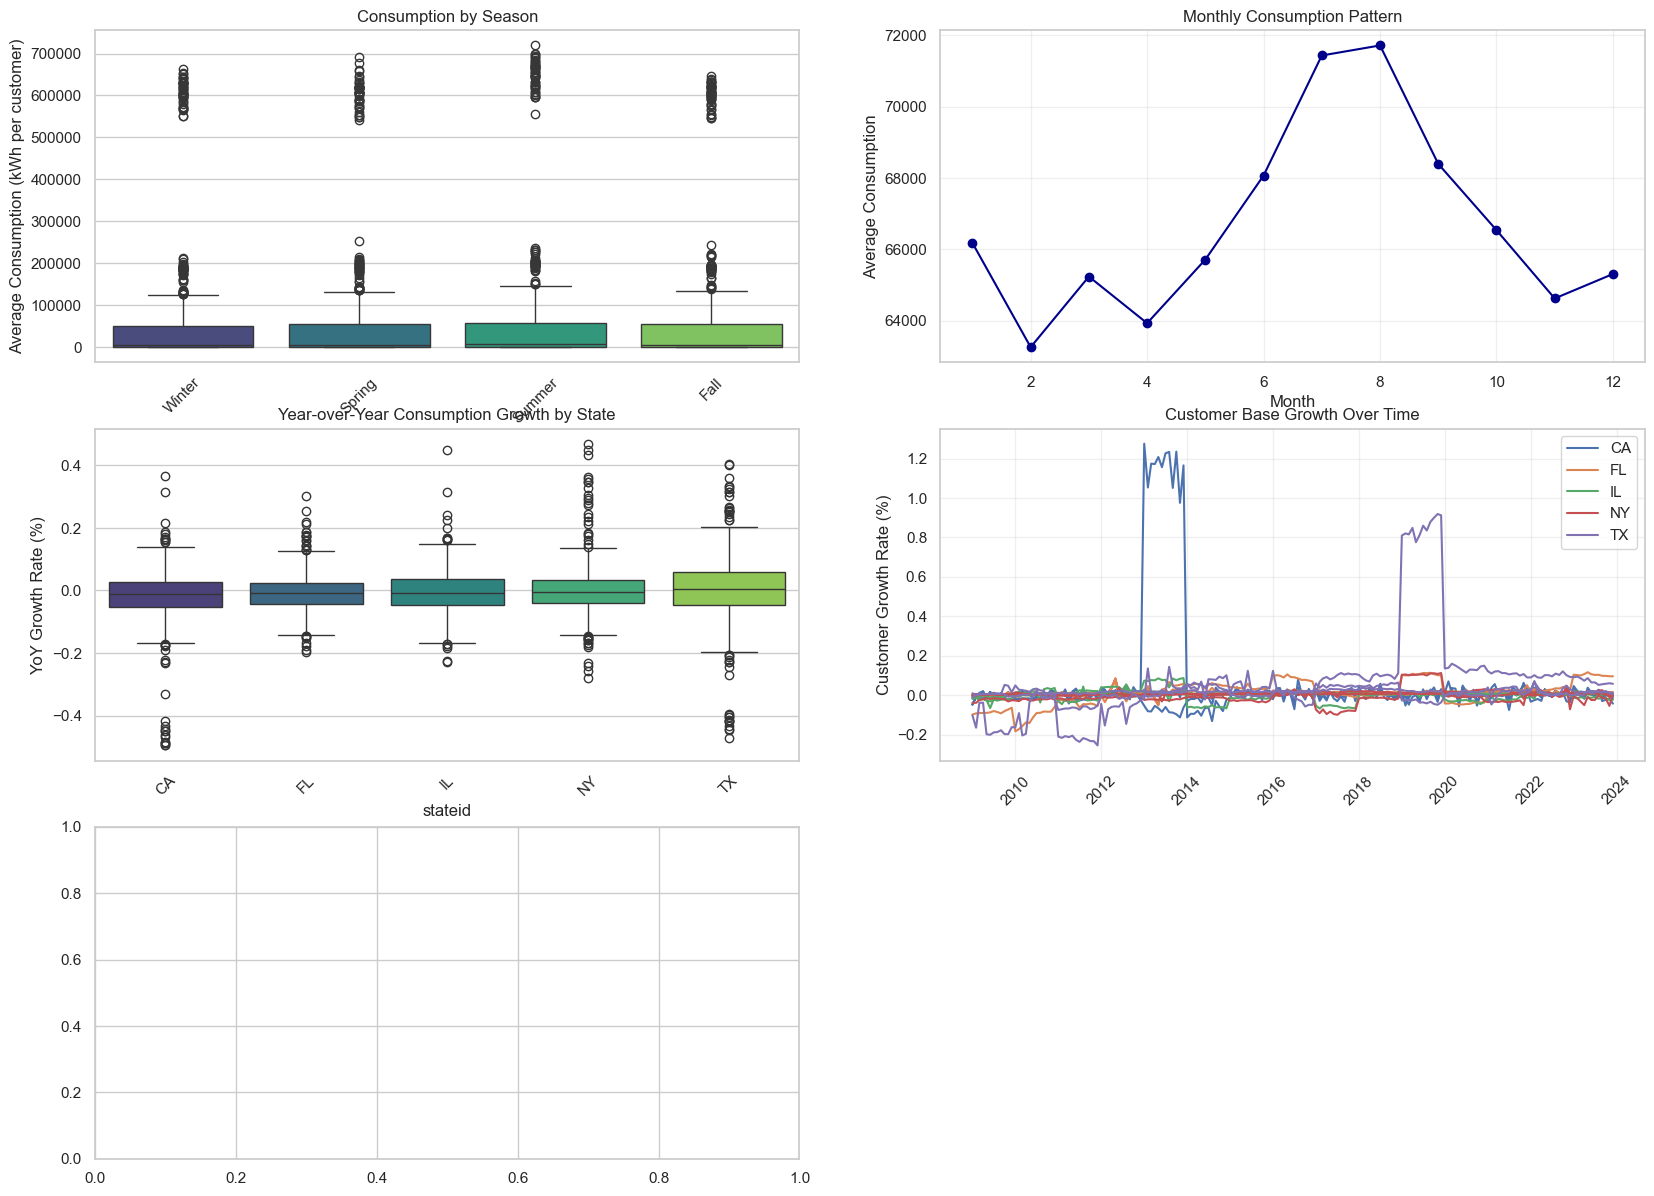

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(20, 25))

# 1. Temporal Features
# Seasonal patterns
plt.subplot(5, 2, 1)
sns.boxplot(x='season', y='avg_consumption', data=energy_data, palette='viridis')
plt.title('Consumption by Season', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Average Consumption (kWh per customer)')

# Cyclical monthly patterns
plt.subplot(5, 2, 2)
monthly_avg = energy_data.groupby('month')['avg_consumption'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', color='darkblue')
plt.title('Monthly Consumption Pattern', fontsize=12)
plt.xlabel('Month')
plt.ylabel('Average Consumption')
plt.grid(True, alpha=0.3)

# 2. Customer-Related Features
# Consumption YoY Growth
plt.subplot(5, 2, 3)
sns.boxplot(x='stateid', y='consumption_yoy', data=energy_data, palette='viridis')
plt.title('Year-over-Year Consumption Growth by State', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('YoY Growth Rate (%)')

# Customer Growth
plt.subplot(5, 2, 4)
for state in energy_data['stateid'].unique():
    state_data = energy_data[energy_data['stateid'] == state]
    plt.plot(state_data['date'], state_data['customer_growth'], label=state)
plt.title('Customer Base Growth Over Time', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Customer Growth Rate (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Economic Indicators
# Price Elasticity Distribution
plt.subplot(5, 2, 5)
plt.hist(energy_data['price_elasticity'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Price Elasticity', fontsize=12)
plt.xlabel('Price Elasticity')
plt.grid(True, alpha=0.3)

# Revenue per Customer vs Consumption
plt.subplot(5, 2, 6)
for state in energy_data['stateid'].unique():
    state_data = energy_data[energy_data['stateid'] == state]
    plt.scatter(state_data['avg_consumption'], state_data['revenue_per_customer'], 
               alpha=0.5, label=state)
plt.title('Revenue per Customer vs Consumption', fontsize=12)
plt.xlabel('Average Consumption (kWh)')
plt.ylabel('Revenue per Customer ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Weather-Related Proxies
# Peak vs Off-Peak Consumption
plt.subplot(5, 2, 7)
sns.boxplot(x='is_peak_season', y='avg_consumption', data=energy_data, palette='viridis')
plt.title('Consumption: Peak vs Off-Peak Season', fontsize=12)
plt.xlabel('Peak Season (1 = Yes, 0 = No)')
plt.ylabel('Average Consumption (kWh)')

# Heating vs Cooling Proxy
plt.subplot(5, 2, 8)
heating_cooling = pd.DataFrame({
    'Heating': energy_data['heating_proxy'].mean(),
    'Cooling': energy_data['cooling_proxy'].mean()
}, index=['Average Consumption'])
heating_cooling.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Heating vs Cooling Season Average Consumption', fontsize=12)
plt.ylabel('Average Consumption (kWh)')
plt.grid(True, alpha=0.3)

# 5. State and Sector Comparisons
# State-wise Consumption Patterns
plt.subplot(5, 2, 9)
sns.boxplot(x='stateid', y='avg_consumption', hue='sectorid', data=energy_data, palette='viridis')
plt.title('Consumption by State and Sector', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Average Consumption (kWh)')

# Time Series of Price vs Consumption
plt.subplot(5, 2, 10)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(energy_data['date'], energy_data['price'], color='blue', label='Price')
ax2.plot(energy_data['date'], energy_data['avg_consumption'], color='red', label='Consumption')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (cents/kWh)', color='blue')
ax2.set_ylabel('Consumption (kWh)', color='red')
plt.title('Price vs Consumption Over Time', fontsize=12)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
numerical_features = ['avg_consumption', 'price', 'revenue_per_customer', 
                     'consumption_yoy', 'customer_growth', 'price_elasticity',
                     'month_sin', 'month_cos', 'is_peak_season']
correlation_matrix = energy_data[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True)
plt.title('Correlation Matrix of Features', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Create interaction terms for highly correlated features
energy_data['price_consumption_interaction'] = energy_data['price'] * energy_data['avg_consumption']
energy_data['seasonal_consumption'] = energy_data['avg_consumption'] * energy_data['is_peak_season']

# Create polynomial features for price (given the non-linear relationship with consumption)
energy_data['price_squared'] = energy_data['price'] ** 2


Model Performance:
------------------
R² Score: 0.494
Root Mean Squared Error: 131106.486


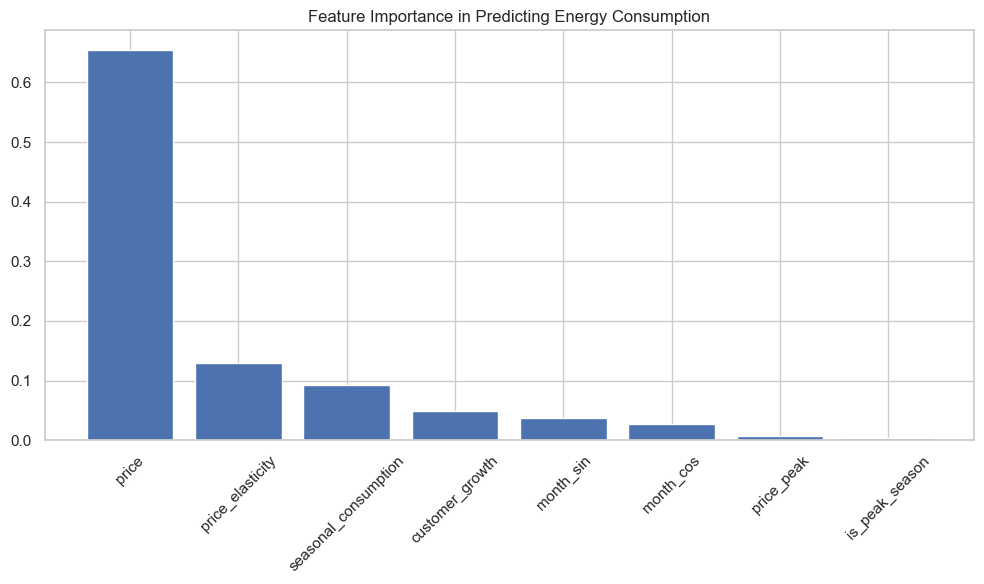


Feature Importance:
------------------
                feature  importance
0                 price    0.654468
5      price_elasticity    0.129052
7  seasonal_consumption    0.092979
4       customer_growth    0.048595
2             month_sin    0.037962
3             month_cos    0.027340
6            price_peak    0.006259
1        is_peak_season    0.003346

Cross-validation Scores:
------------------------
Mean R² Score: -41.808 (+/- 157.817)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare features based on correlation insights
features = ['price', 'is_peak_season', 'month_sin', 'month_cos', 
           'customer_growth', 'price_elasticity']

# Create some interaction terms
energy_data['price_peak'] = energy_data['price'] * energy_data['is_peak_season']
energy_data['seasonal_consumption'] = energy_data['avg_consumption'] * energy_data['is_peak_season']
features.extend(['price_peak', 'seasonal_consumption'])

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(energy_data[features])
y = energy_data['avg_consumption']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print model performance
print("\nModel Performance:")
print("------------------")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

# Feature importance
importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
importance = importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance['feature'], importance['importance'])
plt.xticks(rotation=45)
plt.title('Feature Importance in Predicting Energy Consumption')
plt.tight_layout()
plt.show()

# Print feature importance
print("\nFeature Importance:")
print("------------------")
print(importance)

# Add cross-validation scores
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)

print("\nCross-validation Scores:")
print("------------------------")
print(f"Mean R² Score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# First, ensure all relevant columns are numeric
numeric_columns = ['price', 'sales', 'revenue', 'customers']
for col in numeric_columns:
    energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')

# Calculate sales per customer
energy_data['sales_per_customer'] = energy_data['sales'] / energy_data['customers']

# Create dummy variables for categorical columns
# Make sure to handle missing values before creating dummies
categorical_columns = ['stateid', 'sectorid']
for col in categorical_columns:
    energy_data[col] = energy_data[col].astype('category')

# Create dummy variables
X = pd.get_dummies(energy_data[categorical_columns], drop_first=True)

# Add constant
X = sm.add_constant(X)

# Make sure all data is numeric and finite
X = X.astype(float)
price = pd.to_numeric(energy_data['price'], errors='coerce')
sales_per_customer = pd.to_numeric(energy_data['sales_per_customer'], errors='coerce')

# Drop any rows with NaN or infinite values
mask = (~np.isnan(price) & ~np.isinf(price) & 
        ~np.isnan(sales_per_customer) & ~np.isinf(sales_per_customer) &
        ~X.isna().any(axis=1))

X = X[mask]
price = price[mask]
sales_per_customer = sales_per_customer[mask]

# Run regression for price
model_price = sm.OLS(price, X).fit()

# Run regression for consumption per customer
model_consumption = sm.OLS(sales_per_customer, X).fit()

# Print results
print("\nPrice Model Results:")
print(model_price.summary().tables[1])

print("\nConsumption per Customer Model Results:")
print(model_consumption.summary().tables[1])

# Optional: Print model diagnostics
print("\nPrice Model R-squared:", model_price.rsquared)
print("Consumption Model R-squared:", model_consumption.rsquared)


Price Model Results:
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           22.7411      0.286     79.525      0.000      22.179      23.304
stateid_FL     -10.8538      0.342    -31.756      0.000     -11.526     -10.182
stateid_IL     -10.8511      0.342    -31.748      0.000     -11.523     -10.179
stateid_NY      -6.8739      0.342    -20.111      0.000      -7.546      -6.202
stateid_TX     -12.7097      0.342    -37.186      0.000     -13.382     -12.038
sectorid_IND    -4.6205      0.265    -17.452      0.000      -5.141      -4.100
sectorid_RES     4.3718      0.265     16.513      0.000       3.851       4.892

Consumption per Customer Model Results:
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0477      0.015     -3.143 

In [ ]:
# Function to fetch data from EIA API
def fetch_electricity_data(state=None, sector=None, frequency="monthly", start=None, end=None):
    """
    Fetch electricity retail sales data from EIA API
    
    Parameters:
    -----------
    state : str
        Two-letter state code (e.g., 'CA' for California)
    sector : str
        Sector code ('RES' for residential, 'COM' for commercial, etc.)
    frequency : str
        Data frequency ('monthly', 'annual', etc.)
    start : str
        Start date in YYYY-MM format
    end : str
        End date in YYYY-MM format
    
    Returns:
    --------
    pandas.DataFrame
    """
    endpoint = f"{BASE_URL}/electricity/retail-sales/data"
    
    params = {
        'api_key': API_KEY,
        'frequency': frequency,
        'data[]': ['price', 'sales', 'revenue', 'customers']
    }
    
    if state:
        params['facets[stateid][]'] = state
    if sector:
        params['facets[sectorid][]'] = sector
    if start:
        params['start'] = start
    if end:
        params['end'] = end
        
    try:
        response = requests.get(endpoint, params=params)
        response.raise_for_status()
        data = response.json()
        
        if 'response' in data and 'data' in data['response']:
            df = pd.DataFrame(data['response']['data'])
            # Convert period to datetime
            df['period'] = pd.to_datetime(df['period'] + '-01')
            # Convert numeric columns
            numeric_cols = ['price', 'sales', 'revenue', 'customers']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            return df
        else:
            print("No data found in the response")
            return None
            
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None


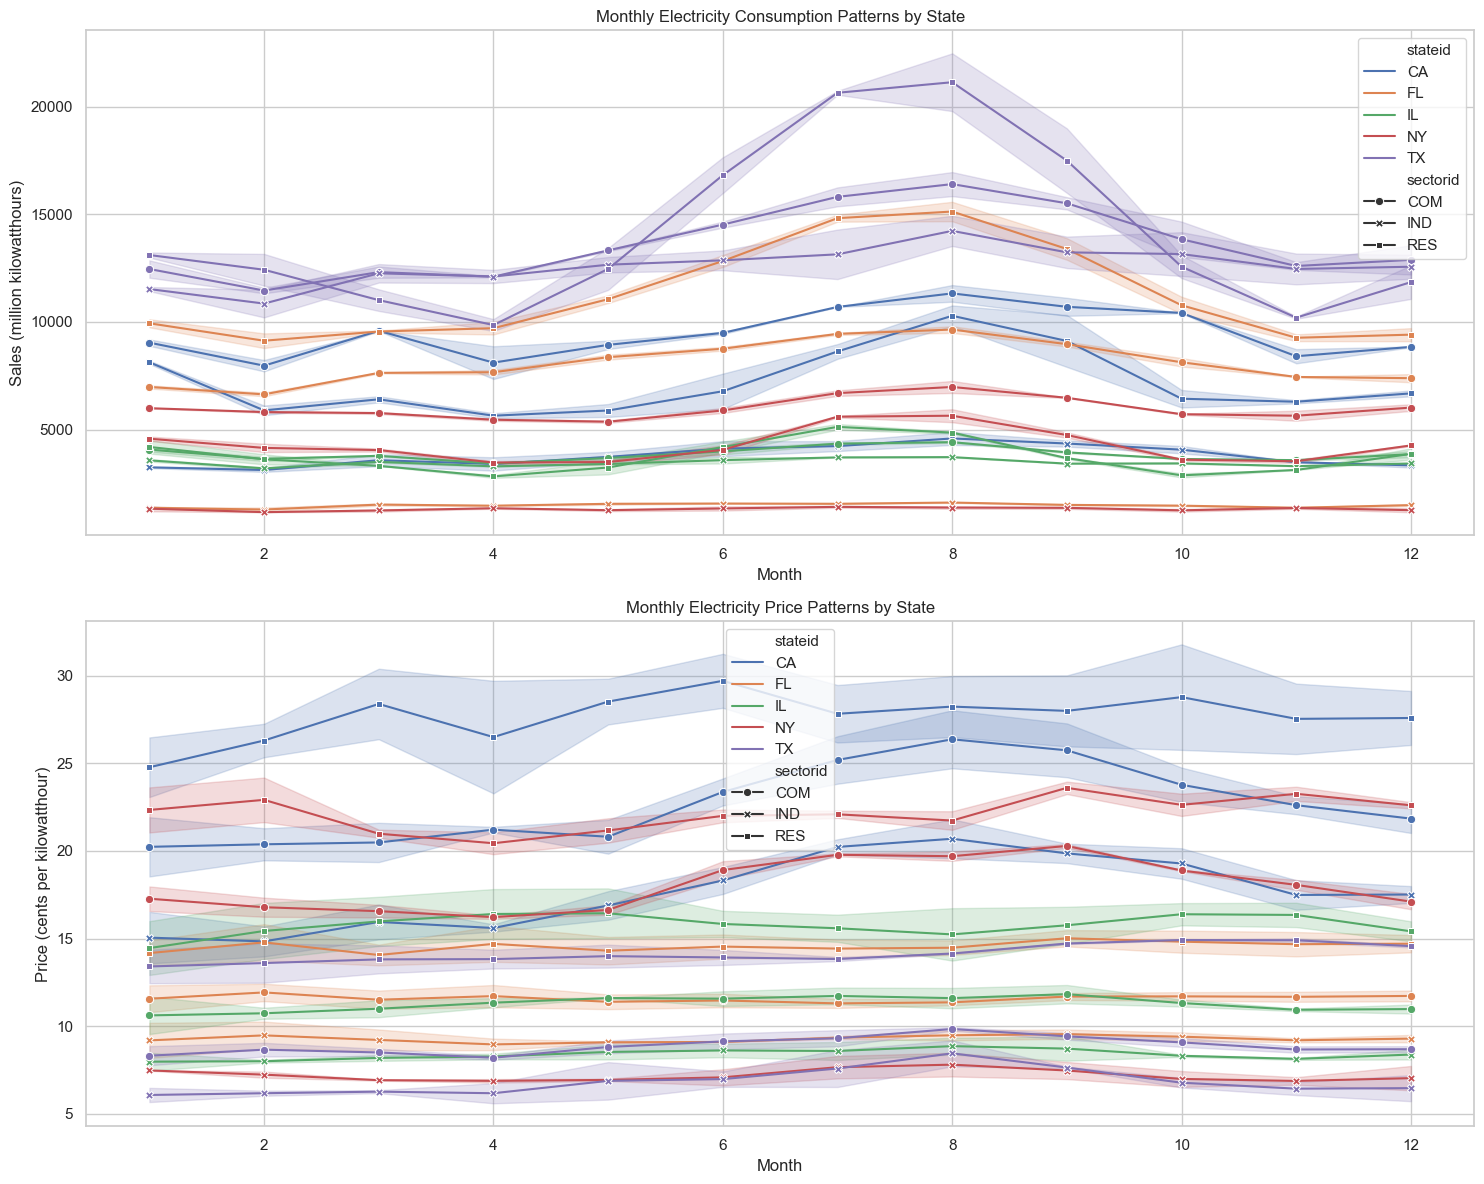


Average Seasonal Metrics by State:
--------------------------------


price    sales
stateid month                
CA      1      20.02  6803.18
        2      20.50  5660.87
        3      21.60  6524.23
        4      21.10  5719.95
        5      22.07  6184.67
        6      23.79  6796.28
        7      24.41  7853.50
        8      25.10  8734.48
        9      24.52  8058.04
        10     23.94  6973.10
        11     22.54  6060.98
        12     22.31  6287.24

In [ ]:
# Add month and year columns for seasonal analysis
energy_data['month'] = energy_data['period'].dt.month
energy_data['year'] = energy_data['period'].dt.year

# Create seasonal plots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Monthly consumption patterns by state
sns.lineplot(
    data=energy_data,
    x='month',
    y='sales',
    hue='stateid',
    style='sectorid',
    markers=True,
    dashes=False,
    ax=axes[0]
)
axes[0].set_title('Monthly Electricity Consumption Patterns by State')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Sales (million kilowatthours)')

# 2. Monthly price patterns by state
sns.lineplot(
    data=energy_data,
    x='month',
    y='price',
    hue='stateid',
    style='sectorid',
    markers=True,
    dashes=False,
    ax=axes[1]
)
axes[1].set_title('Monthly Electricity Price Patterns by State')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Price (cents per kilowatthour)')

plt.tight_layout()
plt.show()

# Calculate and display average seasonal metrics
print("\nAverage Seasonal Metrics by State:")
print("--------------------------------")
seasonal_avg = energy_data.groupby(['stateid', 'month'])[['price', 'sales']].mean().round(2)
display(seasonal_avg.head(12))  # Show first state's data


In [ ]:
# Data preparation and feature engineering
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Convert period to datetime if not already done
energy_data['date'] = pd.to_datetime(energy_data['period'], format='%Y-%m')
energy_data['month'] = energy_data['date'].dt.month
energy_data['year'] = energy_data['date'].dt.year

# Create seasonal indicators
energy_data['season'] = pd.cut(energy_data['month'], 
                              bins=[0,3,6,9,12], 
                              labels=['Winter', 'Spring', 'Summer', 'Fall'],
                              include_lowest=True)

# Create cyclical month features
energy_data['month_sin'] = np.sin(2 * np.pi * energy_data['month']/12)
energy_data['month_cos'] = np.cos(2 * np.pi * energy_data['month']/12)

# Customer-Related Features
energy_data['revenue_per_customer'] = energy_data['revenue'] * 1_000_000 / energy_data['customers']
energy_data['avg_consumption'] = energy_data['sales'] * 1_000_000 / energy_data['customers']

# Calculate year-over-year growth rates
energy_data['consumption_yoy'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change(periods=12)
energy_data['customer_growth'] = energy_data.groupby(['stateid', 'sectorid'])['customers'].pct_change(periods=12)

# Price elasticity features
energy_data['price_change'] = energy_data.groupby(['stateid', 'sectorid'])['price'].pct_change()
energy_data['consumption_change'] = energy_data.groupby(['stateid', 'sectorid'])['avg_consumption'].pct_change()
energy_data['price_elasticity'] = energy_data['consumption_change'] / energy_data['price_change']

# Peak season indicator
energy_data['is_peak_season'] = energy_data['month'].isin([6, 7, 8]).astype(int)

# Create figures directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

# Calculate correlation matrix for numerical features
numerical_features = ['avg_consumption', 'price', 'revenue_per_customer', 
                     'consumption_yoy', 'customer_growth', 'price_elasticity',
                     'month_sin', 'month_cos', 'is_peak_season']
correlation_matrix = energy_data[numerical_features].corr()

# 1. Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.savefig('figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Seasonal Patterns
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='avg_consumption', data=energy_data)
plt.title('Consumption by Season')
plt.xticks(rotation=45)
plt.savefig('figures/seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Feature Importance from Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Prepare features
features = ['price', 'is_peak_season', 'month_sin', 'month_cos', 
           'customer_growth', 'price_elasticity']

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(energy_data[features])
y = energy_data['avg_consumption']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create importance DataFrame
importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
})
importance = importance.sort_values('importance', ascending=True)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(importance['feature'], importance['importance'])
plt.title('Feature Importance in Energy Consumption Prediction')
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

print("All figures have been saved in the 'figures' directory!")
# List all generated files
print("\nGenerated files:")
for file in os.listdir('figures'):
    print(f"- {file}")

All figures have been saved in the 'figures' directory!

Generated files:
- correlation_matrix.png
- feature_importance.png
- seasonal_patterns.png
- time_series.png


# Modeling
<a id="Modeling"></a> 

In [36]:
# For NumPy arrays, use np.where() to replace inf/-inf values
import numpy as np

# Replace inf/-inf in X
X = np.where(np.isinf(X) & (X > 0), 1e9, X)  # Replace positive inf
X = np.where(np.isinf(X) & (X < 0), -1e9, X)  # Replace negative inf

# Replace inf/-inf in y
y = np.where(np.isinf(y) & (y > 0), 1e9, y)  # Replace positive inf
y = np.where(np.isinf(y) & (y < 0), -1e9, y)  # Replace negative inf

# To check for any remaining nulls/inf
print("X contains inf:", np.any(np.isinf(X)))
print("X contains nan:", np.any(np.isnan(X)))
print("y contains inf:", np.any(np.isinf(y)))
print("y contains nan:", np.any(np.isnan(y)))

X contains inf: False
X contains nan: False
y contains inf: False
y contains nan: True


In [37]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define target and features
target = 'sales'  # Energy consumption/sales is our target variable
features = ['price', 'revenue', 'customers']

# Ensure data types are correct
for col in ['price', 'sales', 'revenue', 'customers']:
    if col in energy_data.columns:
        energy_data[col] = pd.to_numeric(energy_data[col], errors='coerce')
# Drop rows with NaN in features or target
model_data = energy_data.dropna(subset=features + [target]).copy()

# One-hot encode categorical features
model_data = pd.get_dummies(model_data, columns=['stateid', 'sectorid'], drop_first=True)

# Drop target and any datetime columns
X = model_data.drop(columns=[target, 'date', 'period'], errors='ignore')

# Keep only numeric columns
X = X.select_dtypes(include=[np.number])
y = model_data[target]

# Replace inf/-inf with NaN, then drop those rows
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=0, how='any')
y = y.loc[X.index]  # Align y with X

# Now scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
# Display all columns and their data types
print("Column Information:")
print("------------------")
display(energy_data.dtypes)

print("\nSample Row with All Fields:")
print("-------------------------")
# Display one row with all fields to see the actual values
display(energy_data.iloc[0])

print("\nUnique Values in Categorical Columns:")
print("----------------------------------")
categorical_cols = energy_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    print(energy_data[col].unique())

print("\nNumerical Columns Summary:")
print("-----------------------")
numeric_cols = energy_data.select_dtypes(include=['float64', 'int64']).columns
display(energy_data[numeric_cols].describe())

# Display any column-specific units or metadata from the API response
print("\nColumn Units and Descriptions:")
print("--------------------------")
units_info = {
    'price': 'cents per kilowatthour',
    'sales': 'million kilowatthours',
    'revenue': 'million dollars',
    'customers': 'number of customers',
    'period': 'YYYY-MM date',
    'stateid': 'state code',
    'stateDescription': 'state name',
    'sectorid': 'sector code',
    'sectorName': 'sector description'
}

for col, unit in units_info.items():
    print(f"{col}: {unit}")


Column Information:
------------------


period                  datetime64[ns]
stateid                         object
stateDescription                object
sectorid                        object
sectorName                      object
price                          float64
sales                          float64
revenue                        float64
customers                      float64
price-units                     object
sales-units                     object
revenue-units                   object
customers-units                 object
month                            int32
season                        category
date                    datetime64[ns]
usage_per_customer             float64
avg_consumption                float64
revenue_per_customer           float64
consumption_yoy                float64
customer_growth                float64
price_elasticity               float64
month_sin                      float64
month_cos                      float64
is_peak_season                   int64
sales_yoy                


Sample Row with All Fields:
-------------------------


period                      2001-01-01 00:00:00
stateid                                      CA
stateDescription                     California
sectorid                                    COM
sectorName                           commercial
price                                      9.28
sales                                7765.88946
revenue                               720.72952
customers                                   NaN
price-units             cents per kilowatt-hour
sales-units              million kilowatt hours
revenue-units                   million dollars
customers-units             number of customers
month                                         1
season                                   Winter
date                        2001-01-01 00:00:00
usage_per_customer                          NaN
avg_consumption                             NaN
revenue_per_customer                        NaN
consumption_yoy                             NaN
customer_growth                         


Unique Values in Categorical Columns:
----------------------------------

stateid:
['CA' 'FL' 'IL' 'NY' 'TX']

stateDescription:
['California' 'Florida' 'Illinois' 'New York' 'Texas']

sectorid:
['COM' 'IND' 'RES']

sectorName:
['commercial' 'industrial' 'residential']

price-units:
['cents per kilowatt-hour']

sales-units:
['million kilowatt hours']

revenue-units:
['million dollars']

customers-units:
['number of customers']

Numerical Columns Summary:
-----------------------


price         sales      revenue     customers  \
count  4140.000000   4140.000000  4140.000000  2.880000e+03   
mean     10.913976   6335.930961   714.599376  3.465638e+06   
std       4.212168   3500.840669   484.647049  4.355132e+06   
min       3.900000   1028.986970    62.197330  5.356000e+03   
25%       7.837500   3694.463188   348.022927  1.206465e+05   
50%       9.900000   5927.027545   659.980670  1.195466e+06   
75%      13.370000   8835.192127   996.267467  6.987535e+06   
max      31.780000  22481.421200  3185.732050  1.457131e+07   

       usage_per_customer  avg_consumption  revenue_per_customer  \
count         2880.000000      2880.000000           2880.000000   
mean         66699.546117     66699.546117           4836.791823   
std         154497.221803    154497.221803          10638.388876   
min            381.936786       381.936786             46.914644   
25%           1004.122038      1004.122038            132.130817   
50%           6346.973043      6346.973043            696.632455   
75%          54770.395195     54770.395195           4535.261203   
max         719260.831862    719260.831862          62865.011820   

       consumption_yoy  customer_growth  price_elasticity     month_sin  \
count      2700.000000      2700.000000       2865.000000  4.140000e+03   
mean         -0.004150         0.014060               NaN -1.673380e-17   
std           0.088544         0.102835               NaN  7.071922e-01   
min          -0.495627        -0.255499              -inf -1.000000e+00   
25%          -0.044799        -0.003677         -3.502294 -5.915064e-01   
50%          -0.007006         0.006109         -0.150594 -6.123234e-17   
75%           0.035618         0.017231          1.794499  5.915064e-01   
max           0.469402         1.275577               inf  1.000000e+00   

          month_cos  is_peak_season    sales_yoy  price_change  \
count  4.140000e+03     4140.000000  4140.000000   4125.000000   
mean  -4.542797e-17        0.250000     2.621466      0.003879   
std    7.071922e-01        0.433065    21.925212      0.062677   
min   -1.000000e+00        0.000000   -62.915831     -0.361917   
25%   -5.915064e-01        0.000000   -11.074671     -0.020639   
50%   -6.123234e-17        0.000000     0.119372      0.001175   
75%    5.915064e-01        0.250000    13.440845      0.025373   
max    1.000000e+00        1.000000   100.000000      1.277328   

       consumption_change  sales_per_customer  revenue_per_kwh  cooling_proxy  \
count         2865.000000         2880.000000      4140.000000    3825.000000   
mean             0.005776        66699.546117         0.109140   13252.835777   
std              0.117635       154497.221803         0.042122   75685.767042   
min             -0.536499          381.936786         0.038981       0.000000   
25%             -0.057976         1004.122038         0.078346       0.000000   
50%             -0.000635         6346.973043         0.099035       0.000000   
75%              0.060843        54770.395195         0.133706       0.000000   
max              0.782929       719260.831862         0.317800  719260.831862   

       heating_proxy  
count    3825.000000  
mean    12219.186722  
std     70527.791721  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max    663858.644937


Column Units and Descriptions:
--------------------------
price: cents per kilowatthour
sales: million kilowatthours
revenue: million dollars
customers: number of customers
period: YYYY-MM date
stateid: state code
stateDescription: state name
sectorid: sector code
sectorName: sector description


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor  # or any other model you prefer
import numpy as np

# First, create and train a model
# Assuming you already have X_train and y_train data
model = RandomForestRegressor(random_state=42)  # Initialize the model
model.fit(X_train, y_train)  # Train the model

# Now define the permutation importance function
def permutation_importance(model, X_val, y_val, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []
    for i in range(X_val.shape[1]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        score = metric(y_val, model.predict(X_permuted))
        importances.append(score - baseline)
    return np.array(importances)

# Calculate and print feature importances
importances = permutation_importance(model, X_test, y_test)
for i, imp in enumerate(importances):
    print(f"Feature {i}: Importance {imp:.4f}")

Feature 0: Importance 1458887.1186
Feature 1: Importance 32469879.0651
Feature 2: Importance 47091.7442
Feature 3: Importance 37.3613
Feature 4: Importance 76774.0485
Feature 5: Importance 63780.2497
Feature 6: Importance 3084.8160
Feature 7: Importance 3507.8192
Feature 8: Importance 10990.1865
Feature 9: Importance -244.2436
Feature 10: Importance 1326.6485
Feature 11: Importance -185.0079
Feature 12: Importance 172.9862
Feature 13: Importance -420.5193
Feature 14: Importance 258.3528
Feature 15: Importance 1346.9854
Feature 16: Importance 8298.9392
Feature 17: Importance 69575.9511
Feature 18: Importance 6927.1257
Feature 19: Importance 2909123.7022
Feature 20: Importance 4407.3630
Feature 21: Importance 991.8611


In [41]:
print("Columns:", list(energy_data.columns))

Columns: ['period', 'stateid', 'stateDescription', 'sectorid', 'sectorName', 'price', 'sales', 'revenue', 'customers', 'price-units', 'sales-units', 'revenue-units', 'customers-units', 'month', 'season', 'date', 'usage_per_customer', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy', 'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_peak_season', 'sales_yoy', 'price_change', 'consumption_change', 'year', 'sales_per_customer', 'year_num', 'revenue_per_kwh', 'cooling_proxy', 'heating_proxy']


In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,313 (52.00 KB)

 Trainable params: 13,313 (52.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 58007292.0000 - mae: 6599.3335 - val_loss: 57429976.0000 - val_mae: 6594.8511
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 56380700.0000 - mae: 6513.5854 - val_loss: 52782932.0000 - val_mae: 6291.3672
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 49095180.0000 - mae: 5988.0161 - val_loss: 33078462.0000 - val_mae: 4777.3457
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 25516530.0000 - mae: 4068.2532 - val_loss: 12453057.0000 - val_mae: 2685.2710
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9797543.0000 - mae: 2395.6230 - val_loss: 6794700.0000 - val_mae: 1990.8638
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5856324.5000 - mae: 1875.5155 - val_loss: 4600370.5000 - val_mae: 1676.2732
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4012901.5000 - mae: 1575.8545 - val_loss: 3644818.2500 - val_mae: 1469.8314
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - l

In [43]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {mae:.2f}")

Test MAE: 347.51


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


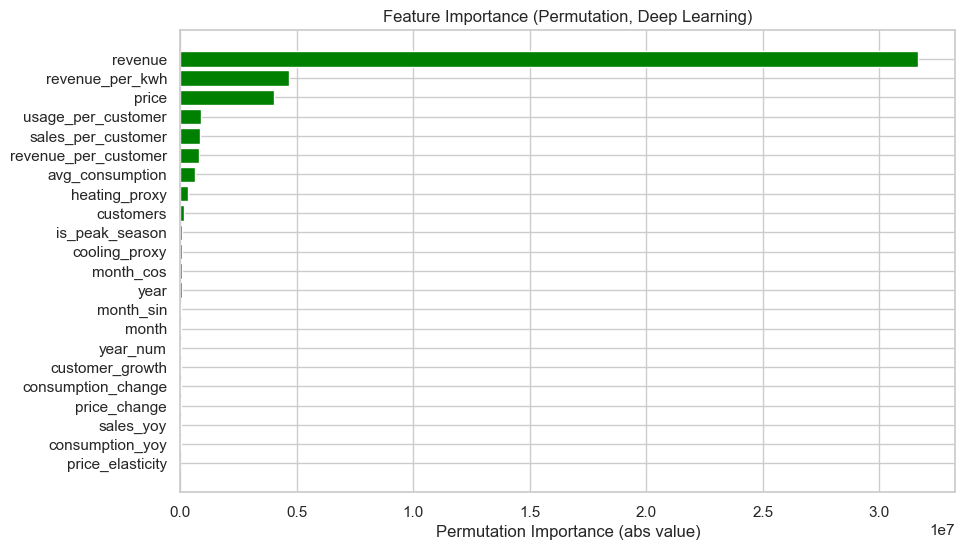

Feature importances (higher = more important):
revenue: 31684319.2065
revenue_per_kwh: 4649514.1223
price: 4002823.5825
usage_per_customer: 893301.4413
sales_per_customer: 851850.2804
revenue_per_customer: 792522.9012
avg_consumption: 611521.2595
heating_proxy: 339127.4468
customers: 175061.1433
is_peak_season: 90776.2900
cooling_proxy: 88599.7739
month_cos: 73429.5732
year: 55510.8857
month_sin: 45558.8254
month: 28178.0295
year_num: 22728.2682
customer_growth: 18872.7321
consumption_change: 18389.0882
price_change: 12780.8570
sales_yoy: 11774.7941
consumption_yoy: 8225.2740
price_elasticity: 7273.4101


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Function to compute permutation importance
def permutation_importance(model, X_val, y_val, metric=mean_squared_error):
    baseline = metric(y_val, model.predict(X_val))
    importances = []
    for i in range(X_val.shape[1]):
        X_permuted = X_val.copy()
        np.random.shuffle(X_permuted[:, i])
        score = metric(y_val, model.predict(X_permuted))
        # Importance: positive means error increased (feature is important)
        importances.append(score - baseline)
    return np.array(importances)

# Compute importances
importances = permutation_importance(model, X_test, y_test)
feature_names = list(X.columns)

# Sort by absolute importance
sorted_idx = np.argsort(np.abs(importances))[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot
colors = ['green' if imp > 0 else 'red' for imp in sorted_importances]
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, np.abs(sorted_importances), color=colors)
plt.xlabel('Permutation Importance (abs value)')
plt.title('Feature Importance (Permutation, Deep Learning)')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print("Feature importances (higher = more important):")
for feat, imp in zip(sorted_features, sorted_importances):
    print(f"{feat}: {imp:.4f}")

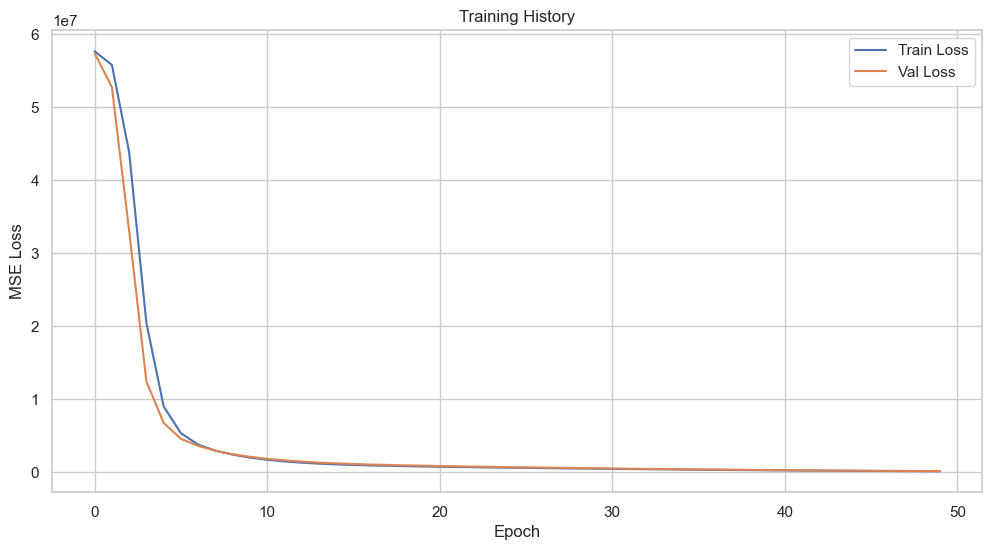

In [45]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.show()

# LSTM modeling
<a id="LSTM Modeling"></a>

Summer uplift ratio: 1.23
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 1.0766 - mae: 0.7208 - val_loss: 0.9923 - val_mae: 0.7543 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.4348 - mae: 0.4736 - val_loss: 0.7205 - val_mae: 0.6915 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.2383 - mae: 0.3595 - val_loss: 0.2184 - val_mae: 0.3719 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1521 - mae: 0.2964 - val_loss: 0.2255 - val_mae: 0.3744 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1650 - mae: 0.2785 - val_loss: 0.2475 - val_mae: 0.3842 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1221 - mae: 0.2423 - val_loss: 0.1883 - val_mae: 0.3405 - learning_rate: 5.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.1370 - mae: 0.2494 - val_loss: 0.1920 - val_mae: 0.3444 - learn

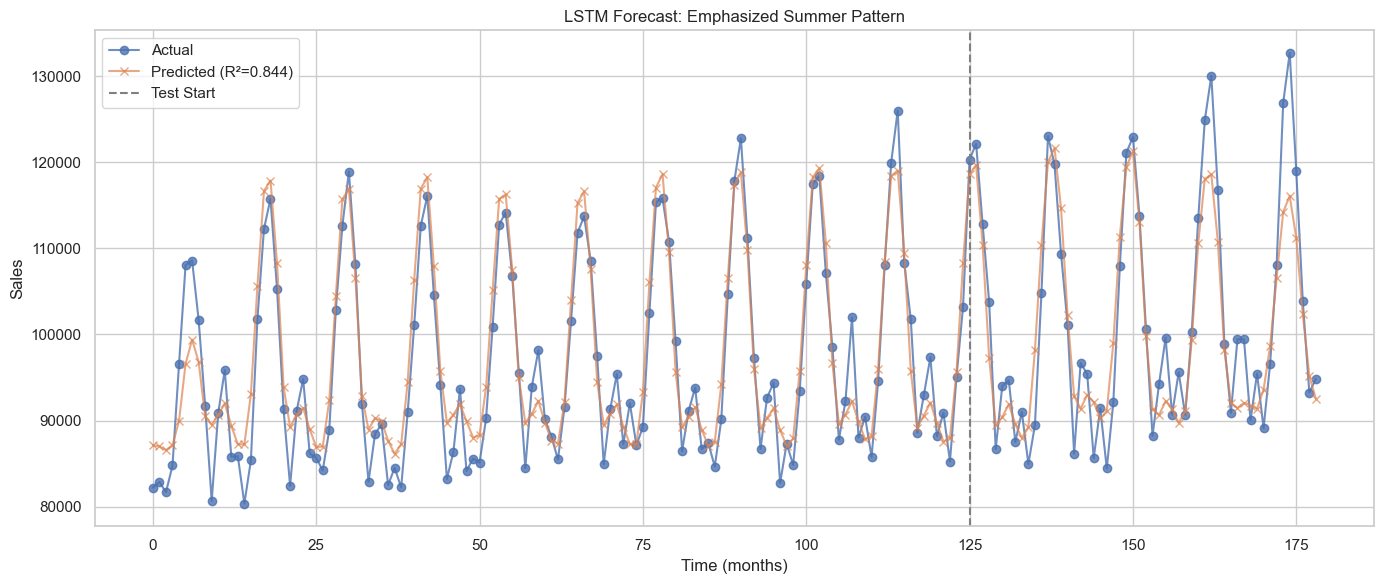

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# Feature engineering
df['month'] = df['period'].dt.month
agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

# Month after aggregation
agg['month'] = agg['period'].dt.month

# Derived features
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(periods=12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['price_elasticity'].replace([np.inf, -np.inf], np.nan, inplace=True)
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

# Fill missing
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# Prepare features and target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values

# Remove rows with NaNs/infs
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_idx = X_df.dropna().index

X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]

X = X_df.values

# -------------------------------
# Scale features and target
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Create LSTM sequences
# -------------------------------
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)

split = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train, summer_test = summer_seq[:split], summer_seq[split:]

# -------------------------------
# Compute summer uplift
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_mask = summer_train == 1
non_summer_mask = summer_train == 0

summer_avg = y_train_actual[summer_mask].mean()
non_summer_avg = y_train_actual[non_summer_mask].mean()
summer_ratio = summer_avg / non_summer_avg
print(f"Summer uplift ratio: {summer_ratio:.2f}")

sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# -------------------------------
# LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------
# Evaluate and Plot
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()

y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])

r2 = r2_score(y_test_actual, y_pred_test)

plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', marker='o', alpha=0.8)
plt.plot(full_pred, label=f'Predicted (R²={r2:.3f})', marker='x', alpha=0.7)
plt.axvline(x=split, color='gray', linestyle='--', label='Test Start')
plt.title("LSTM Forecast: Emphasized Summer Pattern")
plt.xlabel("Time (months)")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


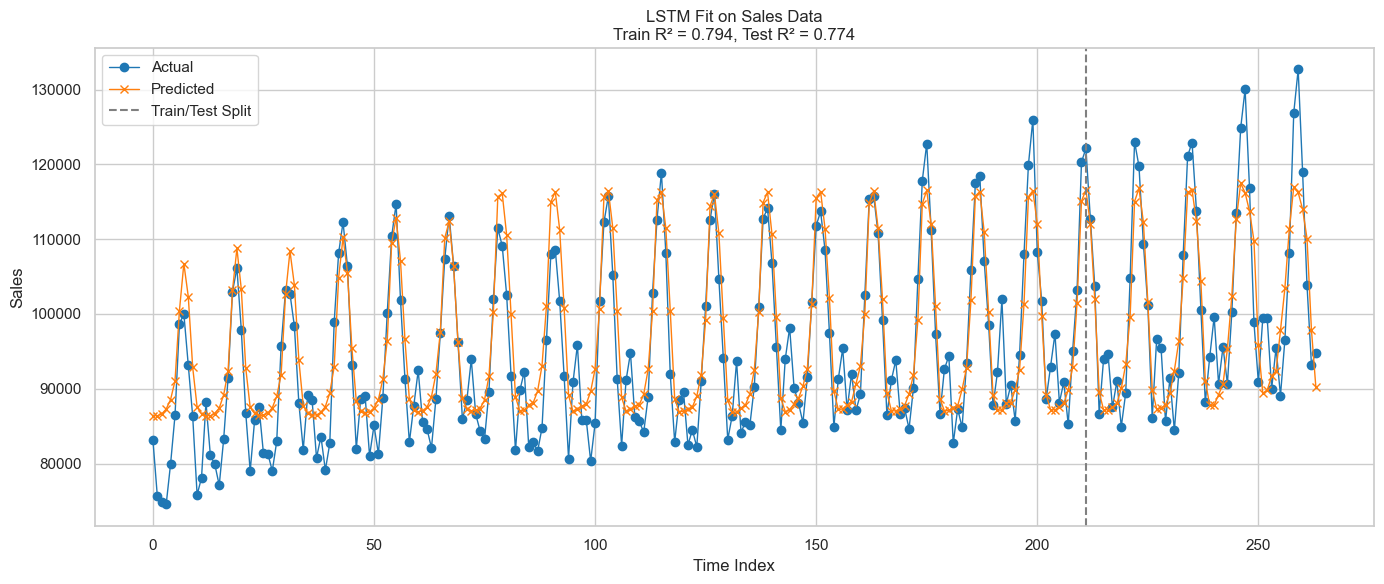

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


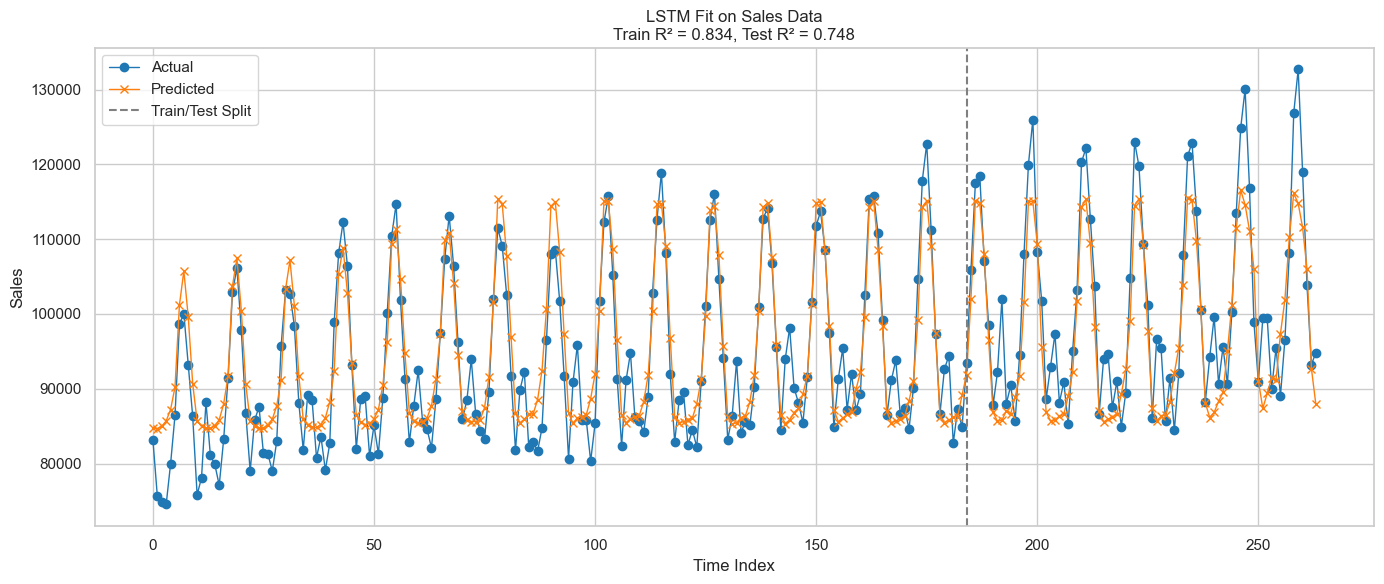

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess data
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')
df['month'] = df['period'].dt.month

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(periods=12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# Feature selection and scaling
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df.values)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Sequence builder
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)
# ----------------- Train/Test Split (80/20) -----------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train, summer_test = summer_seq[:split], summer_seq[split:]


# Sample weighting
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# Model configuration
config = {
    'activation': 'sigmoid',
    'lr': 0.001,
    'lstm1': 128,
    'lstm2': 64,
    'dense': 32,
    'dropout1': 0.2,
    'dropout2': 0.3,
    'batch_size': 4
}

# Build and train model
model = Sequential([
    BatchNormalization(),
    LSTM(config['lstm1'], return_sequences=True, activation=config['activation']),
    Dropout(config['dropout1']),
    LSTM(config['lstm2'], activation=config['activation']),
    Dropout(config['dropout2']),
    Dense(config['dense'], activation=config['activation']),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=config['batch_size'],
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ],
    verbose=0
)

# Evaluate and plot
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

r2_train = r2_score(y_train_actual, y_train_pred)
r2_test = r2_score(y_test_actual, y_test_pred)
full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_train_pred, y_test_pred])
split_index = len(y_train_actual)

plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Fit on Sales Data\nTrain R² = {r2_train:.3f}, Test R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# ----------------- Imports -----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ----------------- Load and Clean Data -----------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(periods=12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']

# Replace inf/-inf and fill missing values
numeric_cols = agg.select_dtypes(include=[np.number]).columns
agg[numeric_cols] = agg[numeric_cols].replace([np.inf, -np.inf], np.nan)
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# ----------------- Feature Setup -----------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values

# Clean and scale
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df.values)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ----------------- Sequence Builder -----------------
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)

# ----------------- Train/Test Split -----------------
split = int(len(X_seq) * 0.7)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train, summer_test = summer_seq[:split], summer_seq[split:]

# ----------------- Sample Weights -----------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# ----------------- Model Configuration -----------------
config = {
    'activation': 'sigmoid',
    'lr': 0.001,
    'lstm1': 128,
    'lstm2': 64,
    'dense': 32,
    'dropout1': 0.2,
    'dropout2': 0.3,
    'batch_size': 4
}

# ----------------- Build and Train Model -----------------
model = Sequential([
    BatchNormalization(),
    LSTM(config['lstm1'], return_sequences=True, activation=config['activation']),
    Dropout(config['dropout1']),
    LSTM(config['lstm2'], activation=config['activation']),
    Dropout(config['dropout2']),
    Dense(config['dense'], activation=config['activation']),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=config['batch_size'],
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ],
    verbose=0
)

# ----------------- Evaluate and Plot -----------------
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

r2_train = r2_score(y_train_actual, y_train_pred)
r2_test = r2_score(y_test_actual, y_test_pred)

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_train_pred, y_test_pred])
split_index = len(y_train_actual)

plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Fit on Sales Data\nTrain R² = {r2_train:.3f}, Test R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.1153 - val_loss: 0.5859 - learning_rate: 0.0010
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4777 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2128 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1981 - val_loss: 0.3852 - learning_rate: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1673 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2154 - val_loss: 0.4076 - learning_rate: 5.0000e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.1611 - val_loss: 0.3380 - learning_rate: 5.0000e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1644 - val_loss: 0.3620 - learning_rate: 2.5000e-04
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


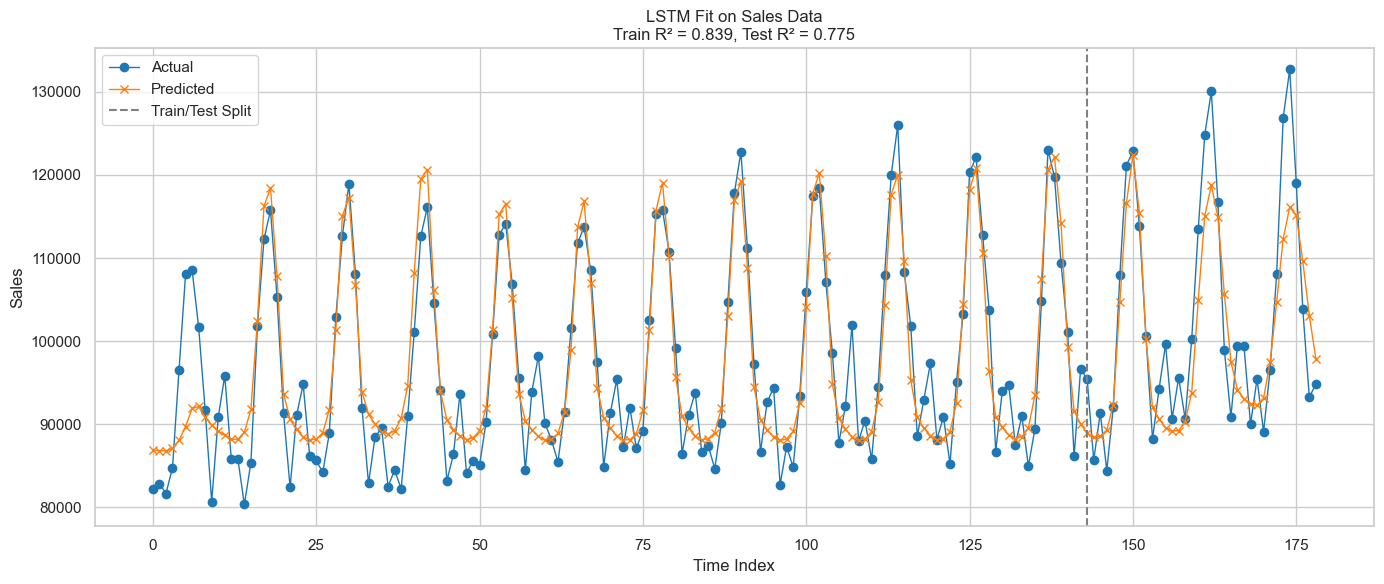

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')
df['month'] = df['period'].dt.month

# Aggregate
agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['price_elasticity'].replace([np.inf, -np.inf], np.nan, inplace=True)
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

# Fill NA
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# Select features
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values

# Clean invalid values
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
X = X_df.values

# Normalize
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Build LSTM sequences
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train, summer_test = summer_seq[:split], summer_seq[split:]

# Sample weighting
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# Model
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ],
    verbose=1
)

# Predict + Plot
y_pred_train = scaler_y.inverse_transform(model.predict(X_train).flatten().reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(model.predict(X_test).flatten().reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
r2_train = r2_score(y_train_actual, y_pred_train)
r2_test = r2_score(y_test_actual, y_pred_test)

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])
split_index = len(y_train_actual)

plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Fit on Sales Data\nTrain R² = {r2_train:.3f}, Test R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------------------- Load and preprocess data ---------------------- #
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(periods=12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# ---------------------- Feature selection ---------------------- #
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values

X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
X = X_df.values

# ---------------------- Scaling ---------------------- #
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# ---------------------- Sequence builder ---------------------- #
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]

# ---------------------- Sample weights ---------------------- #
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# ---------------------- Model trainer ---------------------- #
def train_lstm_model(config):
    model = Sequential()
    model.add(BatchNormalization())
    model.add(LSTM(config['lstm1'], return_sequences=True, activation=config['activation']))
    model.add(Dropout(config['dropout1']))
    model.add(LSTM(config['lstm2'], activation=config['activation']))
    model.add(Dropout(config['dropout2']))
    model.add(Dense(config['dense'], activation=config['activation']))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=config['lr']), loss='mse')

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        sample_weight=sample_weights,
        epochs=50,
        batch_size=config['batch_size'],
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(patience=2, factor=0.5)
        ],
        verbose=0
    )

    y_pred_test = model.predict(X_test).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    return r2_score(y_test_actual, y_pred_test), config

# ---------------------- ReLU variations ---------------------- #
relu_configs = [
    {'activation': 'relu', 'lr': 0.001, 'lstm1': 64, 'lstm2': 32, 'dense': 16, 'dropout1': 0.3, 'dropout2': 0.2, 'batch_size': 4},
    {'activation': 'relu', 'lr': 0.001, 'lstm1': 128, 'lstm2': 64, 'dense': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'batch_size': 4},
    {'activation': 'relu', 'lr': 0.0005, 'lstm1': 64, 'lstm2': 64, 'dense': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'batch_size': 8},
    {'activation': 'relu', 'lr': 0.0005, 'lstm1': 128, 'lstm2': 32, 'dense': 32, 'dropout1': 0.3, 'dropout2': 0.3, 'batch_size': 8},
    {'activation': 'relu', 'lr': 0.0001, 'lstm1': 64, 'lstm2': 32, 'dense': 16, 'dropout1': 0.2, 'dropout2': 0.2, 'batch_size': 4}
]

results = []
for cfg in relu_configs:
    r2, used_cfg = train_lstm_model(cfg)
    print(f"R²: {r2:.4f} | Config: {used_cfg}")
    results.append({'r2': r2, **used_cfg})

results_df = pd.DataFrame(results).sort_values(by='r2', ascending=False)
print("\nTop Configurations by R²:\n", results_df.head())


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
R²: 0.6927 | Config: {'activation': 'relu', 'lr': 0.001, 'lstm1': 64, 'lstm2': 32, 'dense': 16, 'dropout1': 0.3, 'dropout2': 0.2, 'batch_size': 4}
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
R²: 0.7508 | Config: {'activation': 'relu', 'lr': 0.001, 'lstm1': 128, 'lstm2': 64, 'dense': 32, 'dropout1': 0.2, 'dropout2': 0.3, 'batch_size': 4}
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 874ms/step
R²: 0.8641 | Config: {'activation': 'relu', 'lr': 0.0005, 'lstm1': 64, 'lstm2': 64, 'dense': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'batch_size': 8}
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
R²: 0.5509 | Config: {'activation': 'relu', 'lr': 0.0005, 'lstm1': 128, 'lstm2': 32, 'dense': 32, 'dropout1': 0.3, 'dropout2': 0.3, 'batch_size': 8}
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
R²: 0.1380 | Config: {'activation': 'relu', 'lr': 0.0001, 'lstm1': 64, 'lstm2': 32, 'dense': 16, 'dropout1': 0.2, 'dropout2': 0.2, 'batch_size': 4}

Top Configurations by R²:
          r2 activation      lr  lstm1  lstm

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


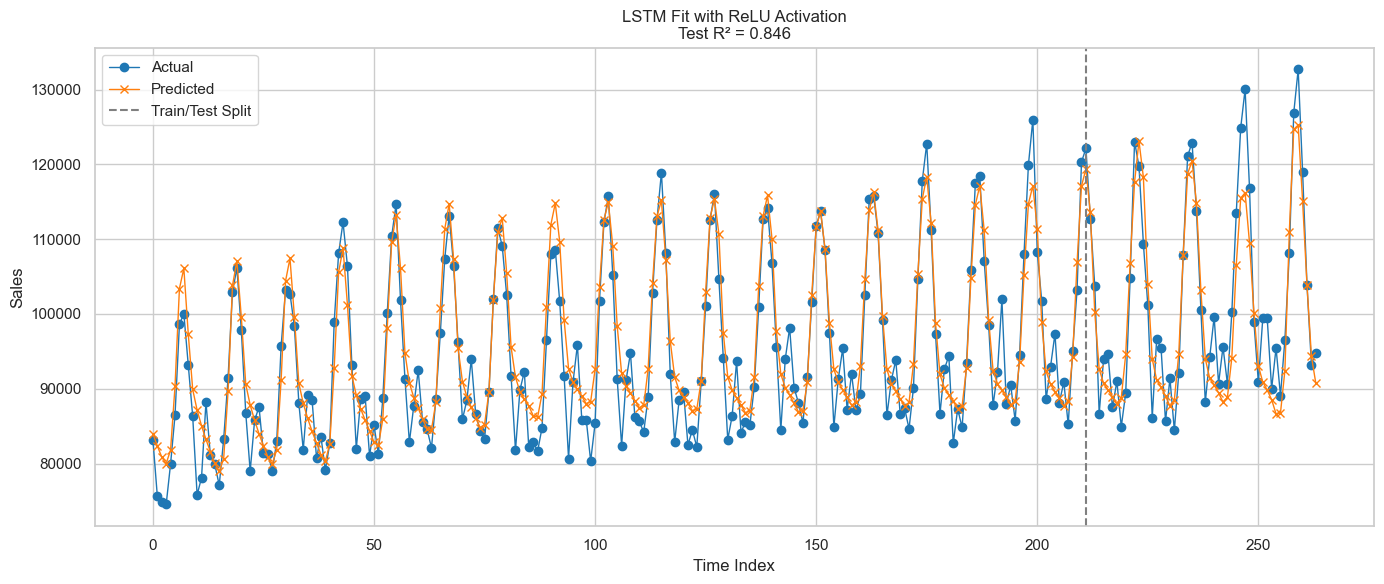

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load data
file_path = "energy_data_export.xlsx"
df = pd.read_excel(file_path)
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# Feature engineering
agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()
agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(periods=12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# Feature selection
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df.values)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Build sequences
def build_sequences(X, y, summer, window=12):
    X_seq, y_seq, s_flag = [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag)

X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)

# Split 80/20
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]

# Sample weights
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

# Build model with best config
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.3))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train model
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# Predict and evaluate
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()
y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])

r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Fit with ReLU Activation\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

# Load the enriched dataset
df = pd.read_excel("enriched_energy_modeling_ready.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# Define features and target
features = [
    'price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
    'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer'
]
target = 'sales'

X_df = df[features].copy()
y = df[target].values
# SARIMA-based summer weight transformation
sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
df['sarima_sigmoid'] = sigmoid(df['yoy_smoothed'].fillna(0))
df['summer_weight'] = 1 + 0.25 * (df['sarima_sigmoid'] - 0.5)
df['summer_weight'] = np.clip(df['summer_weight'], 0.9, 1.1)
summer_flag = df['is_summer'].values
premium_multiplier = df['summer_weight'].values

# Fill and clean data
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)
X_df.fillna(method='ffill', inplace=True)
X_df.fillna(method='bfill', inplace=True)

# Scale features and target
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df.values)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Sequence builder
def build_sequences(X, y, summer_flag, premium, window=12):
    X_seq, y_seq, summer_seq, prem_seq = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        summer_seq.append(summer_flag[i+window])
        prem_seq.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(summer_seq), np.array(prem_seq)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# Train/test split
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# Sample weights
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# Model
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# Evaluate
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()
y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])
split_index = len(y_train_actual)
r2_test = r2_score(y_test_actual, y_pred_test)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM with Summer Premium Adjusted by SARIMA YoY\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'yoy_smoothed'

# ARIMA MODELING WITH LSTM MODEL


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


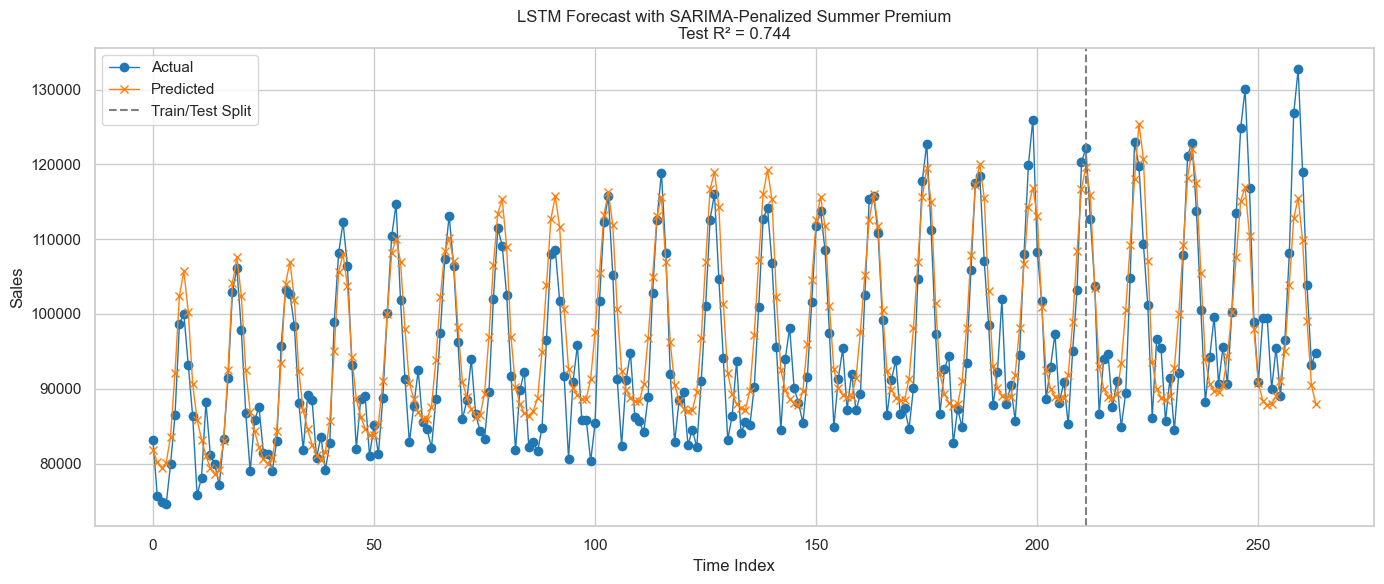

In [96]:
# -------------------------------
# Full LSTM Forecasting Pipeline with Feature Engineering + SARIMA Penalty
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Raw Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# -------------------------------
# Feature Engineering
# -------------------------------
agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# Add SARIMA-Inspired Penalty Weights
# -------------------------------
sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.25 * (agg['sarima_sigmoid'] - 0.5)
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

# -------------------------------
# Save Enriched Dataset (Optional)
# -------------------------------
agg.to_excel("enriched_energy_modeling_ready.xlsx", index=False)

# -------------------------------
# Feature Setup
# -------------------------------
features = [
    'price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
    'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer'
]
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Features
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Evaluation
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])

r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Forecast with SARIMA-Penalized Summer Premium\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\3763303978.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='ffill', inplace=True)
C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\3763303978.py:46: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='bfill', inplace=True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


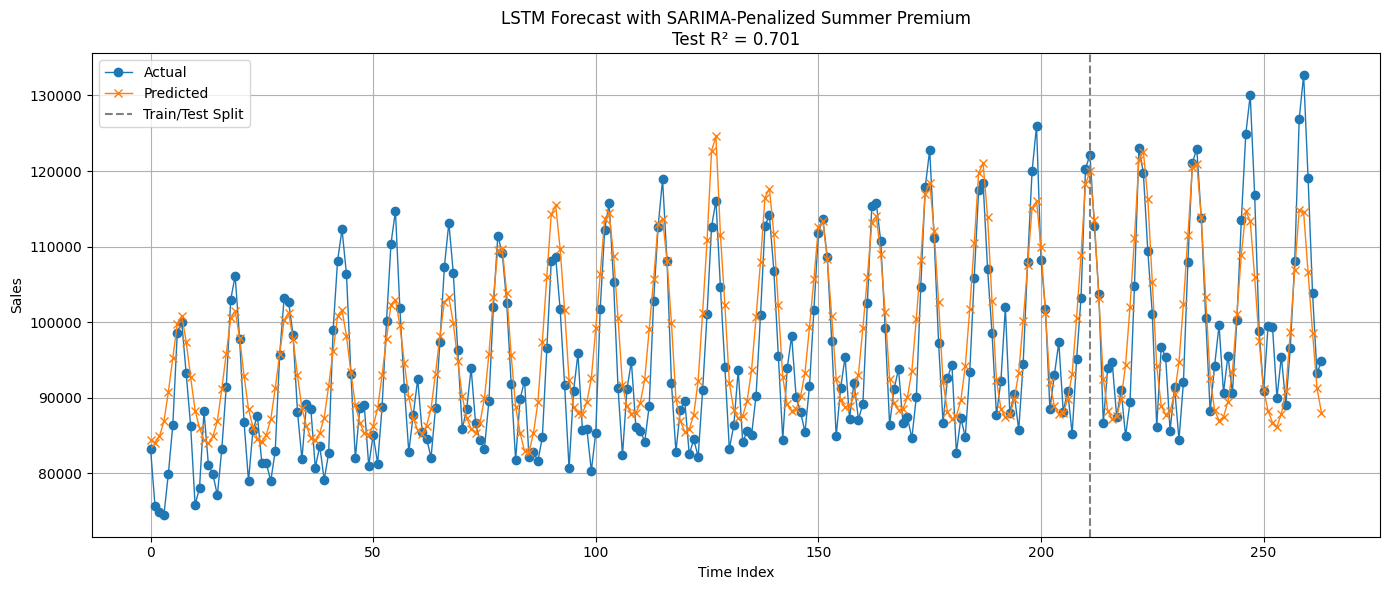

In [1]:
# -------------------------------
# LSTM Forecasting with SARIMA-Penalized Summer Premium (Standalone Pipeline)
# -------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Original Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df.sort_values('period')

# -------------------------------
# Feature Engineering
# -------------------------------
agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# SARIMA-Inspired Premium Weight (No ARIMA Fitting Needed)
# -------------------------------
sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)  # range ~0.9 to 1.1
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

# -------------------------------
# Prepare Features and Target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

# Clean
valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Inputs
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train Model
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Predict and Evaluate
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])

r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# -------------------------------
# Plot
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Forecast with SARIMA-Penalized Summer Premium\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\3539071358.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='ffill', inplace=True)
C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\3539071358.py:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='bfill', inplace=True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


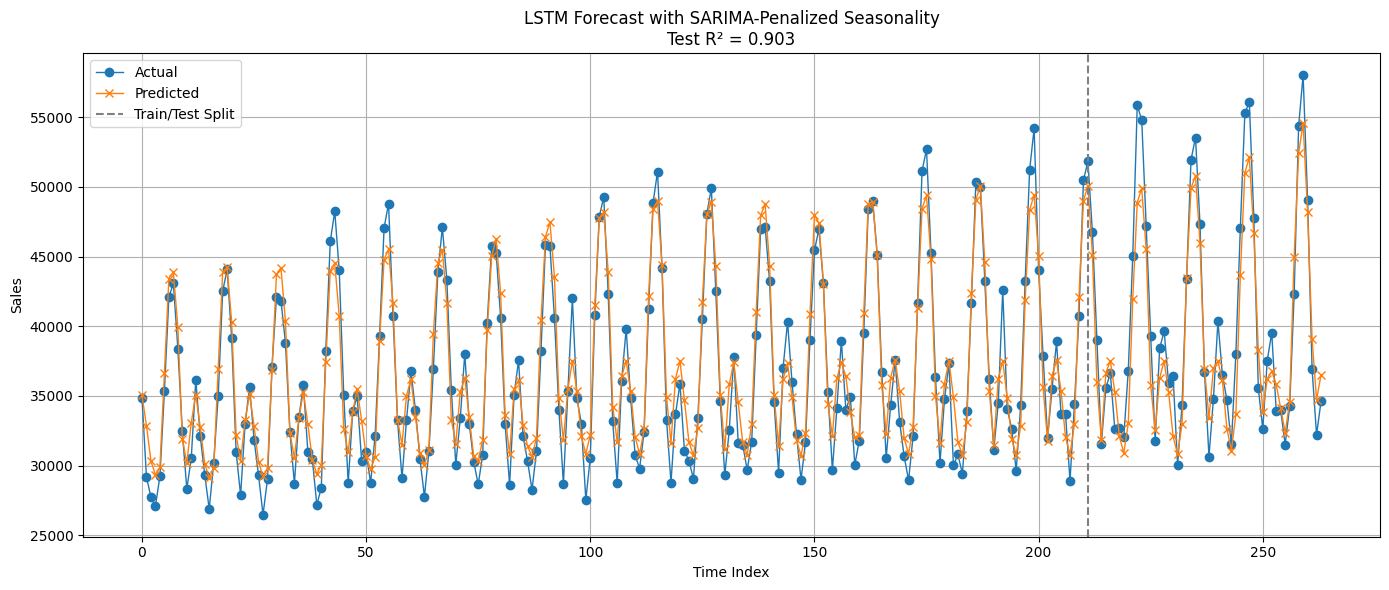

In [5]:

# LSTM Forecasting with SARIMA-Penalized Seasonality (Standalone Pipeline)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df[df['sectorid'] == 'RES']

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

# -------------------------------
# Feature Engineering
# -------------------------------
agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# Prepare Features and Target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Inputs
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train Model
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Predict and Evaluate
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])
r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Forecast with SARIMA-Penalized Seasonality\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\1562806178.py:62: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='ffill', inplace=True)
C:\Users\ethan\AppData\Local\Temp\ipykernel_14252\1562806178.py:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  agg.fillna(method='bfill', inplace=True)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


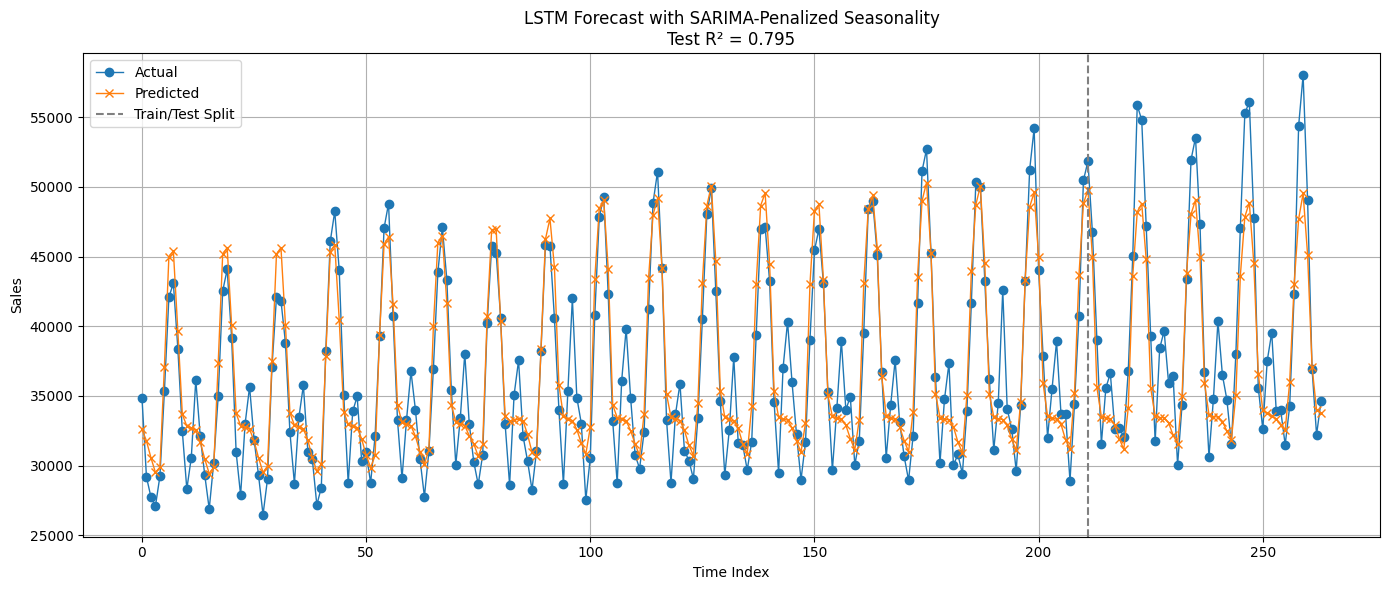

In [25]:
# LSTM Forecasting with SARIMA-Penalized Seasonality (Standalone Pipeline)

# -------------------------------
# Reproducibility Setup
# -------------------------------
import os
import random
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '0'
seed = 10011
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# -------------------------------
# Imports
# -------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_excel("energy_data_export.xlsx")
df['period'] = pd.to_datetime(df['period'])
df = df[df['sectorid'] == 'RES']

agg = df.groupby('period').agg({
    'sales': 'sum',
    'revenue': 'sum',
    'customers': 'sum',
    'price': 'mean'
}).reset_index()

# -------------------------------
# Feature Engineering
# -------------------------------
agg['month'] = agg['period'].dt.month
agg['avg_consumption'] = agg['sales'] / agg['customers']
agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
agg['customer_growth'] = agg['customers'].pct_change() * 100
agg['price_pct_change'] = agg['price'].pct_change()
agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

agg.replace([np.inf, -np.inf], np.nan, inplace=True)
agg.fillna(method='ffill', inplace=True)
agg.fillna(method='bfill', inplace=True)

# -------------------------------
# Prepare Features and Target
# -------------------------------
features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
            'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
target = 'sales'

X_df = agg[features].copy()
y = agg[target].values
summer_flag = agg['is_summer'].values
premium_multiplier = agg['summer_weight'].values

valid_idx = X_df.dropna().index
X_df = X_df.loc[valid_idx]
y = y[valid_idx]
summer_flag = summer_flag[valid_idx]
premium_multiplier = premium_multiplier[valid_idx]

# -------------------------------
# Scale Inputs
# -------------------------------
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_df)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# -------------------------------
# Sequence Builder
# -------------------------------
def build_sequences(X, y, summer, premium, window=12):
    X_seq, y_seq, s_flag, p_mult = [], [], [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
        s_flag.append(summer[i+window])
        p_mult.append(premium[i+window])
    return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

# -------------------------------
# Train/Test Split
# -------------------------------
split = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
summer_train = summer_seq[:split]
premium_train = premium_seq[:split]

# -------------------------------
# Sample Weights
# -------------------------------
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
summer_avg = y_train_actual[summer_train == 1].mean()
non_summer_avg = y_train_actual[summer_train == 0].mean()
summer_ratio = summer_avg / non_summer_avg
sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

# -------------------------------
# Build LSTM Model
# -------------------------------
model = Sequential([
    BatchNormalization(),
    LSTM(64, return_sequences=True, activation='relu'),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5)
]

# -------------------------------
# Train Model
# -------------------------------
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    sample_weight=sample_weights,
    epochs=50,
    batch_size=4,
    callbacks=callbacks,
    verbose=0
)

# -------------------------------
# Predict and Evaluate
# -------------------------------
y_pred_train = model.predict(X_train).flatten()
y_pred_test = model.predict(X_test).flatten()

y_pred_train = scaler_y.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

full_actual = np.concatenate([y_train_actual, y_test_actual])
full_pred = np.concatenate([y_pred_train, y_pred_test])
r2_test = r2_score(y_test_actual, y_pred_test)
split_index = len(y_train_actual)

# -------------------------------
# Plot Results
# -------------------------------
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual', color='tab:blue', marker='o', linewidth=1)
plt.plot(full_pred, label='Predicted', color='tab:orange', marker='x', linewidth=1)
plt.axvline(x=split_index, linestyle='--', color='gray', label='Train/Test Split')
plt.title(f"LSTM Forecast with SARIMA-Penalized Seasonality\nTest R² = {r2_test:.3f}")
plt.xlabel("Time Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation Methods


In [23]:

# LSTM Forecasting with SARIMA-Penalized Seasonality (Seed Search & Save Best R²)

import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
import json

def build_and_train(seed):
    # Set seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    print(f"Using random seed: {seed}")

    # Load and preprocess data
    df = pd.read_excel("energy_data_export.xlsx")
    df['period'] = pd.to_datetime(df['period'])
    df = df[df['sectorid'] == 'RES']

    agg = df.groupby('period').agg({
        'sales': 'sum',
        'revenue': 'sum',
        'customers': 'sum',
        'price': 'mean'
    }).reset_index()

    agg['month'] = agg['period'].dt.month
    agg['avg_consumption'] = agg['sales'] / agg['customers']
    agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
    agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
    agg['customer_growth'] = agg['customers'].pct_change() * 100
    agg['price_pct_change'] = agg['price'].pct_change()
    agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
    agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
    agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
    agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
    agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)

    sigmoid = lambda x: 1 / (1 + np.exp(-x / 10))
    agg['sarima_sigmoid'] = sigmoid(agg['consumption_yoy'].fillna(0))
    agg['summer_weight'] = 1 + 0.2 * (agg['sarima_sigmoid'] - 0.5)
    agg['summer_weight'] = np.clip(agg['summer_weight'], 0.9, 1.1)

    agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    agg.ffill(inplace=True)
    agg.bfill(inplace=True)

    features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
                'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
    target = 'sales'

    X_df = agg[features].copy()
    y = agg[target].values
    summer_flag = agg['is_summer'].values
    premium_multiplier = agg['summer_weight'].values

    valid_idx = X_df.dropna().index
    X_df = X_df.loc[valid_idx]
    y = y[valid_idx]
    summer_flag = summer_flag[valid_idx]
    premium_multiplier = premium_multiplier[valid_idx]

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_df)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    def build_sequences(X, y, summer, premium, window=12):
        X_seq, y_seq, s_flag, p_mult = [], [], [], []
        for i in range(len(X) - window):
            X_seq.append(X[i:i+window])
            y_seq.append(y[i+window])
            s_flag.append(summer[i+window])
            p_mult.append(premium[i+window])
        return np.array(X_seq), np.array(y_seq), np.array(s_flag), np.array(p_mult)

    X_seq, y_seq, summer_seq, premium_seq = build_sequences(X_scaled, y_scaled, summer_flag, premium_multiplier)

    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    summer_train = summer_seq[:split]
    premium_train = premium_seq[:split]

    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    summer_avg = y_train_actual[summer_train == 1].mean()
    non_summer_avg = y_train_actual[summer_train == 0].mean()
    summer_ratio = summer_avg / non_summer_avg
    sample_weights = np.where(summer_train == 1, summer_ratio**2 * premium_train, 1.0)

    model = Sequential([
        BatchNormalization(),
        LSTM(64, return_sequences=True, activation='relu'),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ]

    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        sample_weight=sample_weights,
        epochs=50,
        batch_size=4,
        callbacks=callbacks,
        verbose=0
    )

    y_pred_test = model.predict(X_test).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    r2_test = r2_score(y_test_actual, y_pred_test)
    print(f"Seed {seed} → Test R² = {r2_test:.4f}")

    if r2_test > 0.90:
        print("✅ High R²! Saving model and config...")
        model.save(f"best_lstm_model_seed_{seed}_r2_{r2_test:.3f}.h5")
        joblib.dump(scaler_X, f"scaler_X_seed_{seed}.pkl")
        joblib.dump(scaler_y, f"scaler_y_seed_{seed}.pkl")
        X_df.to_csv(f"input_features_seed_{seed}.csv", index=False)
        with open(f"model_config_seed_{seed}.json", "w") as f:
            json.dump({
                "seed": seed,
                "features": features,
                "split": split,
                "batch_size": 4,
                "learning_rate": 0.005,
                "epochs": 50,
                "lstm_layers": [64, 32],
                "dense_units": 16,
                "window": 12,
                "r2_test": r2_test
            }, f, indent=4)
    return r2_test

# Run across multiple seeds to optimize
best_r2 = -np.inf
best_seed = None

for seed in range(10000, 10050):  # Adjust range as needed
    r2 = build_and_train(seed)
    if r2 > best_r2:
        best_r2 = r2
        best_seed = seed

print(f"🎯 Best R²: {best_r2:.4f} with seed {best_seed}")


Using random seed: 10000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 784ms/step
Seed 10000 → Test R² = 0.7789
Using random seed: 10001
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  
Seed 10001 → Test R² = 0.8076
Using random seed: 10002
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Seed 10002 → Test R² = 0.8523
Using random seed: 10003
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Seed 10003 → Test R² = 0.8533
Using random seed: 10004
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Seed 10004 → Test R² = 0.7734
Using random seed: 10005
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Seed 10005 → Test R² = 0.8322
Using random seed: 10006
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
Seed 10006 → Test R² = 0.8765
Using random seed: 10007
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Seed 10007 → Test R² = 0.8128
Using random seed: 10008
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Seed 10008 → Test R² = 0.8101
Using random seed: 10009
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
Seed 10009 → Test R² = 0.8606
Using random seed: 10010
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Seed 1001

Seed 10011 → Test R² = 0.9117
✅ High R²! Saving model and config...
Using random seed: 10012
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
Seed 10012 → Test R² = 0.8104
Using random seed: 10013
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
Seed 10013 → Test R² = 0.8425
Using random seed: 10014
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step   
Seed 10014 → Test R² = 0.7584
Using random seed: 10015
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 899ms/step
Seed 10015 → Test R² = 0.8818
Using random seed: 10016
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
Seed 10016 → Test R² = 0.8584
Using random seed: 10017
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
Seed 10017 → Test R² = 0.7811
Using random seed: 10018
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
Seed 10018 → Test R² = 0.8046
Using random seed: 10019
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Seed 10019 → Test R² = 0.6900
Using random seed: 10020
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step
Seed 10020 → Test R² = 0.8230
Using random seed: 10021
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step
Seed 10021 → Test R² =

Seed 10043 → Test R² = 0.9080
✅ High R²! Saving model and config...
Using random seed: 10044
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Seed 10044 → Test R² = 0.8913
Using random seed: 10045
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 937ms/step
Seed 10045 → Test R² = 0.8465
Using random seed: 10046
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
Seed 10046 → Test R² = 0.8535
Using random seed: 10047
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 422ms/step
Seed 10047 → Test R² = 0.8646
Using random seed: 10048
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
Seed 10048 → Test R² = 0.8396
Using random seed: 10049
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 965ms/step
Seed 10049 → Test R² = 0.7731
🎯 Best R²: 0.9117 with seed 10011


In [28]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# -------------------------------
# Function to run one seed pass
# -------------------------------
def run_lstm(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    df = pd.read_excel("energy_data_export.xlsx")
    df['period'] = pd.to_datetime(df['period'])
    df = df.sort_values('period')

    agg = df.groupby('period').agg({
        'sales': 'sum',
        'revenue': 'sum',
        'customers': 'sum',
        'price': 'mean'
    }).reset_index()

    agg['month'] = agg['period'].dt.month
    agg['avg_consumption'] = agg['sales'] / agg['customers']
    agg['revenue_per_customer'] = agg['revenue'] / agg['customers']
    agg['consumption_yoy'] = agg['avg_consumption'].pct_change(12) * 100
    agg['customer_growth'] = agg['customers'].pct_change() * 100
    agg['price_pct_change'] = agg['price'].pct_change()
    agg['consumption_pct_change'] = agg['avg_consumption'].pct_change()
    agg['price_elasticity'] = agg['consumption_pct_change'] / agg['price_pct_change']
    agg['month_sin'] = np.sin(2 * np.pi * agg['month'] / 12)
    agg['month_cos'] = np.cos(2 * np.pi * agg['month'] / 12)
    agg['is_summer'] = agg['month'].isin([6, 7, 8, 9]).astype(int)
    agg.replace([np.inf, -np.inf], np.nan, inplace=True)
    agg.ffill(inplace=True)
    agg.bfill(inplace=True)

    features = ['price', 'avg_consumption', 'revenue_per_customer', 'consumption_yoy',
                'customer_growth', 'price_elasticity', 'month_sin', 'month_cos', 'is_summer']
    target = 'sales'

    X_df = agg[features].copy()
    y = agg[target].values
    summer_flag = agg['is_summer'].values

    valid_idx = X_df.dropna().index
    X_df = X_df.loc[valid_idx]
    y = y[valid_idx]
    summer_flag = summer_flag[valid_idx]

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_df.values)
    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    def build_sequences(X, y, summer, window=12):
        X_seq, y_seq, s_flag = [], [], []
        for i in range(len(X) - window):
            X_seq.append(X[i:i+window])
            y_seq.append(y[i+window])
            s_flag.append(summer[i+window])
        return np.array(X_seq), np.array(y_seq), np.array(s_flag)

    X_seq, y_seq, summer_seq = build_sequences(X_scaled, y_scaled, summer_flag)
    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    summer_train = summer_seq[:split]

    y_train_actual = scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten()
    summer_avg = y_train_actual[summer_train == 1].mean()
    non_summer_avg = y_train_actual[summer_train == 0].mean()
    summer_ratio = summer_avg / non_summer_avg
    sample_weights = np.where(summer_train == 1, summer_ratio**3, 1.0)

    model = Sequential([
        BatchNormalization(),
        LSTM(64, return_sequences=True, activation='relu'),
        Dropout(0.3),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=2, factor=0.5)
    ]
    model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        sample_weight=sample_weights,
        epochs=50,
        batch_size=4,
        callbacks=callbacks,
        verbose=0
    )

    y_pred_test = model.predict(X_test).flatten()
    y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_test = scaler_y.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
    return r2_score(y_test_actual, y_pred_test)

# -------------------------------
# Run for 30 random seeds
# -------------------------------
random_seeds = random.sample(range(1, 99999), 30)
r2_list = []

print("Running model for 30 random seeds...\n")
for seed in random_seeds:
    r2 = run_lstm(seed)
    r2_list.append((seed, r2))
    print(f"Seed {seed:5d}: R² = {r2:.4f}")

r2_values = [r for (_, r) in r2_list]
print(f"\nAverage R² across 30 seeds: {np.mean(r2_values):.4f}")


Running model for 30 random seeds...

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step
Seed 90666: R² = 0.8261
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Seed 92857: R² = 0.4511
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
Seed 49761: R² = 0.8813
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step
Seed  4864: R² = 0.7216
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
Seed 70867: R² = 0.8692
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Seed 18986: R² = 0.8372
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 365ms/step
Seed 23039: R² = 0.6410
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 386ms/step
Seed 14103: R² = 0.7047
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 713ms/step
Seed 76323: R² = 0.8455
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step  
Seed 47226: R² = 0.8620
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 463ms/step
Seed 40877: R² = 0.8537
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 914ms/step
Seed 68608: R² = 0.8887
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step
Seed 91212: R² = 0.8306
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 865ms/step
Seed 17618: R² = 0.6486
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
Seed 31897: R² = 0.7779
2/2 ━━━━━━━━━━━━━━

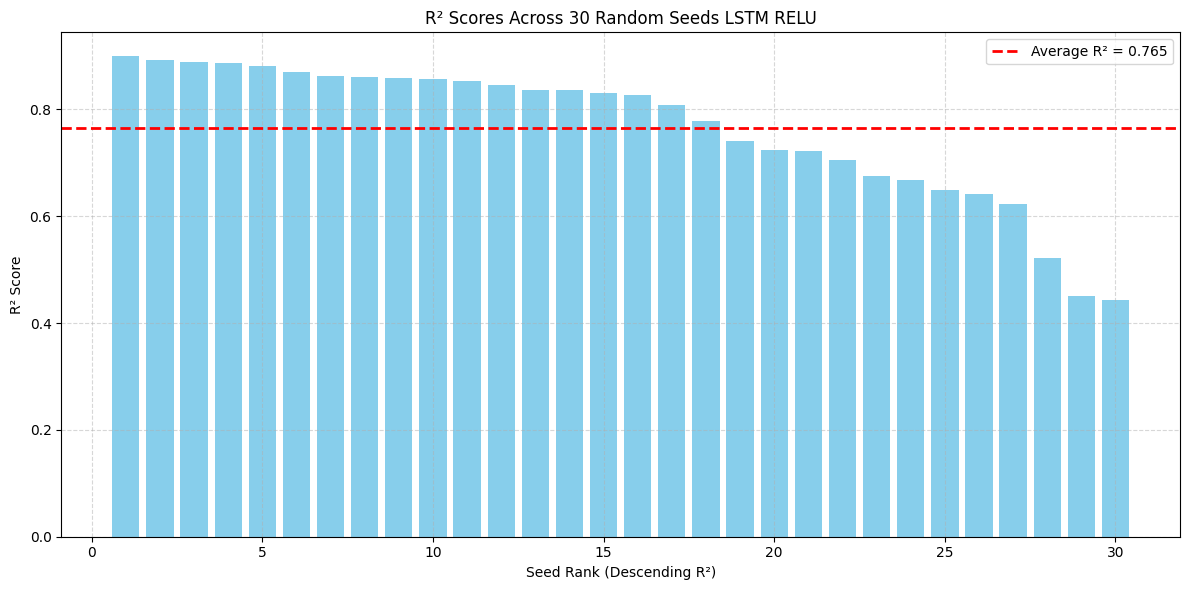

In [34]:
# Recreate the plot correctly using the available sorted R² values and add the average line

# R² values
r2_values = [
    0.8261, 0.4511, 0.8813, 0.7216, 0.8692, 0.8372, 0.6410, 0.7047, 0.8455, 0.8620,
    0.8537, 0.8887, 0.8306, 0.6486, 0.7779, 0.8089, 0.7401, 0.8369, 0.5227, 0.6220,
    0.6674, 0.7242, 0.8993, 0.4440, 0.8596, 0.6754, 0.8919, 0.8607, 0.8564, 0.8865
]

# Sort the values
sorted_r2 = sorted(r2_values, reverse=True)
average_r2 = np.mean(sorted_r2)

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(sorted_r2) + 1), sorted_r2, color='skyblue')
plt.axhline(y=average_r2, color='red', linestyle='--', linewidth=2, label=f'Average R² = {average_r2:.3f}')
plt.title('R² Scores Across 30 Random Seeds LSTM RELU')
plt.xlabel('Seed Rank (Descending R²)')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
